In [2]:
import config
import sqlalchemy
import functions
import statsapi as mlb
import sql_alch_schema
from datetime import datetime

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String,DateTime,Date,Time,Boolean,func
from sqlalchemy import ForeignKey,and_
from sqlalchemy.orm import relationship
from sqlalchemy.schema import Table
from sqlalchemy import distinct

_sql_alchemy_connection = (
                                f'mysql+mysqlconnector://'
                                f'{config.user}:{config.password}'
                                f'@{config.host}:{config.port}'
                                f'/{config.schema}'
                           )
## Create the engine 
db = sqlalchemy.create_engine(_sql_alchemy_connection,
                              echo = False,
                              connect_args = {'ssl_disabled' : True,})

Base = sql_alch_schema.Base

Game = sql_alch_schema.Game
Play = sql_alch_schema.Play
Team = sql_alch_schema.Team
GameTeamLink = sql_alch_schema.GameTeamLink
Person = sql_alch_schema.Person


from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=db)
session = Session()

#Base.metadata.create_all(db)

import sqlalchemy_schemadisplay
from sqlalchemy import MetaData

schema_viz = sqlalchemy_schemadisplay.create_schema_graph(metadata=MetaData(db))
schema_viz.write_png('dbschema.png')

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

In [3]:
image_dir = "/Users/schlinkertc/code/mlb_predictions/mlb_predictions/images/"

## What's in our DB?


The yankees played the mets on my birthday, so obviously we're gonna look at that game

In [4]:
yankees = session.query(Team).filter(Team.teamName=='Yankees').one()
yankees.id

147

In [5]:
june_11 = datetime(2019,6,11)
yankees_mets6_11 = (session.query(Game)
                    .order_by(Game.dateTime.asc())
                    .filter(and_(Game.dateTime>june_11,
                                 Game.homeTeam_id==yankees.id))
                    .first())

In [6]:
yankees_mets6_11

<Game(pk='567491',id='2019/06/11/nynmlb-nyamlb-1')>

In [7]:
# we won!
home_score = max([x.homeScore for x in yankees_mets6_11.plays])
away_score = max([x.awayScore for x in yankees_mets6_11.plays])
print(home_score,away_score)

12 5


## Import Dataset

In [9]:


def merge_scores(session):
    """
    Takes in a dataframe and a sql alch session, returns df with game scores added. merges with 'ID' column.
    """
    df = pd.read_csv('dataset.csv')
    game_scores = session.execute("""select 
                                         games.id,
                                         max(plays.homeScore) as home_score,
                                         max(plays.awayScore) as home_score
                                     from
                                         MLB_Stats.games
                                     inner join
                                         MLB_Stats.plays
                                         on
                                         games.id=plays.game_id
                                     where
                                         games.`type`='R'
                                     group by 
                                         games.id;""").fetchall()
    game_scores=pd.DataFrame.from_records(game_scores,columns=['ID','home_score','away_score'])

    df=pd.merge(right=game_scores,
            left=df,
            right_on='ID',
            left_on='ID')
    return df

df = merge_scores(session)

In [11]:
df.shape

(3109, 113)

In [380]:
score_dict[:5]

[{'ID': '2019/06/11/nynmlb-nyamlb-1', 'home_score': 12, 'away_score': 5},
 {'ID': '2018/04/02/balmlb-houmlb-1', 'home_score': 6, 'away_score': 1},
 {'ID': '2018/04/02/bosmlb-miamlb-1', 'home_score': 3, 'away_score': 7},
 {'ID': '2018/04/02/chamlb-tormlb-1', 'home_score': 4, 'away_score': 2},
 {'ID': '2018/04/02/chnmlb-cinmlb-1', 'home_score': 1, 'away_score': 0}]

## Let's go exploring
- Where do individual players' avgs lie on univariate distributions of features
- compare/contrast feature distributions by winning/losing teams

In [247]:
df_homeWin=df[df['home_score']>df['away_score']]
df_awayWin=df[df['home_score']<df['away_score']]

#### seperate stats by winning/losing teams

In [256]:
df.columns.tolist()

['home_starter_BA',
 'home_starter_SLG',
 'home_starter_OBP',
 'home_starter_PA_per_Game',
 'home_starter_WHIP',
 'home_starter_H9',
 'home_starter_HR9',
 'home_starter_SO9',
 'home_starter_SOW',
 'home_starter_GO_O',
 'home_starter_FO_O',
 'home_starter_PO_O',
 'home_starter_LO_O',
 'away_starter_BA',
 'away_starter_SLG',
 'away_starter_OBP',
 'away_starter_PA_per_Game',
 'away_starter_WHIP',
 'away_starter_H9',
 'away_starter_HR9',
 'away_starter_SO9',
 'away_starter_SOW',
 'away_starter_GO_O',
 'away_starter_FO_O',
 'away_starter_PO_O',
 'away_starter_LO_O',
 'home_relief_BA_mean',
 'away_relief_BA_mean',
 'home_relief_BA_std',
 'away_relief_BA_std',
 'home_relief_SLG_mean',
 'away_relief_SLG_mean',
 'home_relief_SLG_std',
 'away_relief_SLG_std',
 'home_relief_OBP_mean',
 'away_relief_OBP_mean',
 'home_relief_OBP_std',
 'away_relief_OBP_std',
 'home_relief_PA_per_Game_mean',
 'away_relief_PA_per_Game_mean',
 'home_relief_PA_per_Game_std',
 'away_relief_PA_per_Game_std',
 'home_relie

In [277]:
stats = {x.split("_",1)[1] for x in df.columns.tolist() if x != 'ID'}
len(stats)

56

In [264]:
df.shape

(1531, 113)

In [278]:
# e.g. home OBP when home wins,away OBP when home loses
def compare_stat_distro(df,stats):    
    
    df_homeWin=df[df['home_score']>df['away_score']]
    df_awayWin=df[df['home_score']<df['away_score']]
    
    df_homeWin.replace(to_replace=0,value=np.nan,inplace=True)
    df_awayWin.replace(to_replace=0,value=np.nan,inplace=True)
    
    df_homeWin.dropna(inplace=True)
    df_awayWin.dropna(inplace=True)
    
    for stat in stats:
        winnerStat=df_homeWin[f'home_{stat}'].append(df_awayWin[f'away_{stat}'])
        loserStat=df_homeWin[f'away_{stat}'].append(df_awayWin[f'home_{stat}'])
        
        sns.distplot(winnerStat,label='Winners',)
        sns.distplot(loserStat,label='Losers')
        
        plt.title(stat)

        plt.legend()
        plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


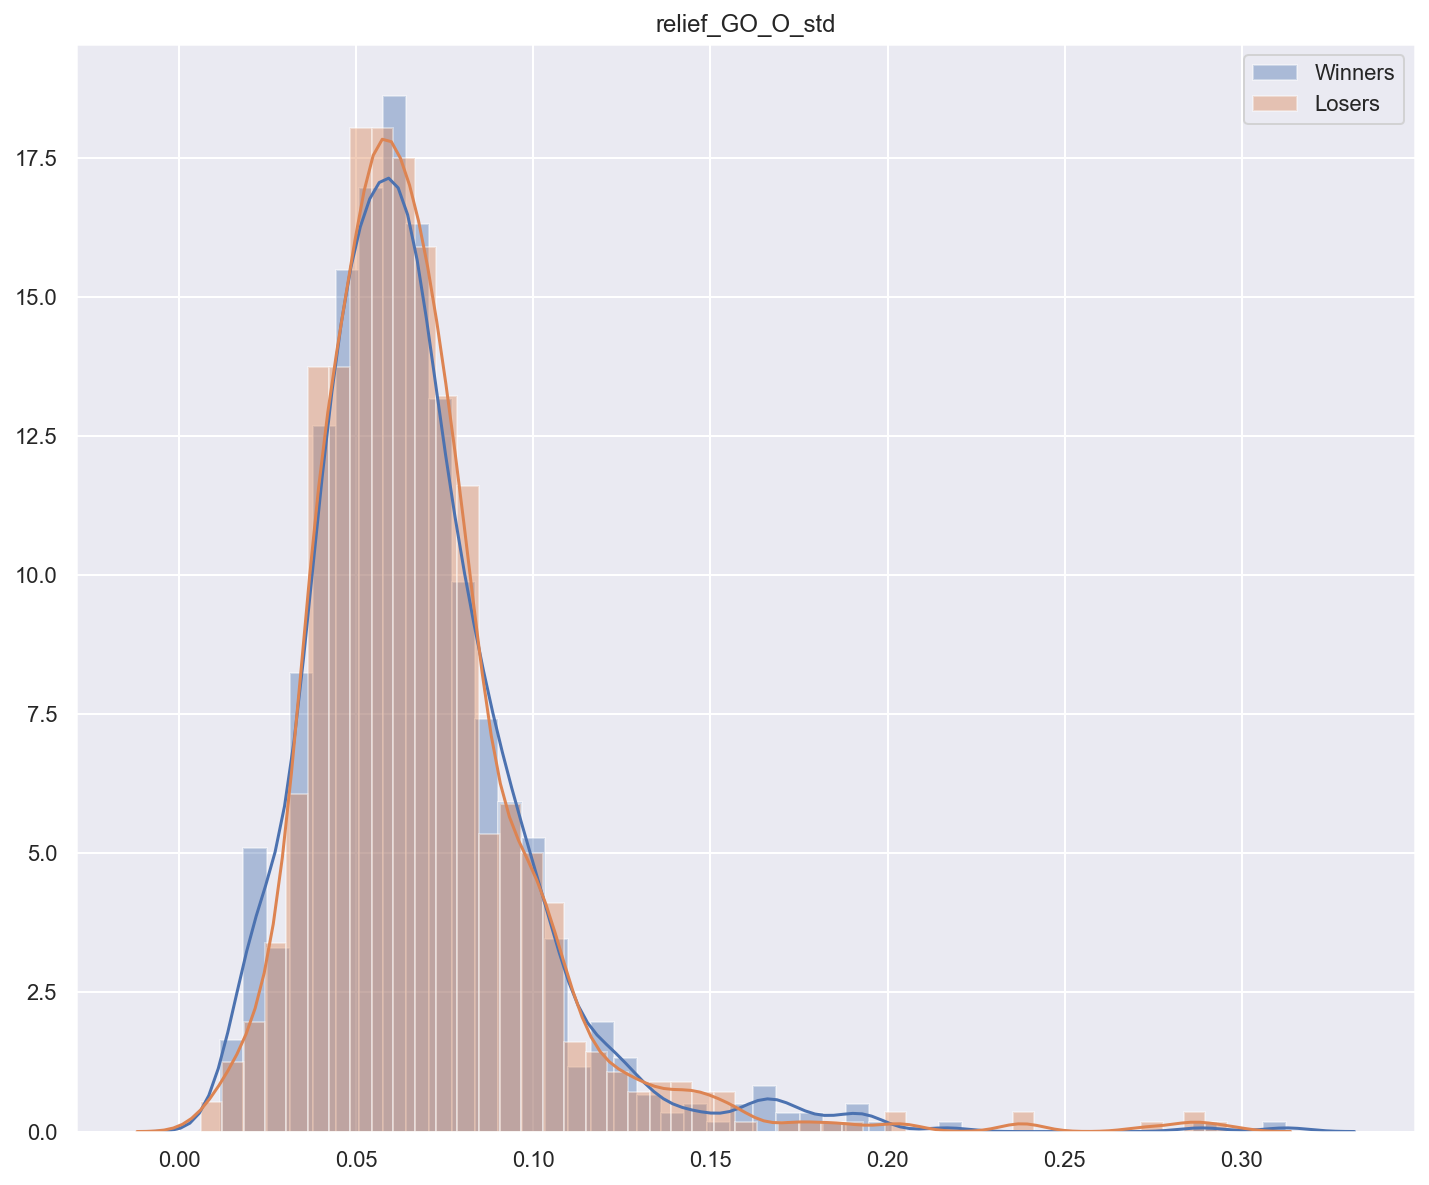

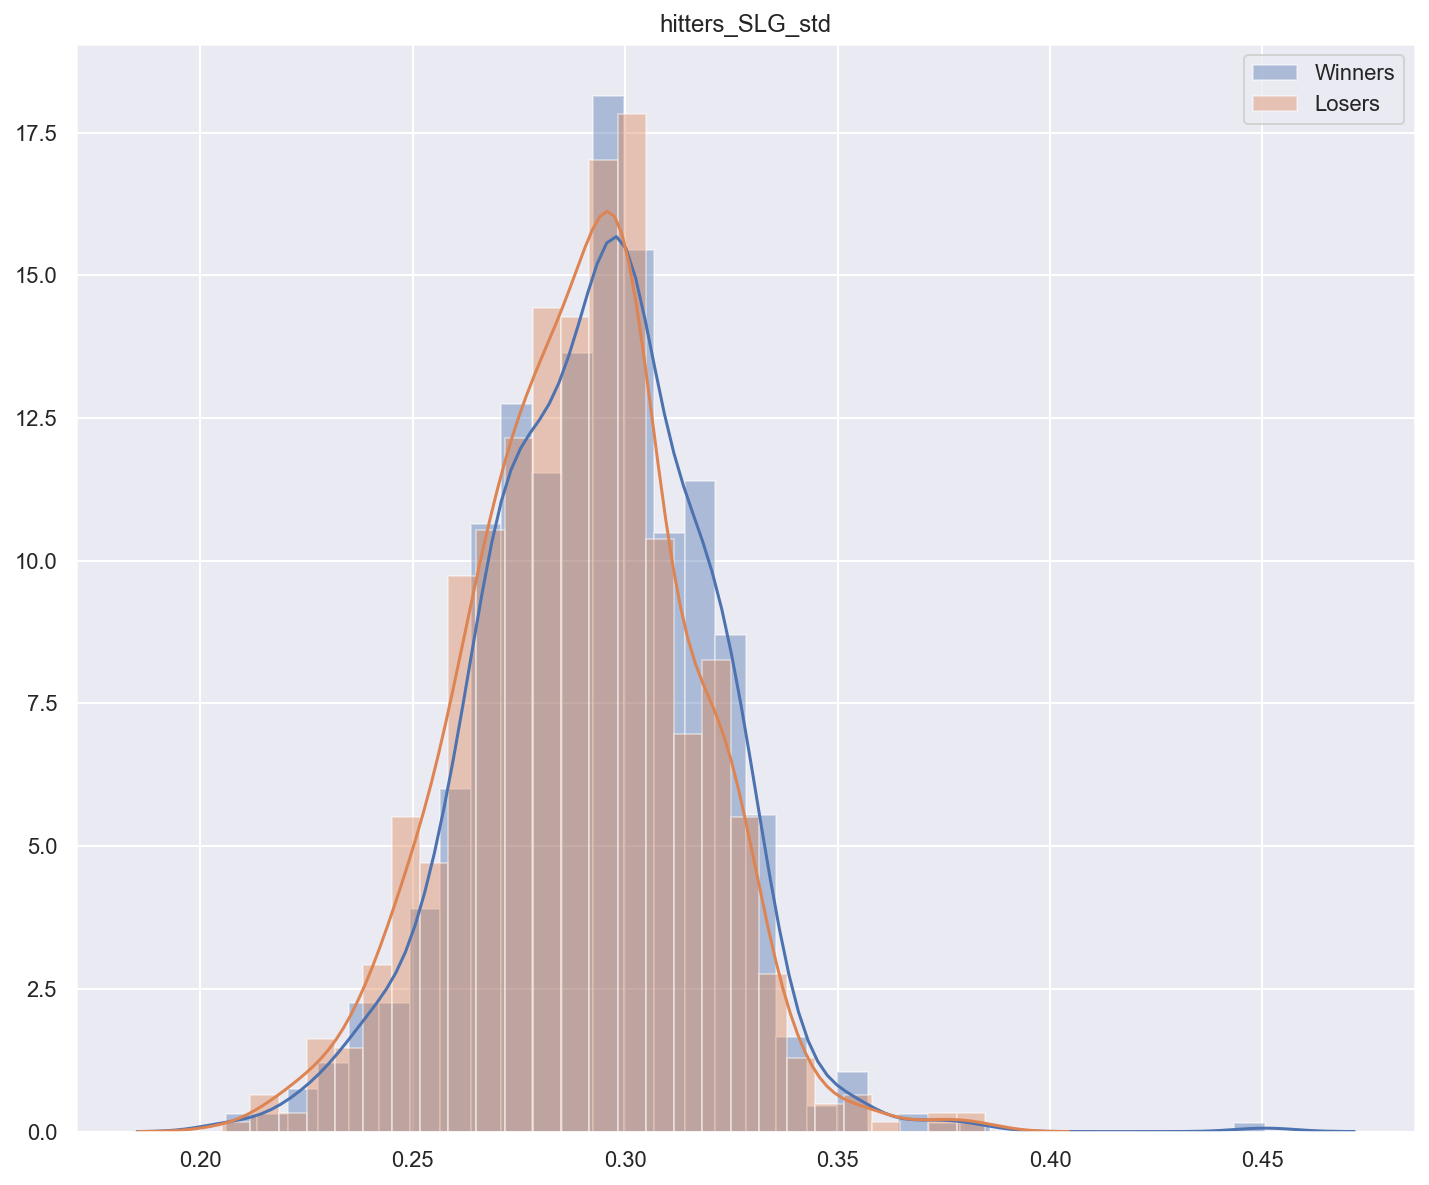

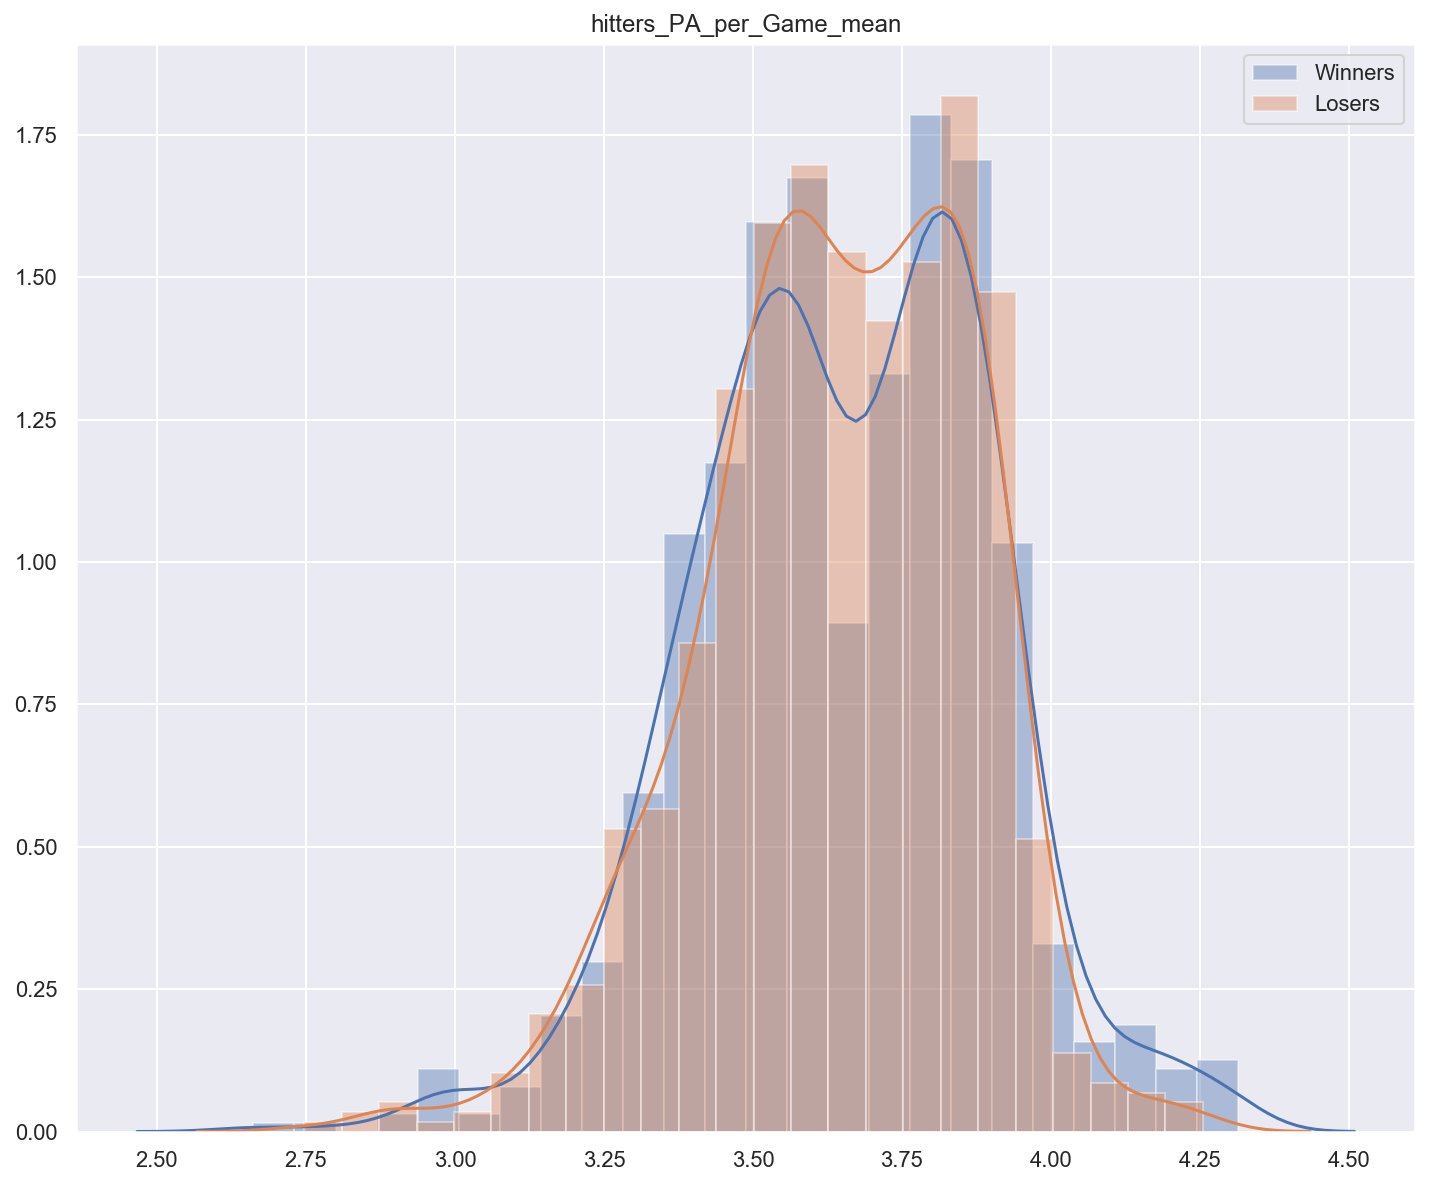

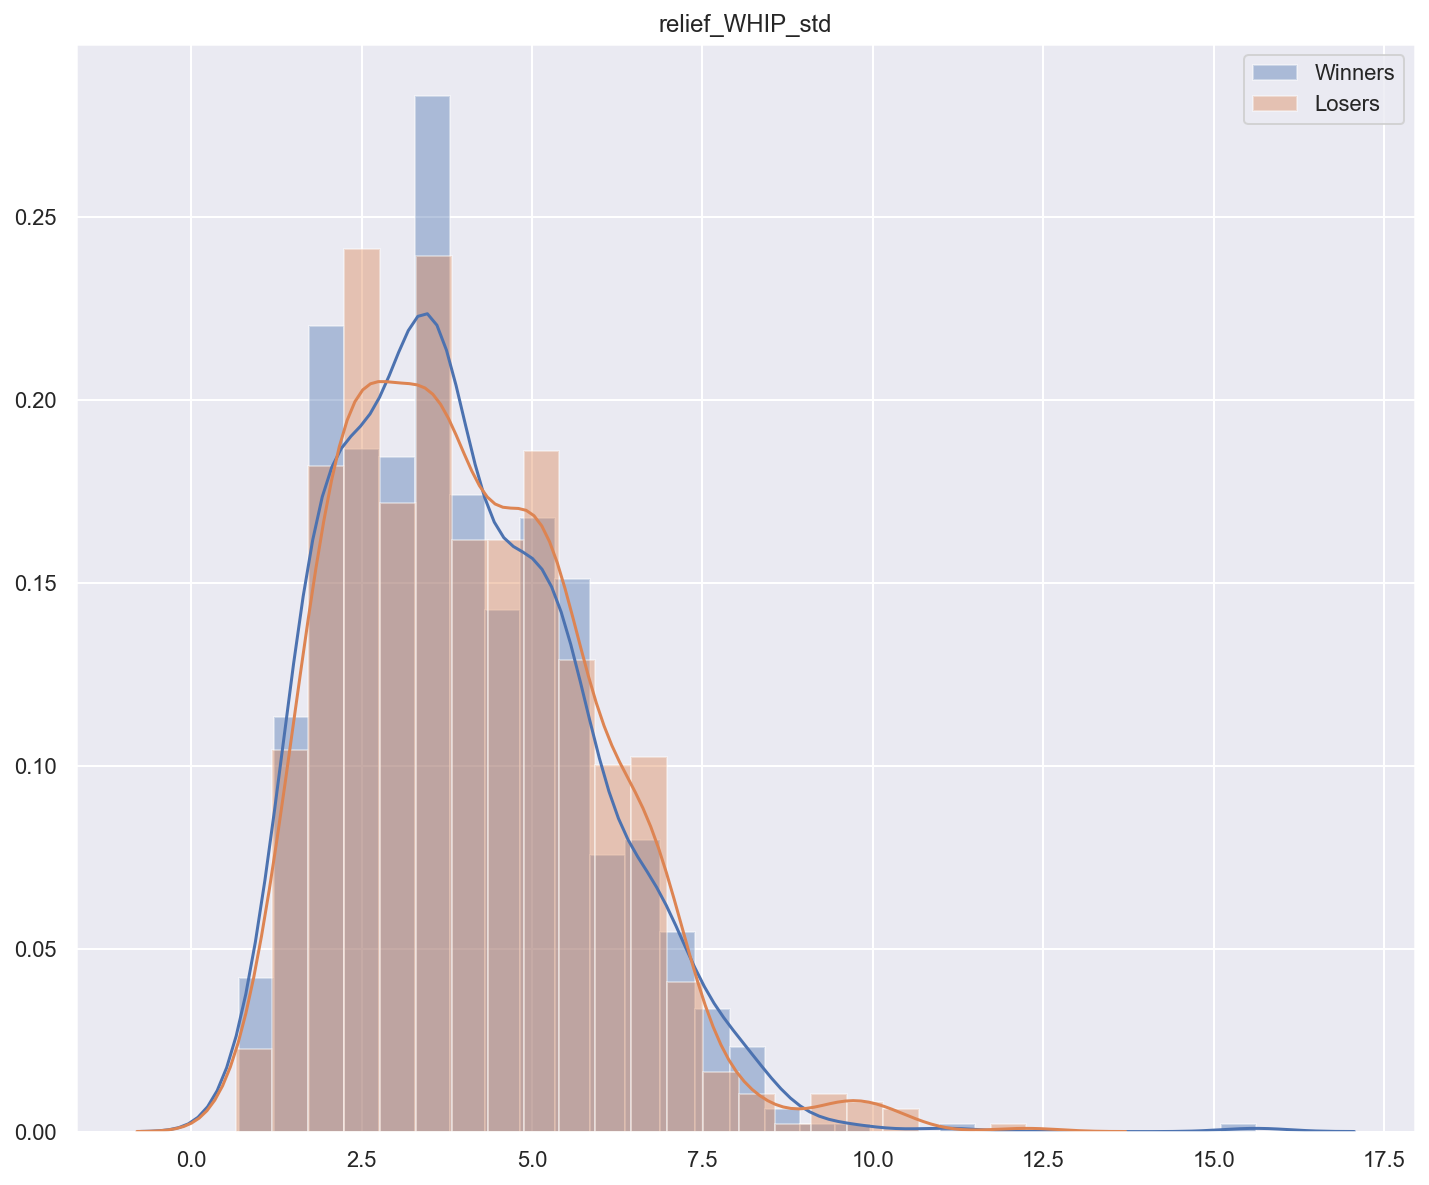

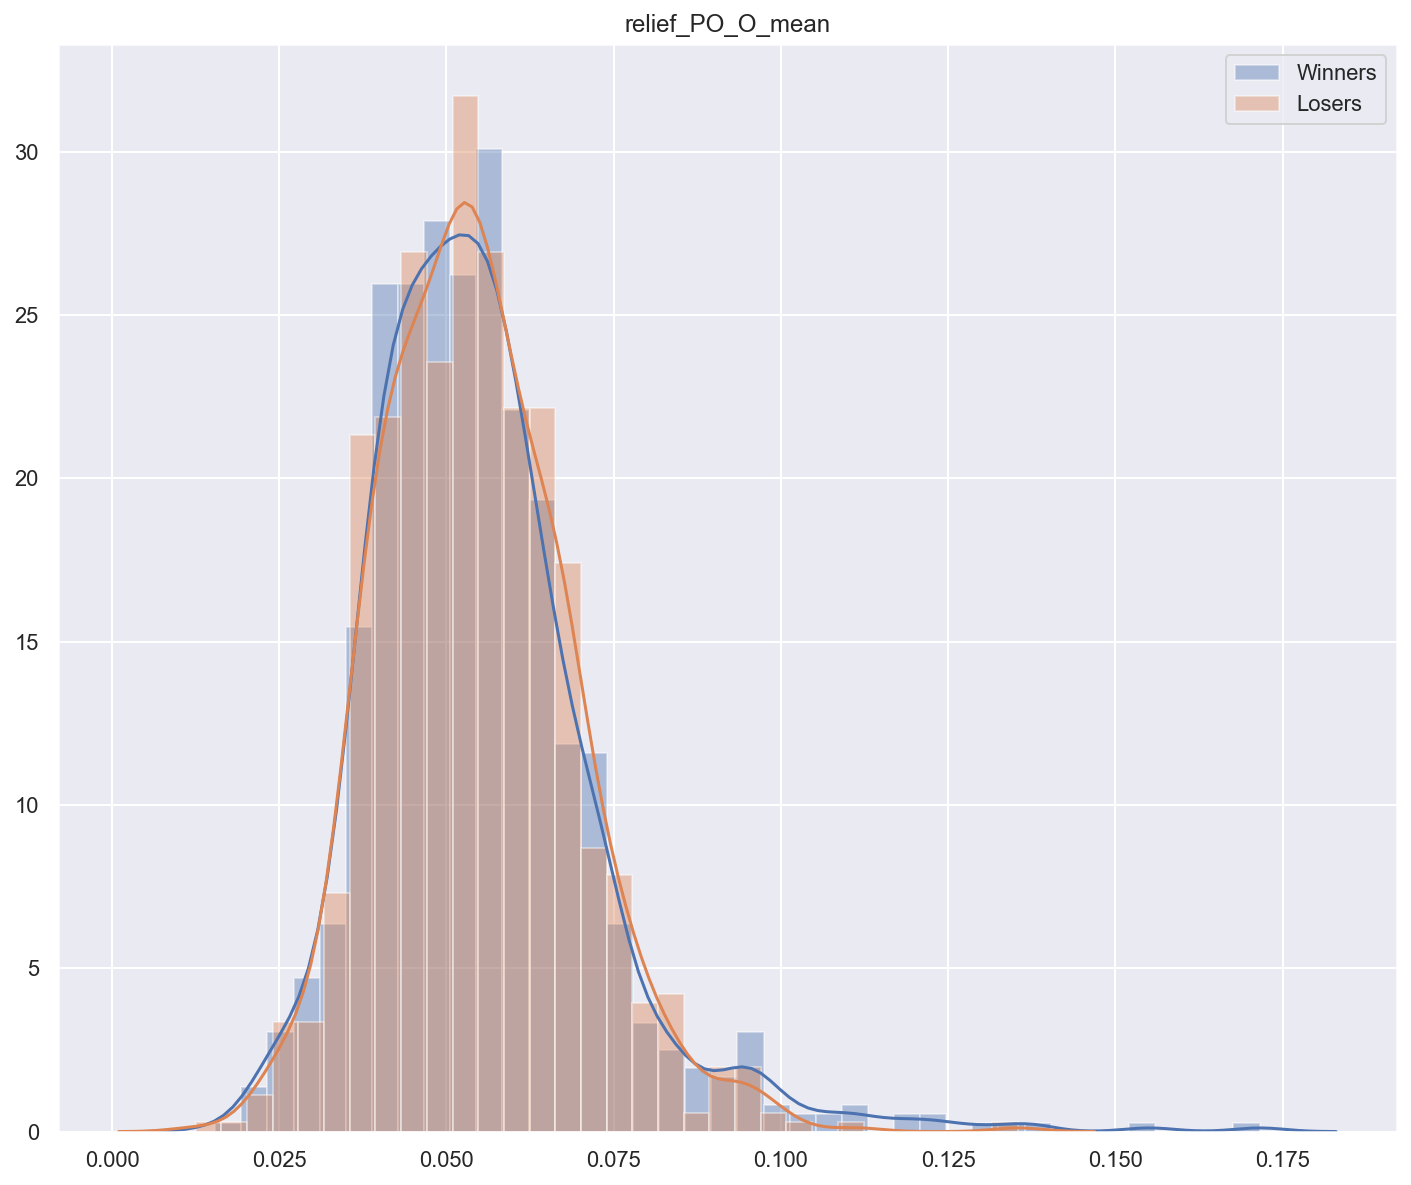

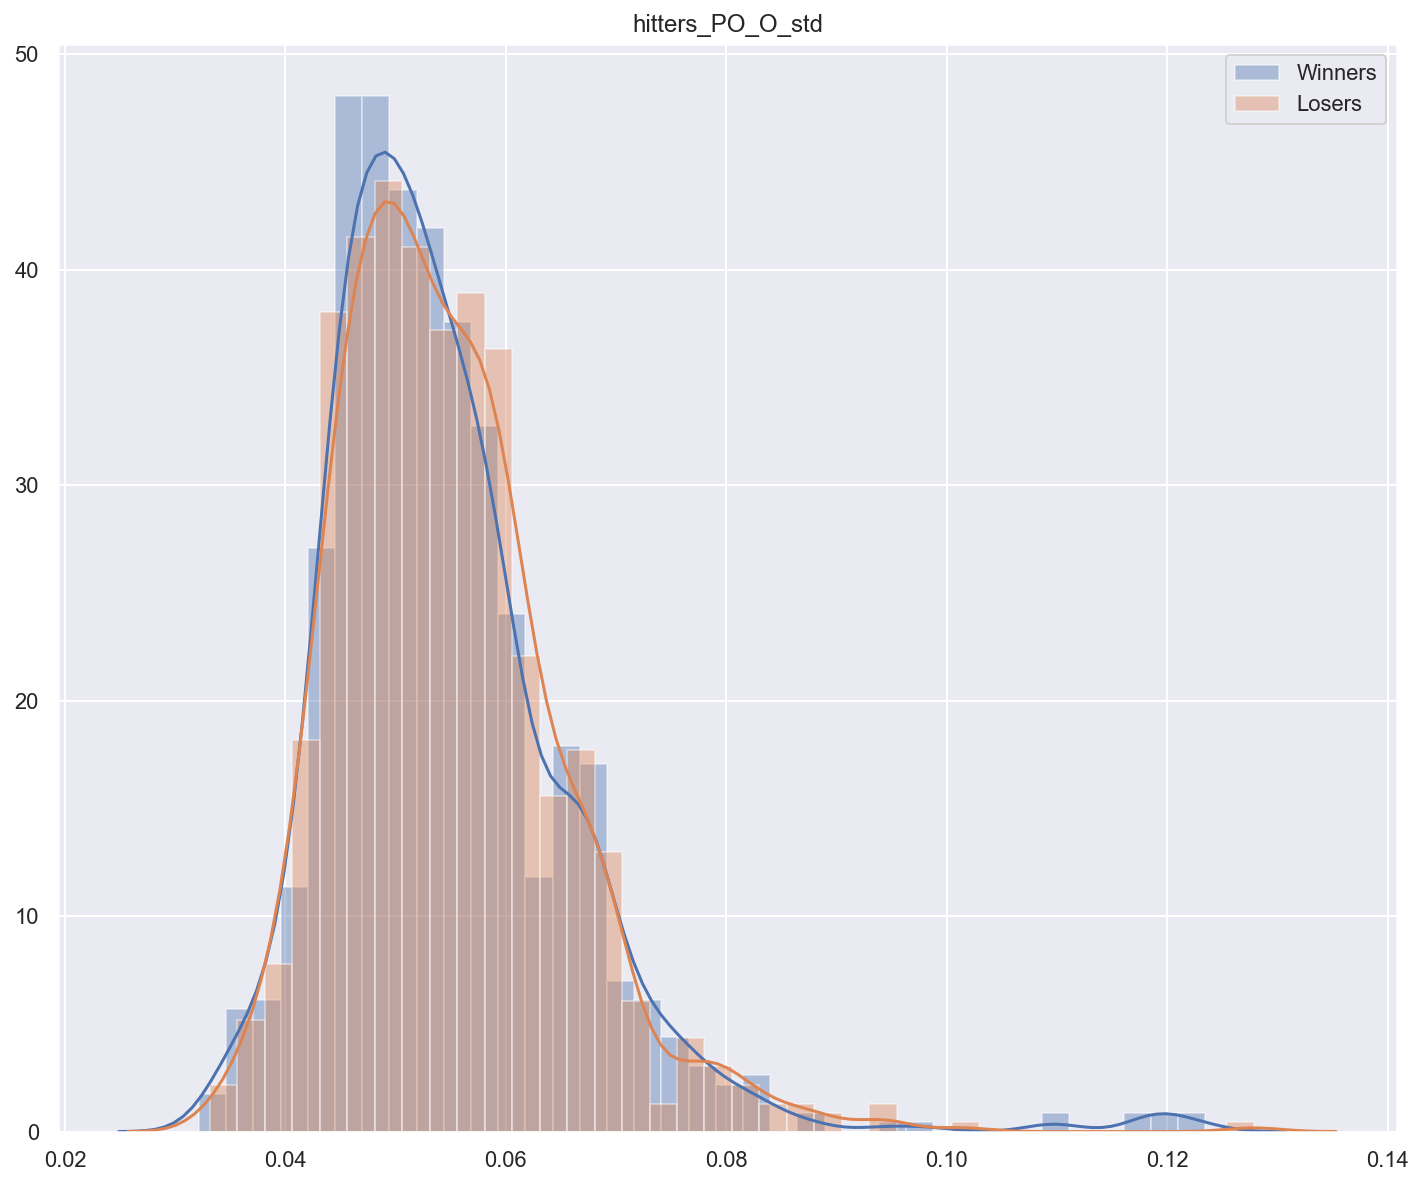

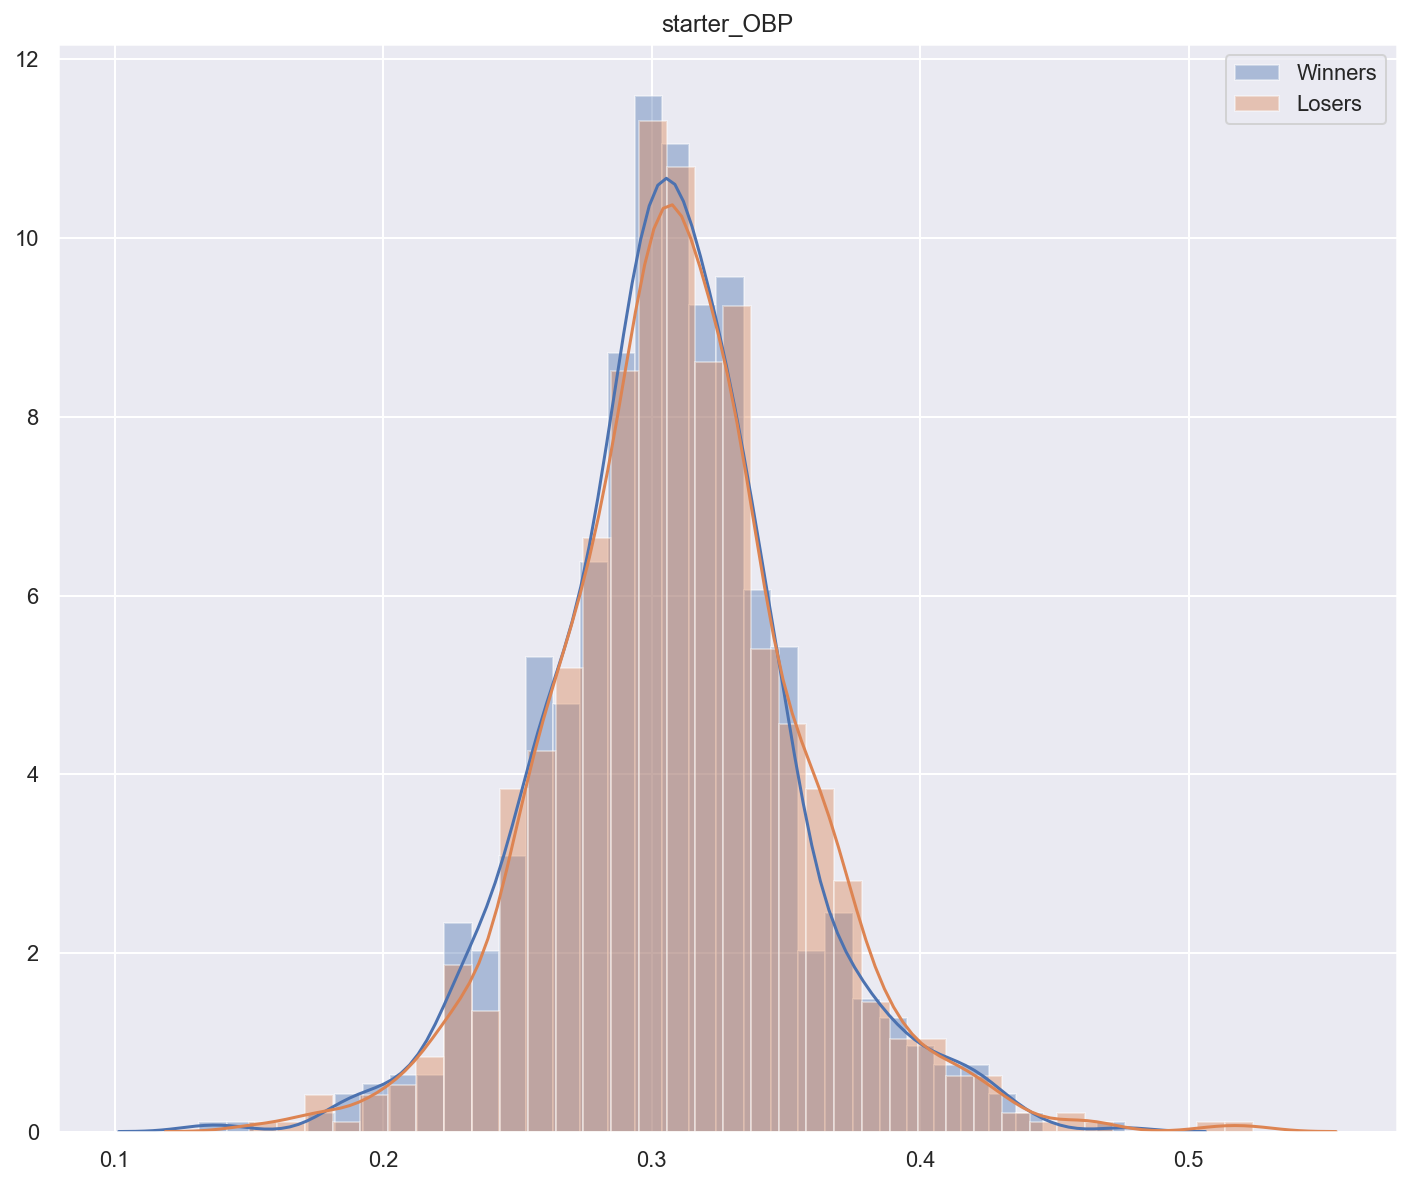

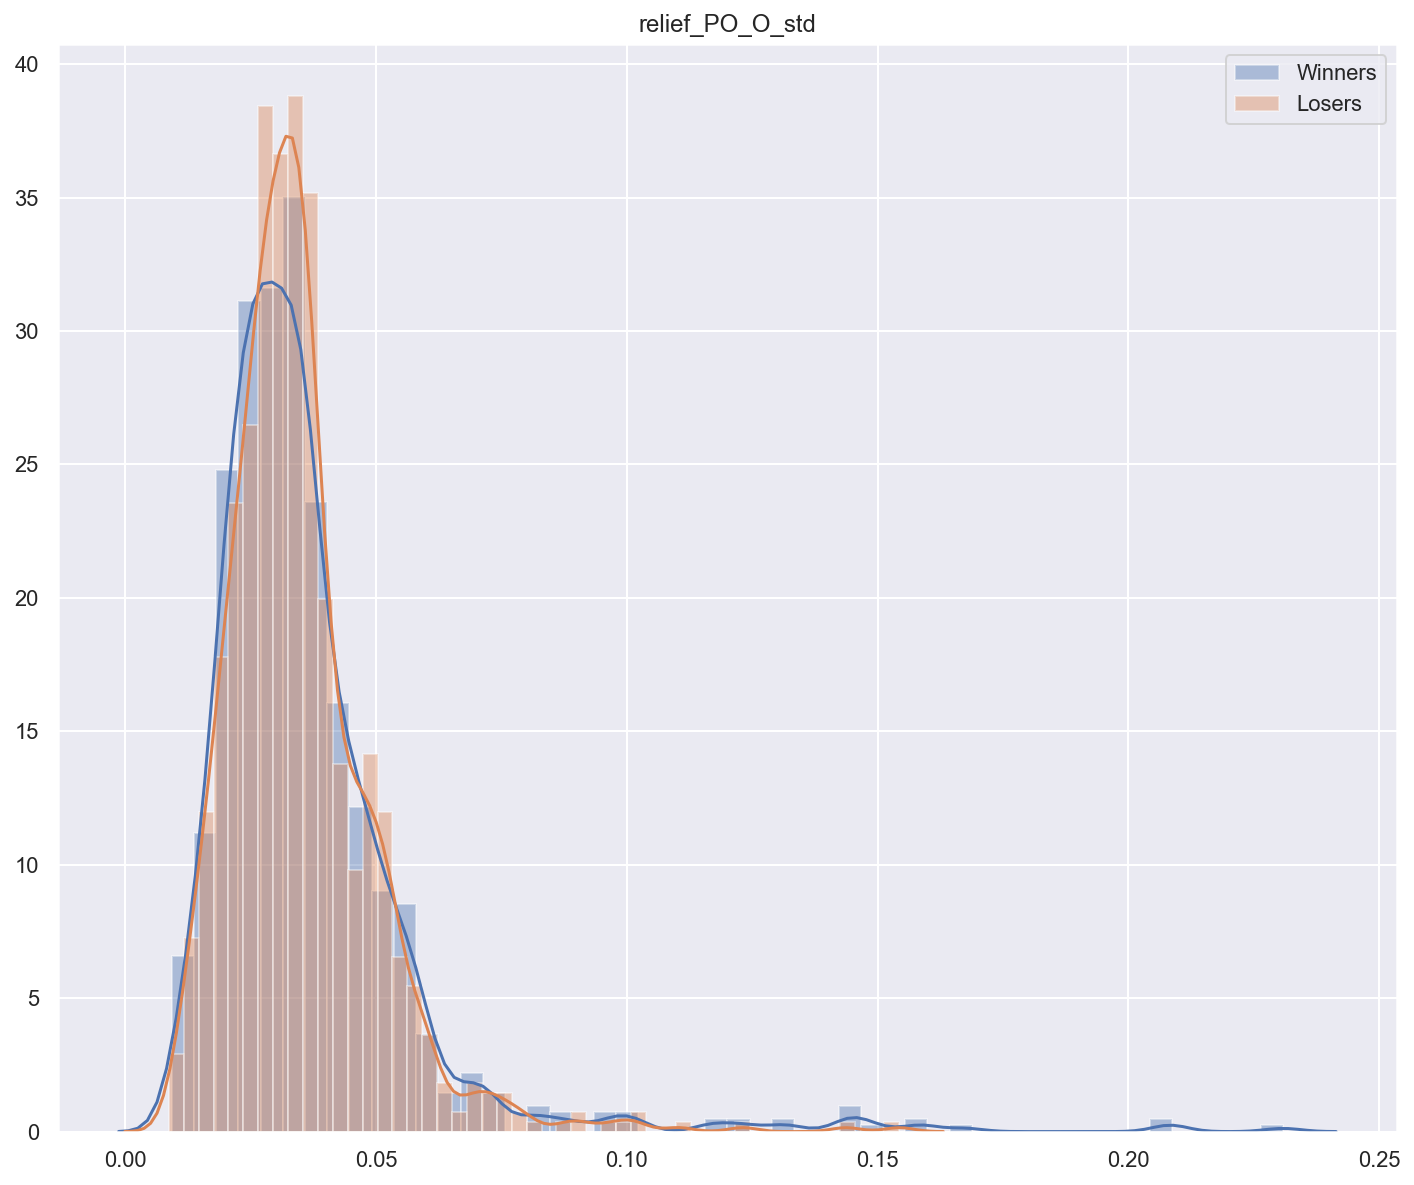

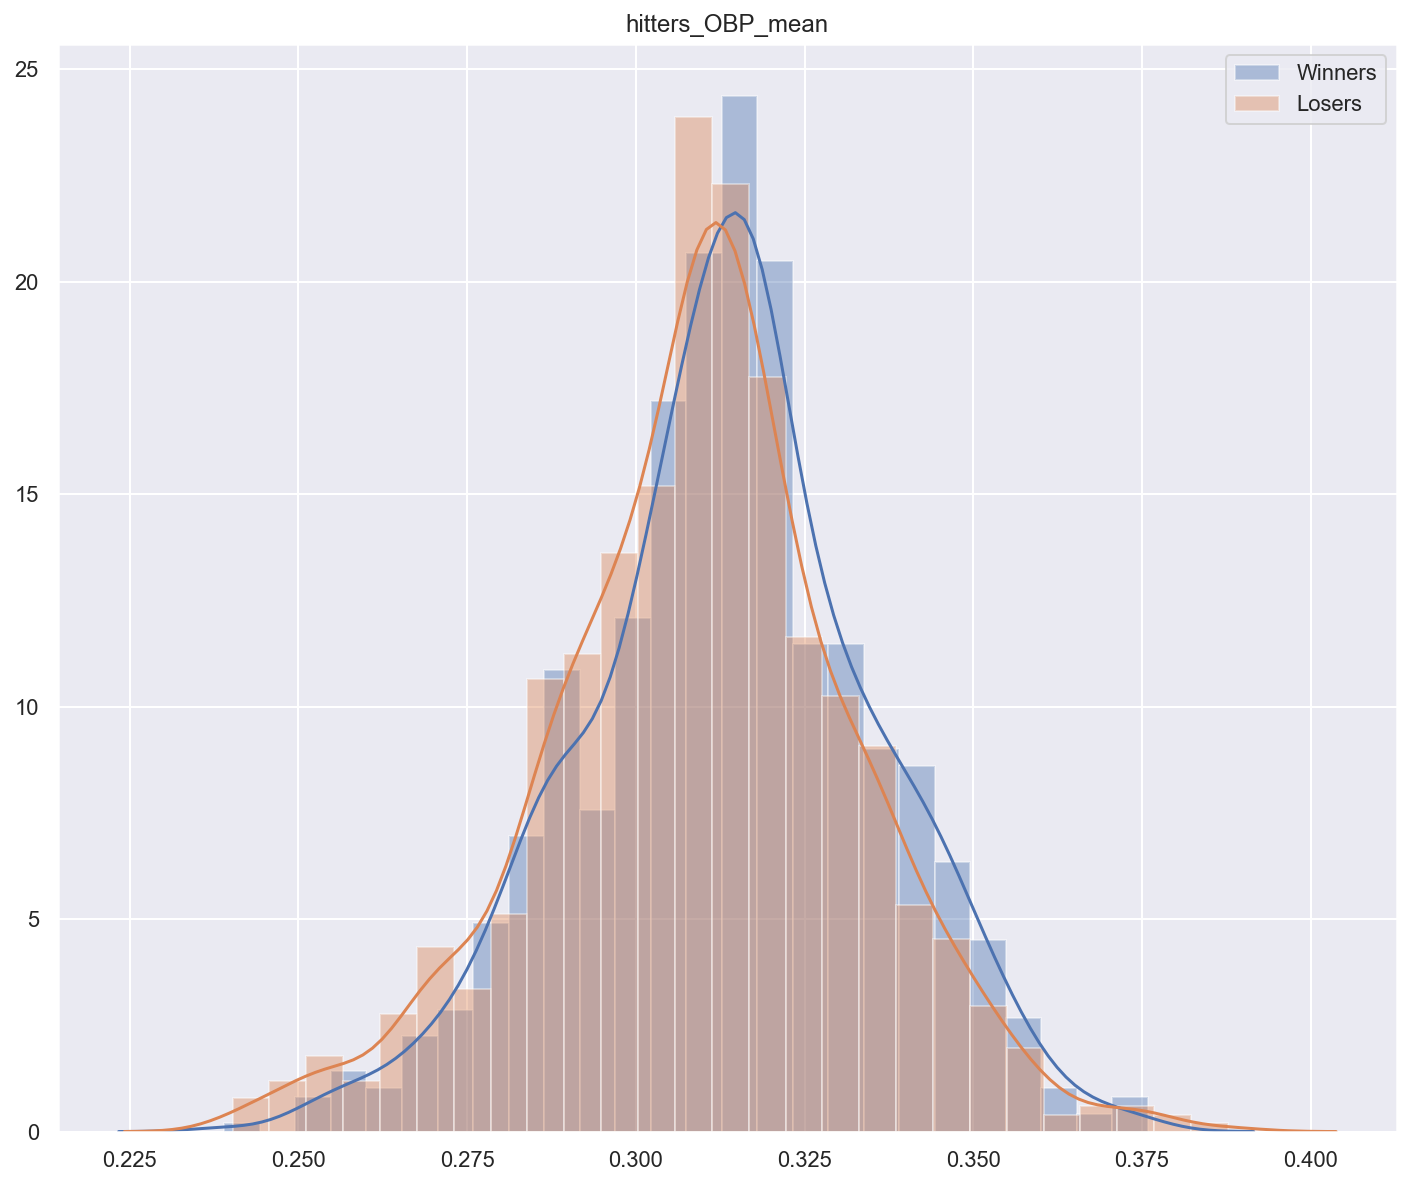

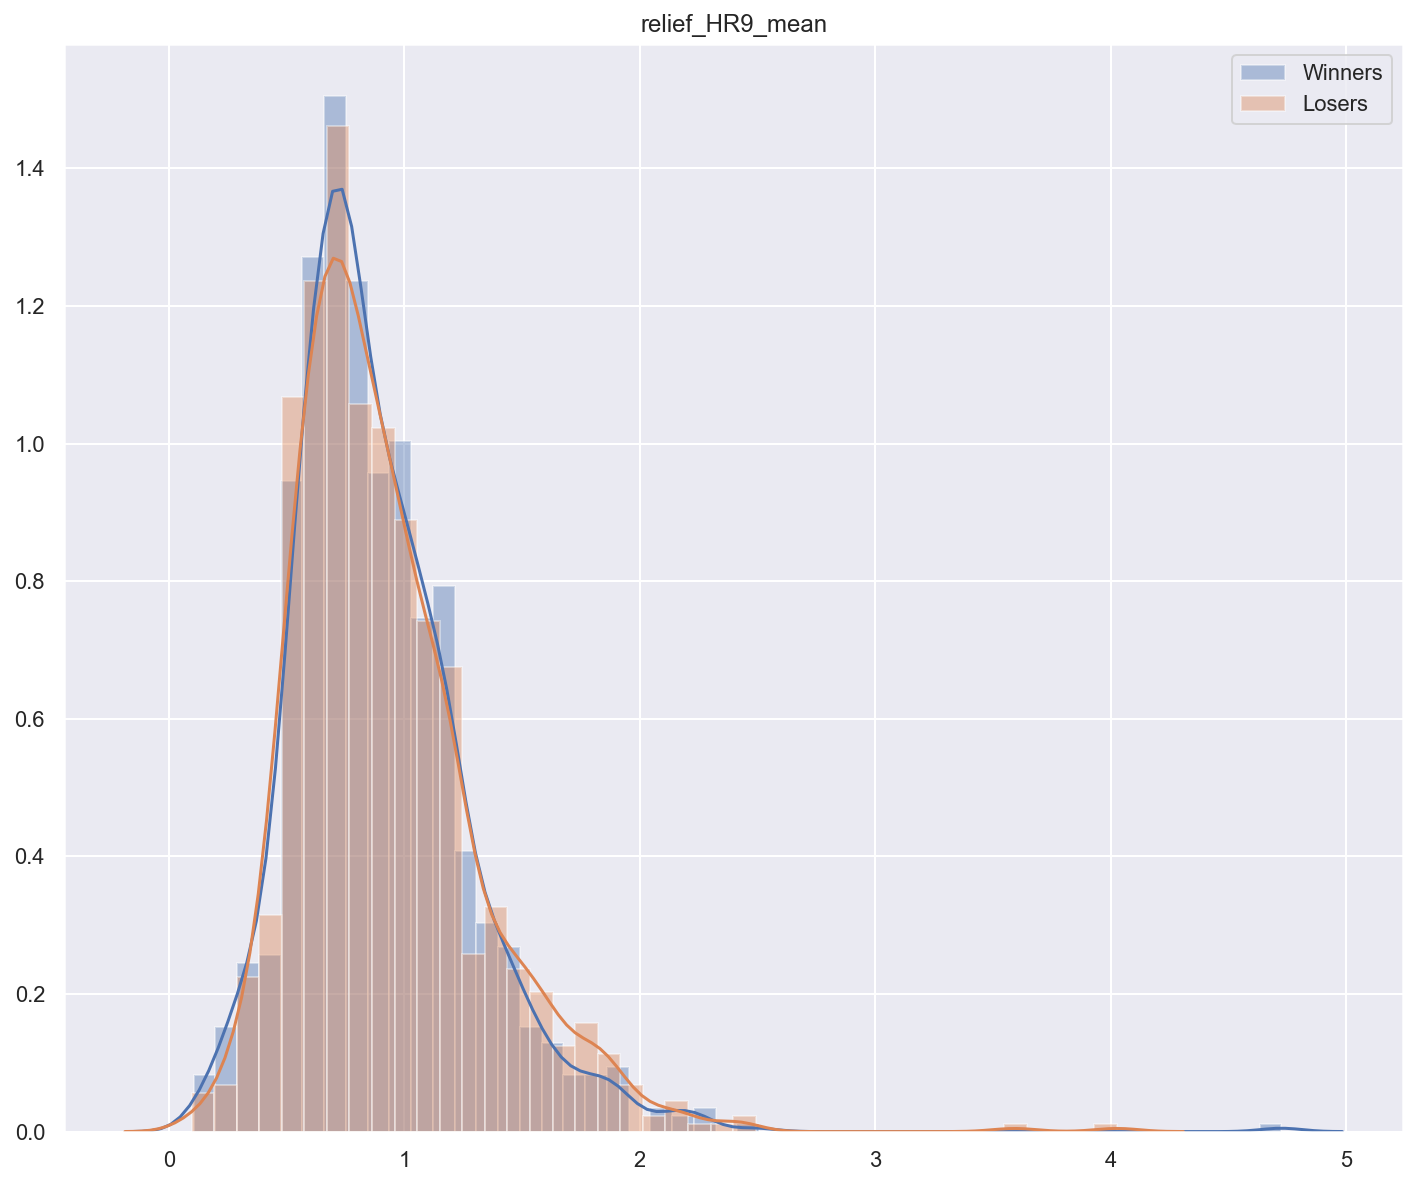

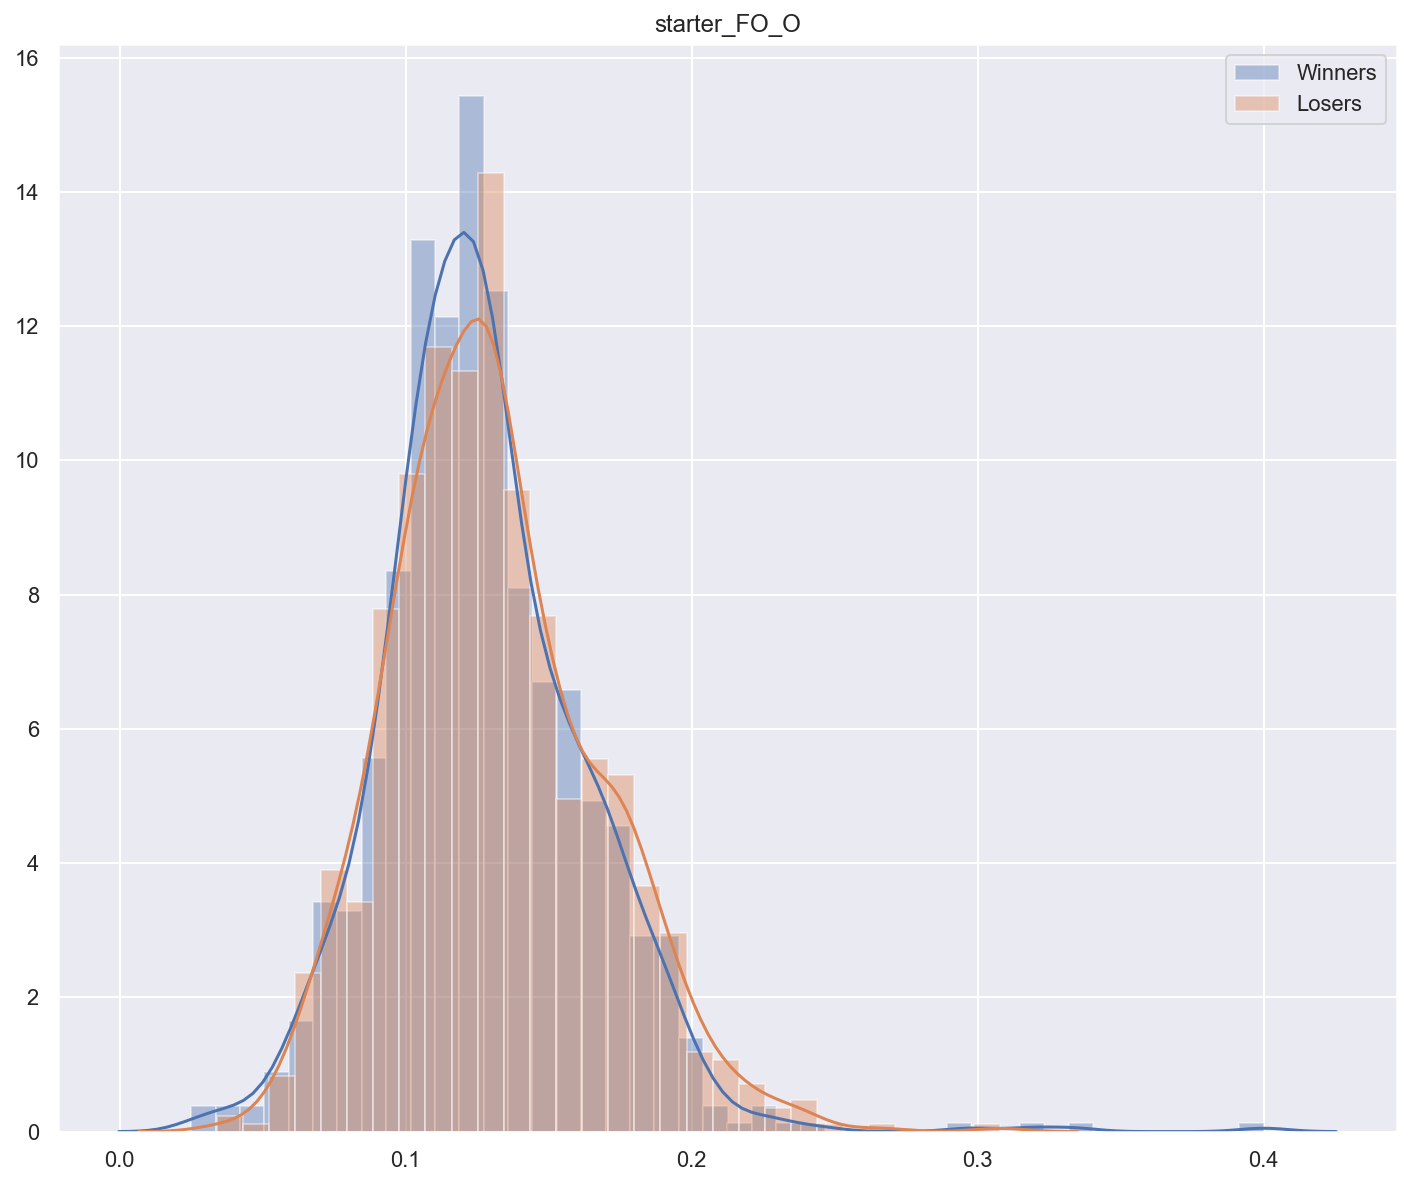

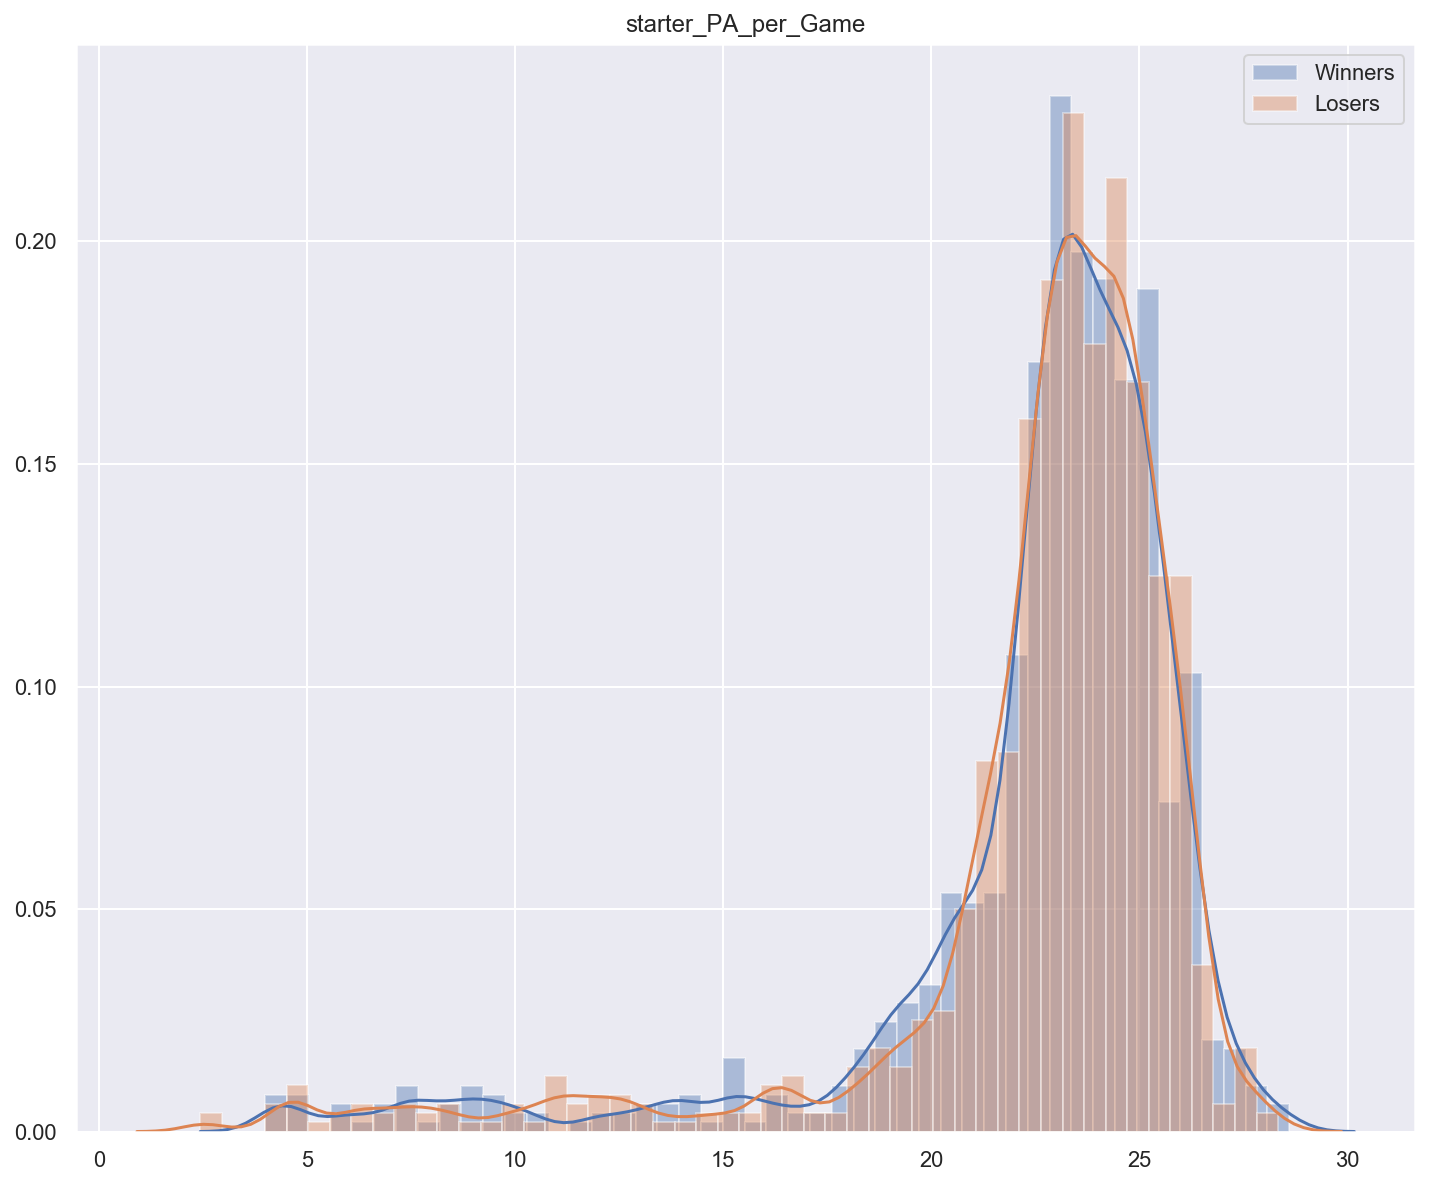

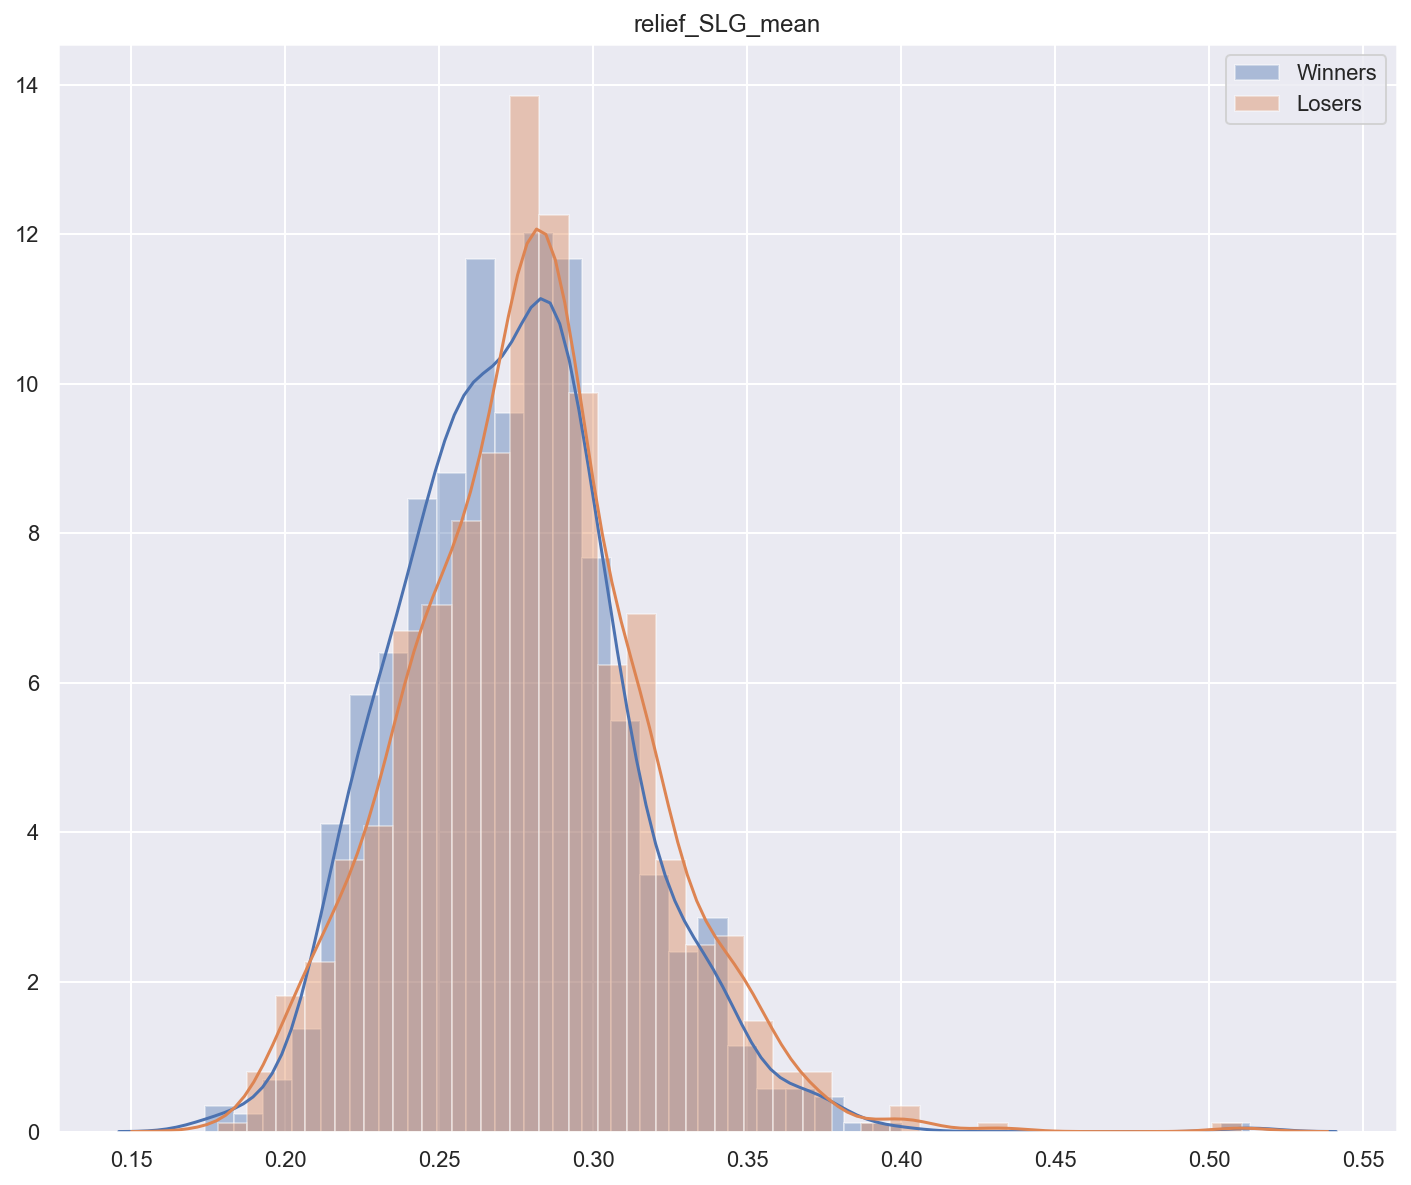

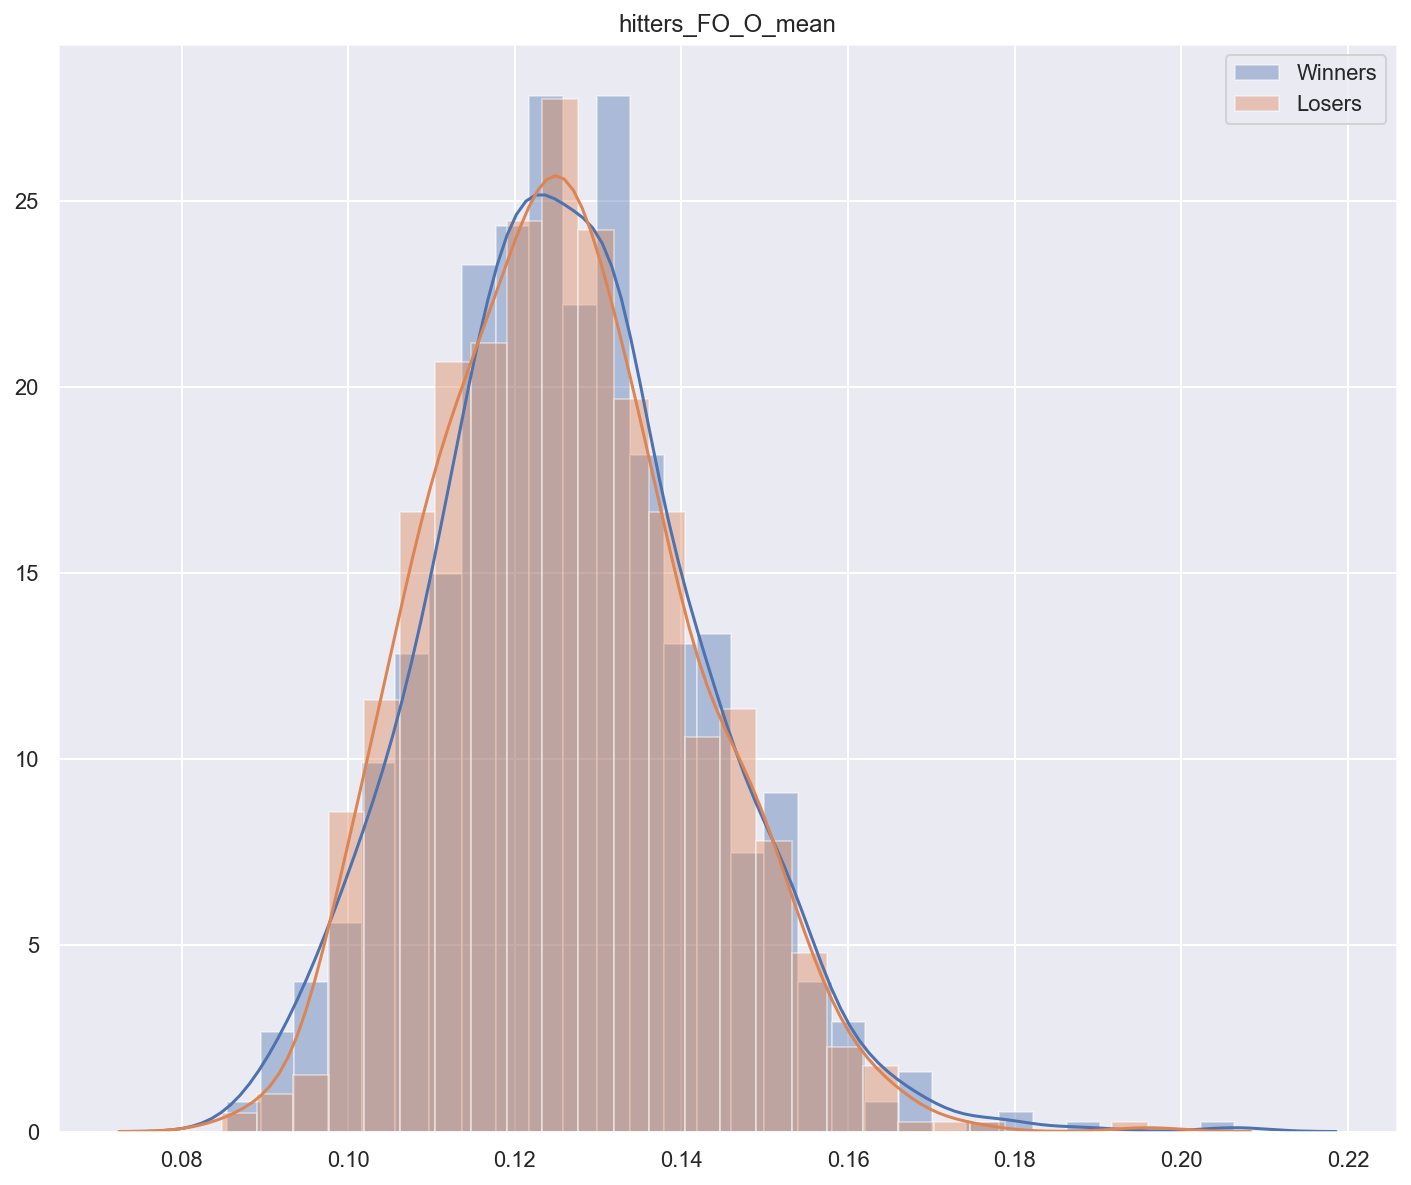

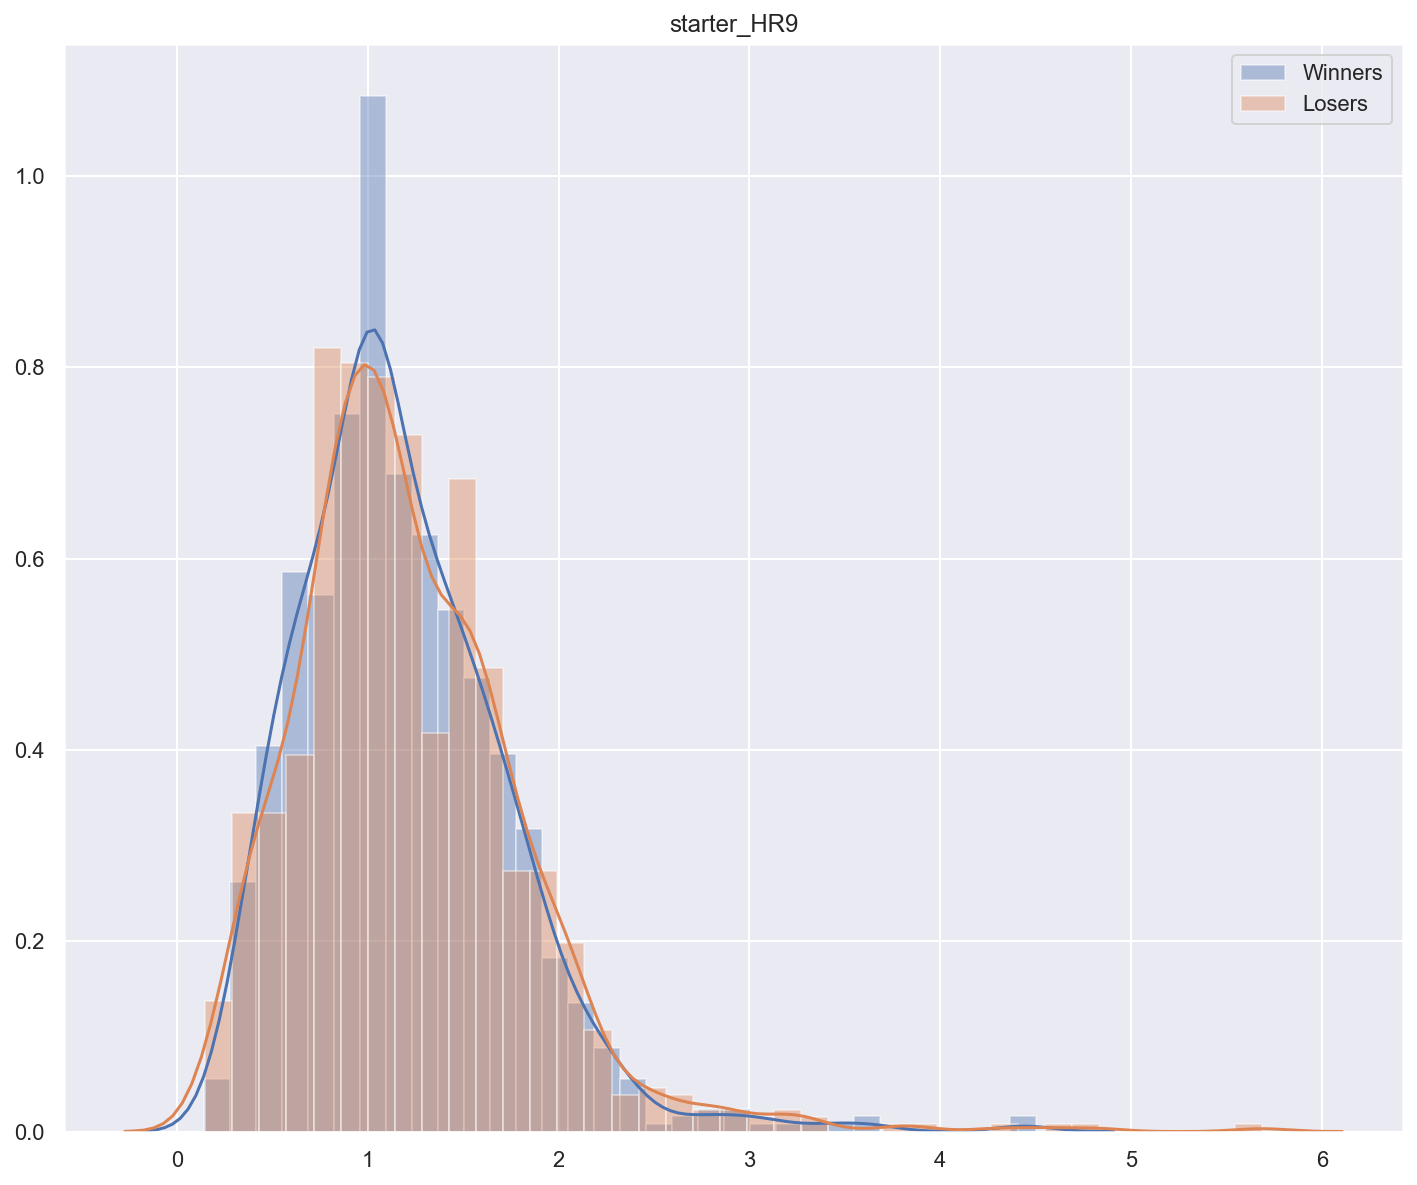

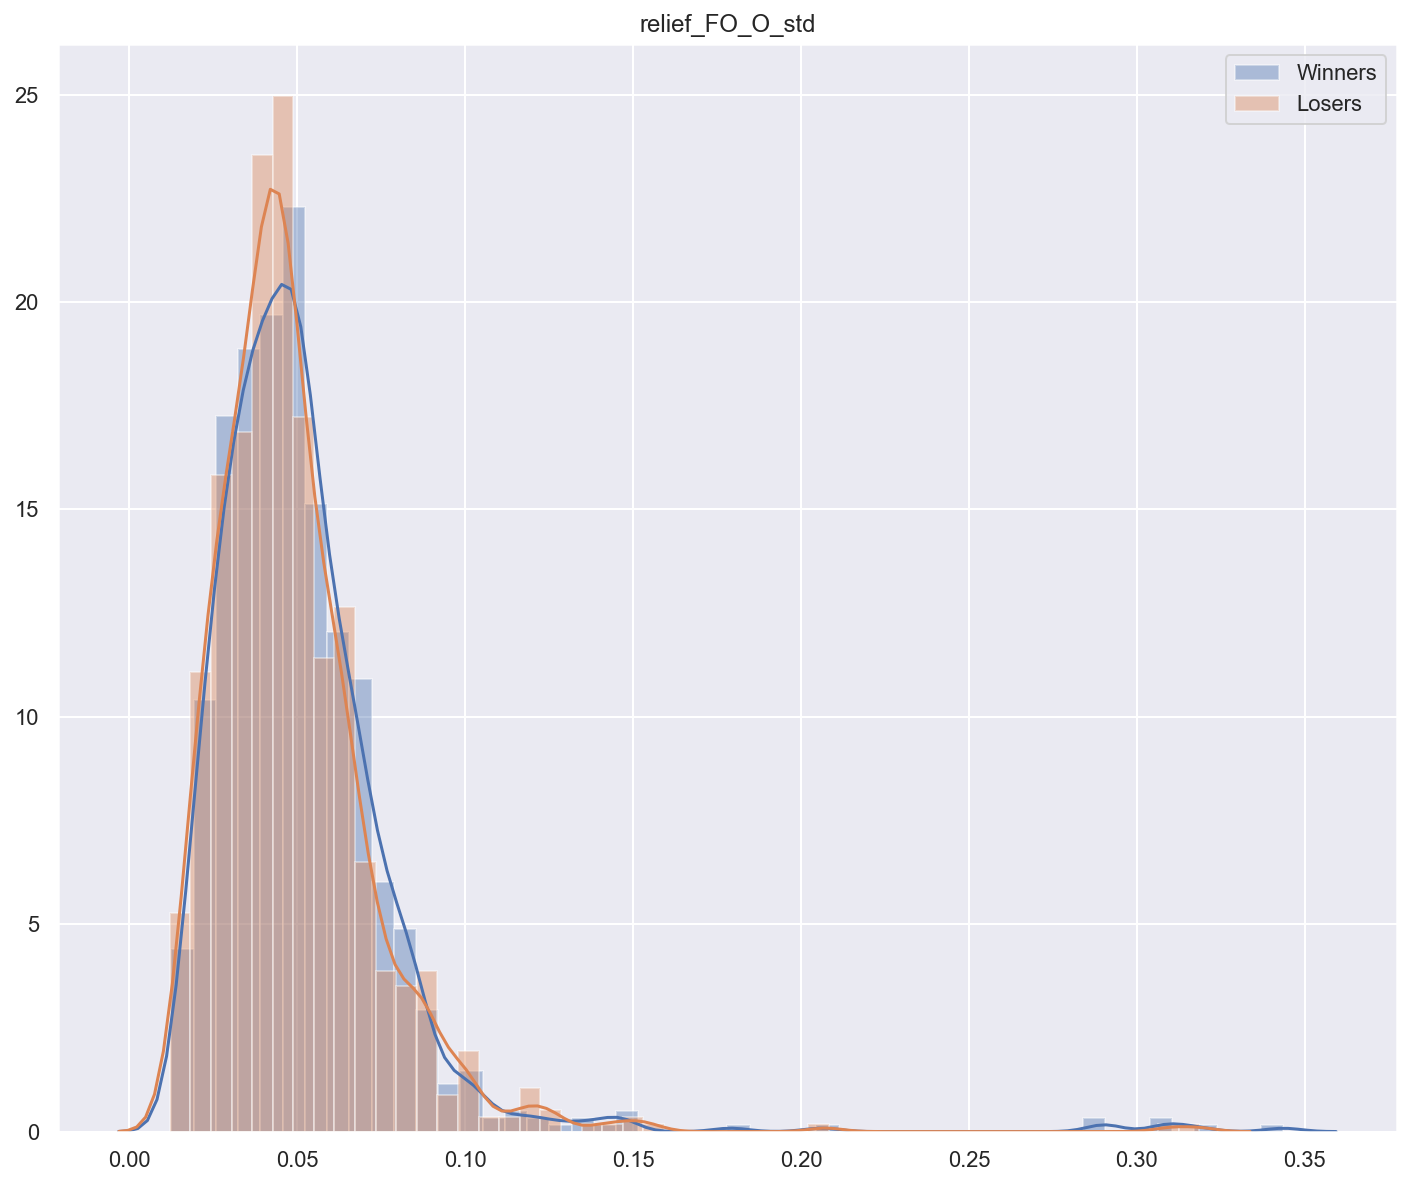

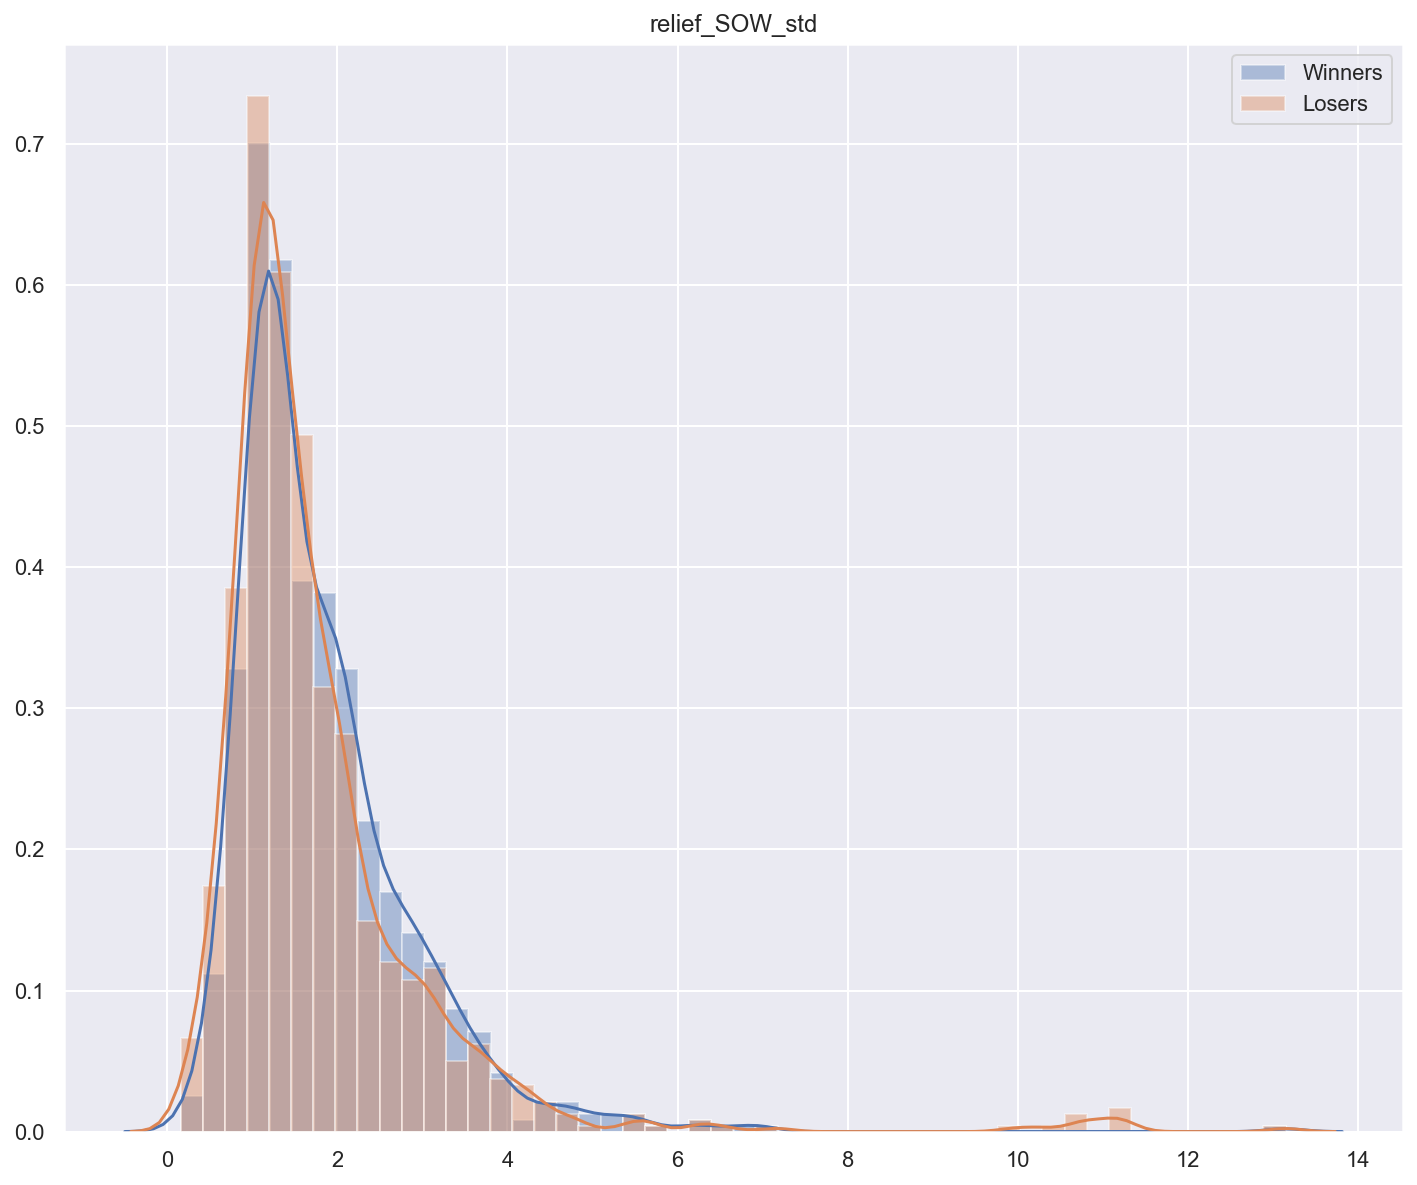

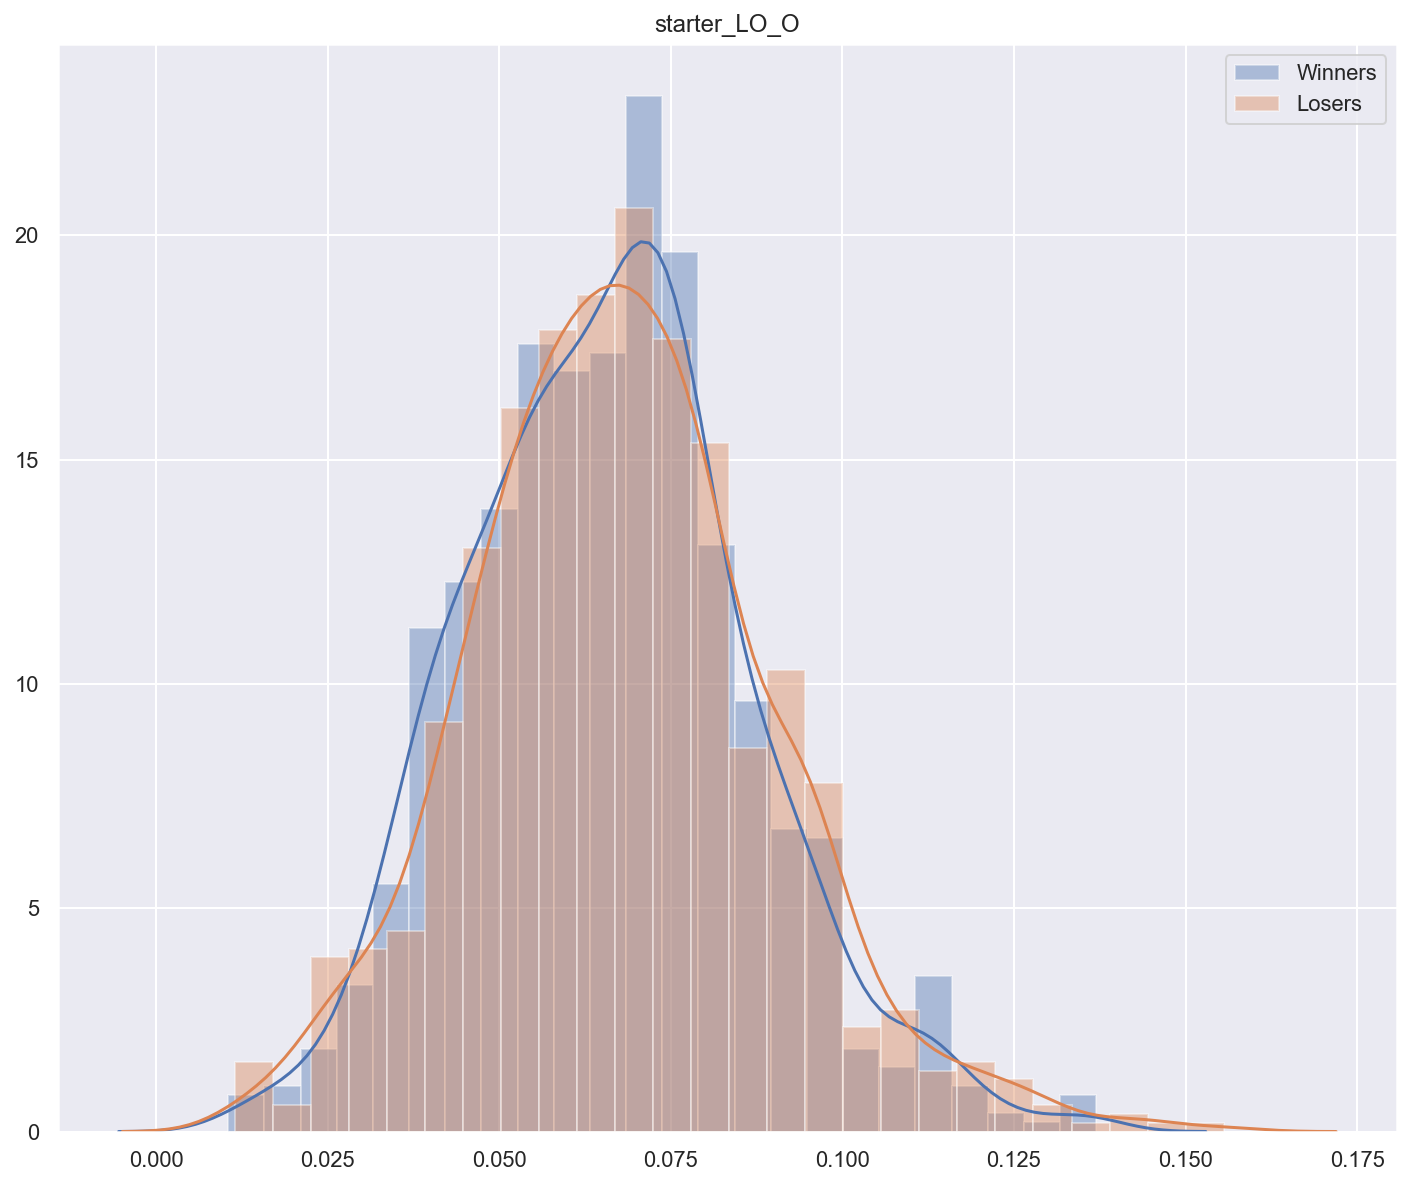

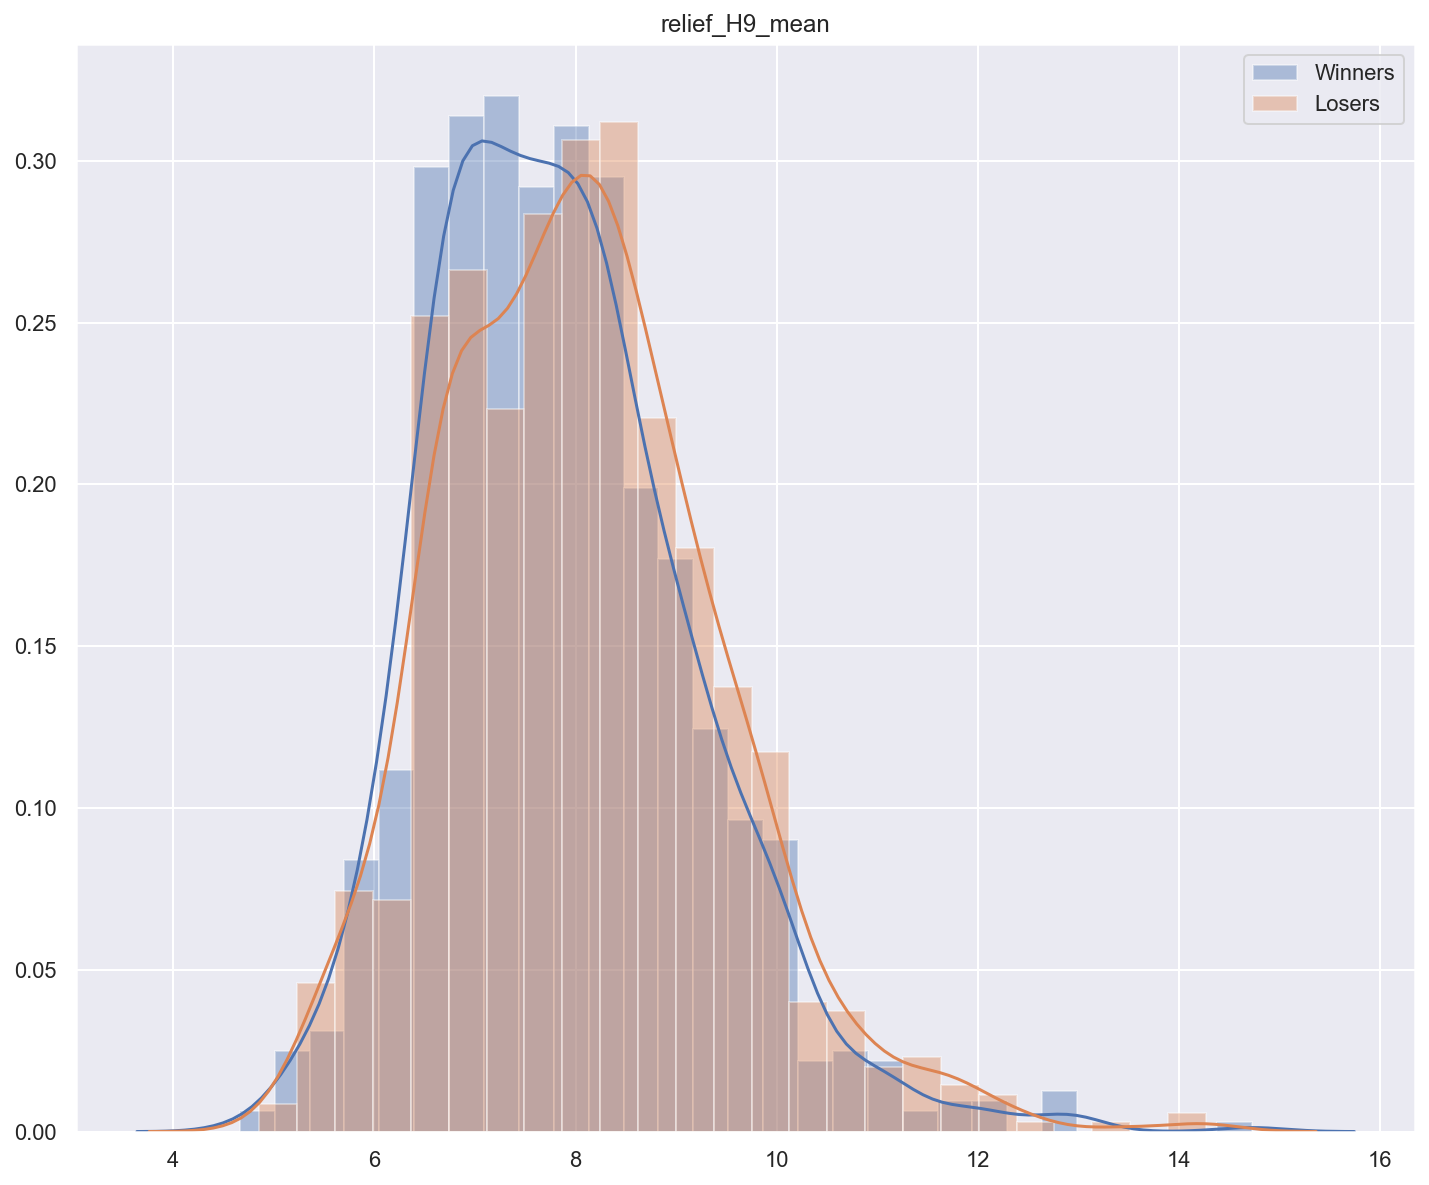

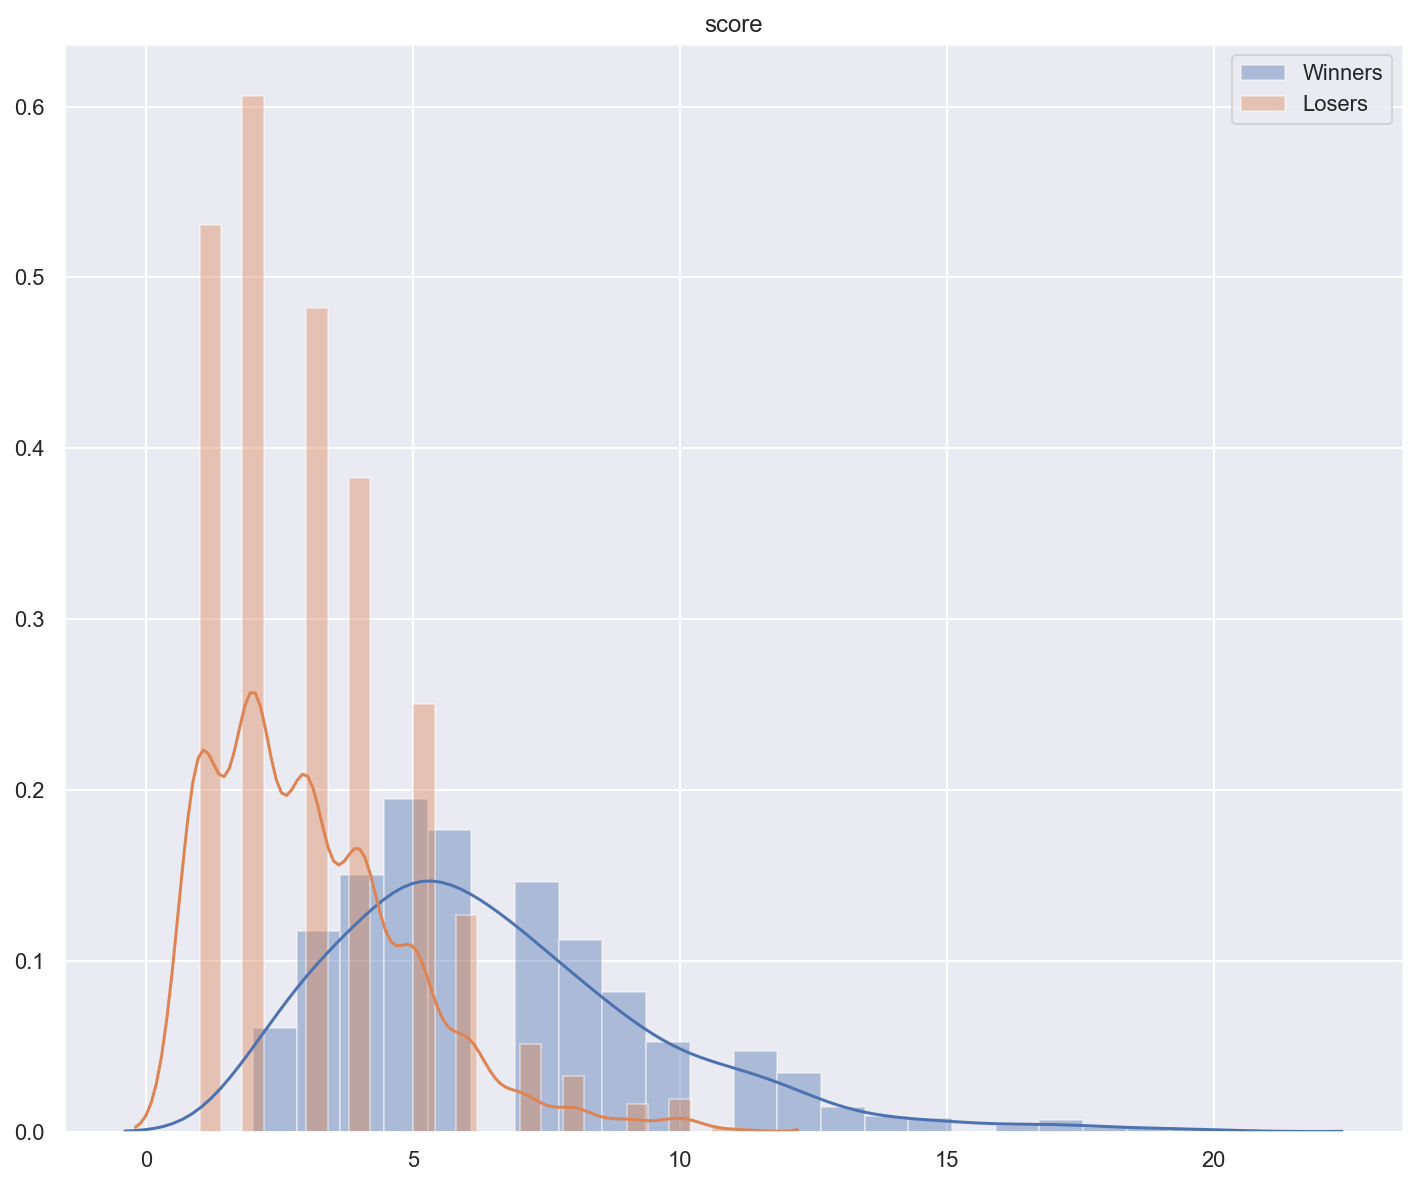

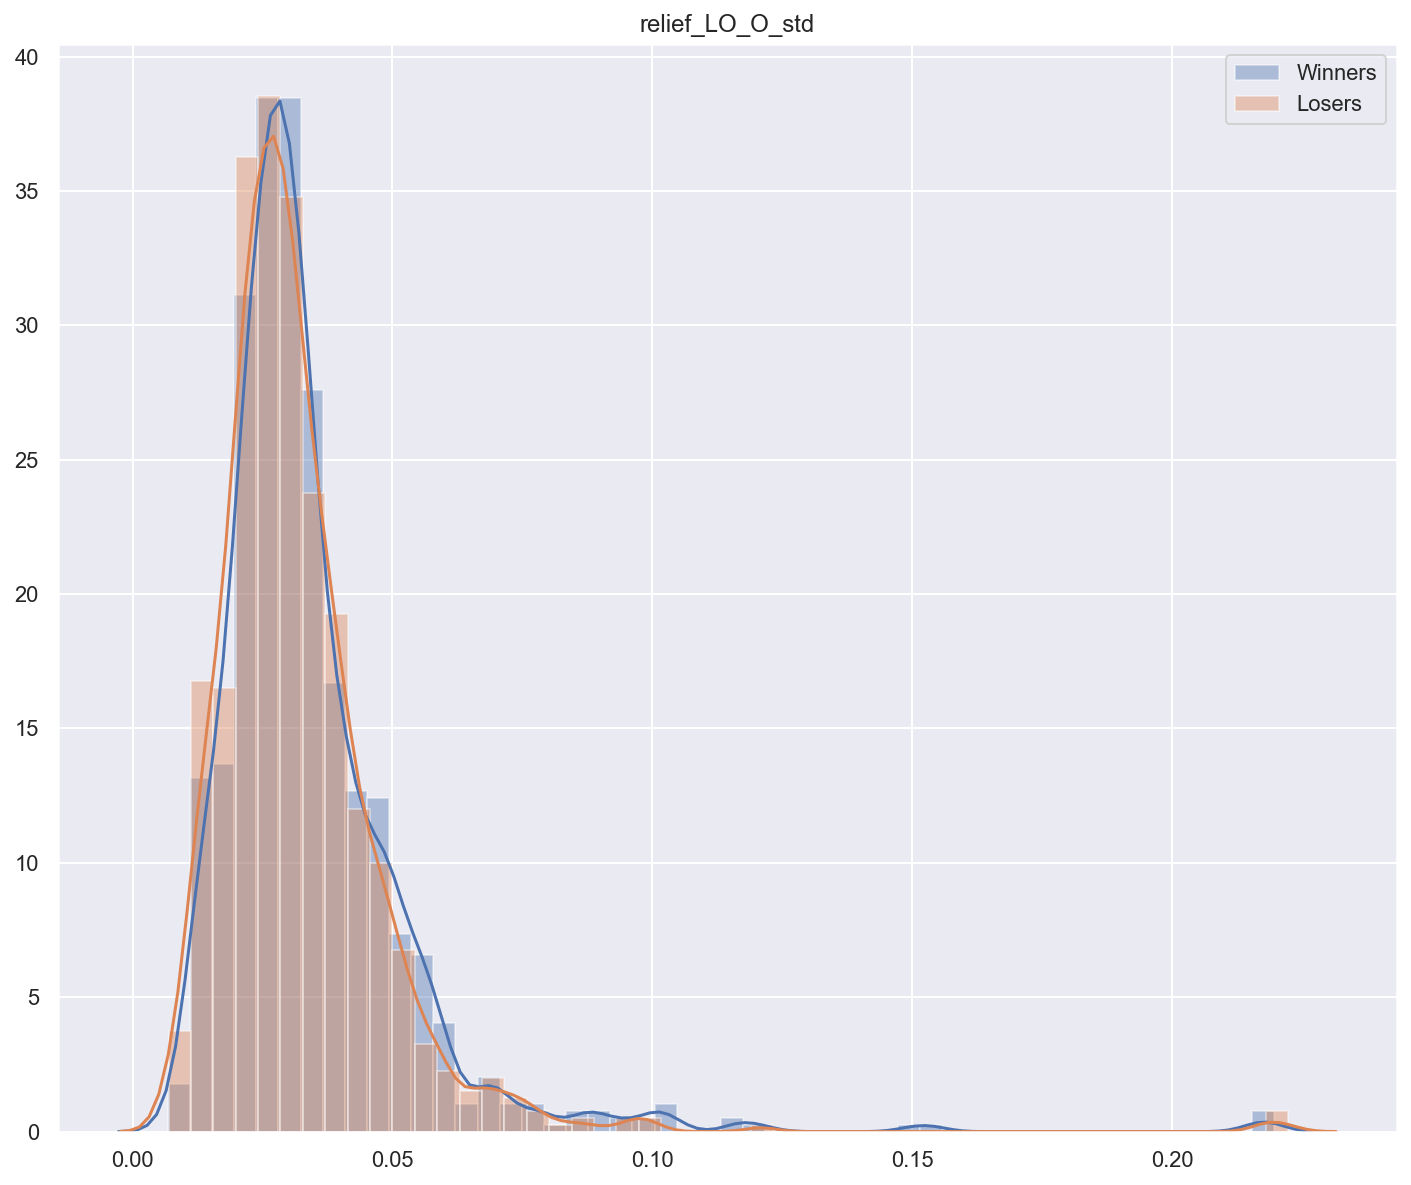

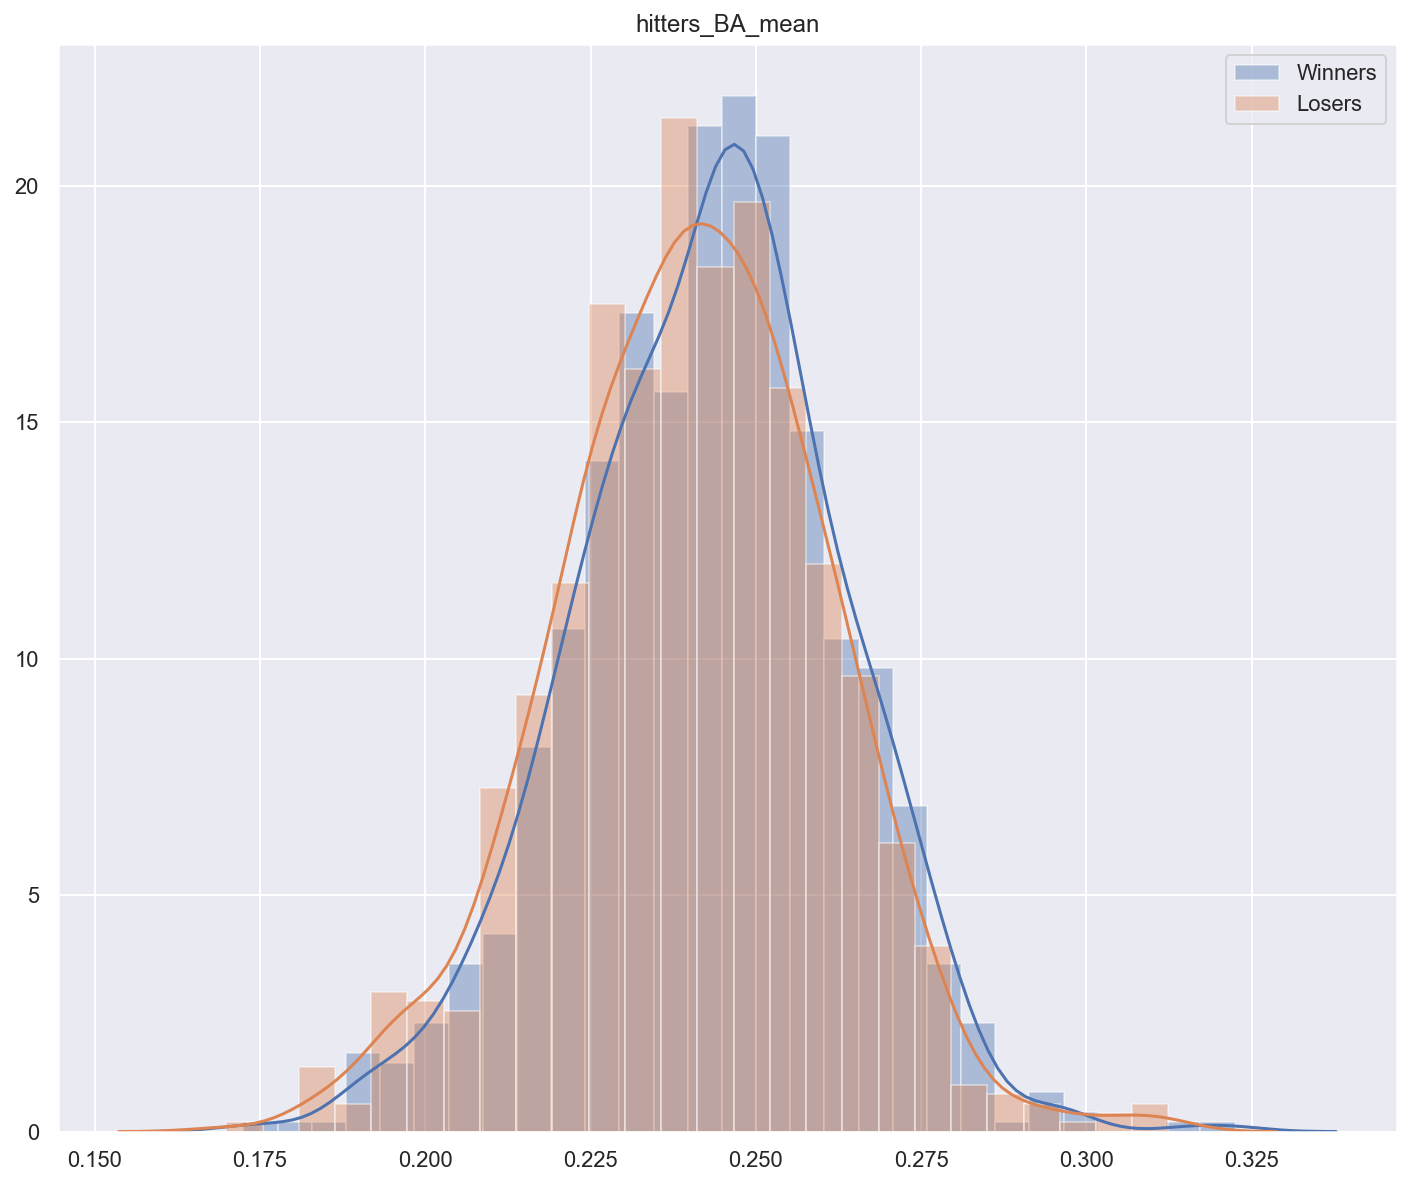

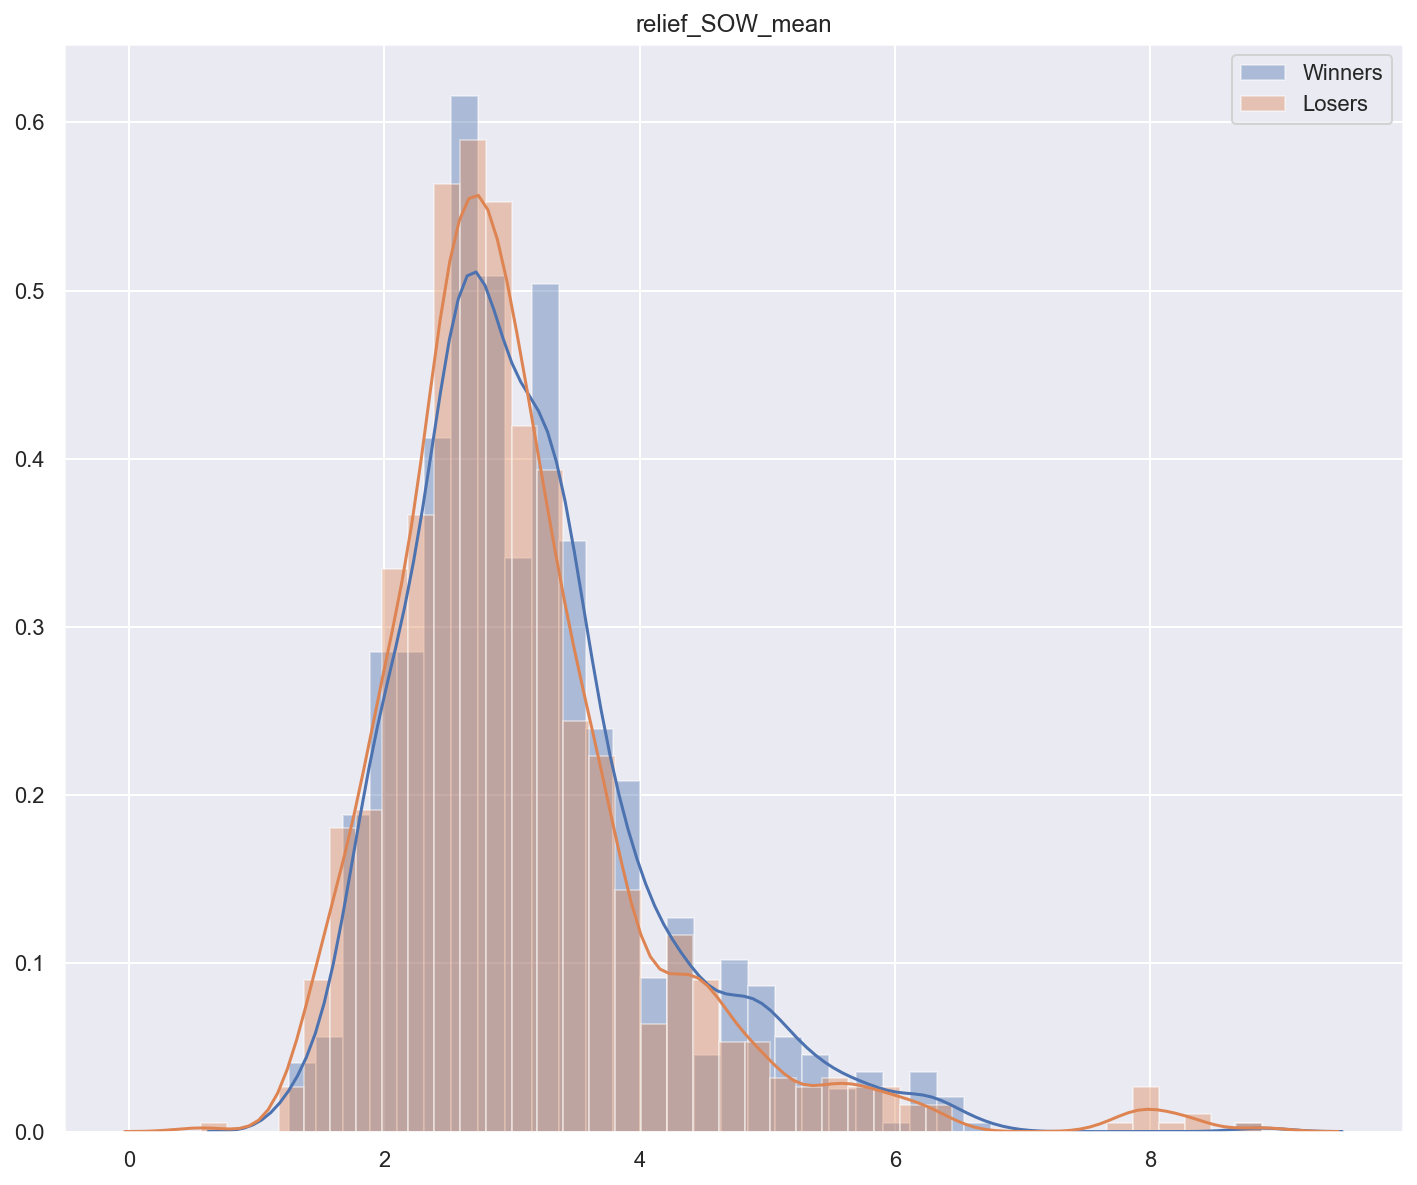

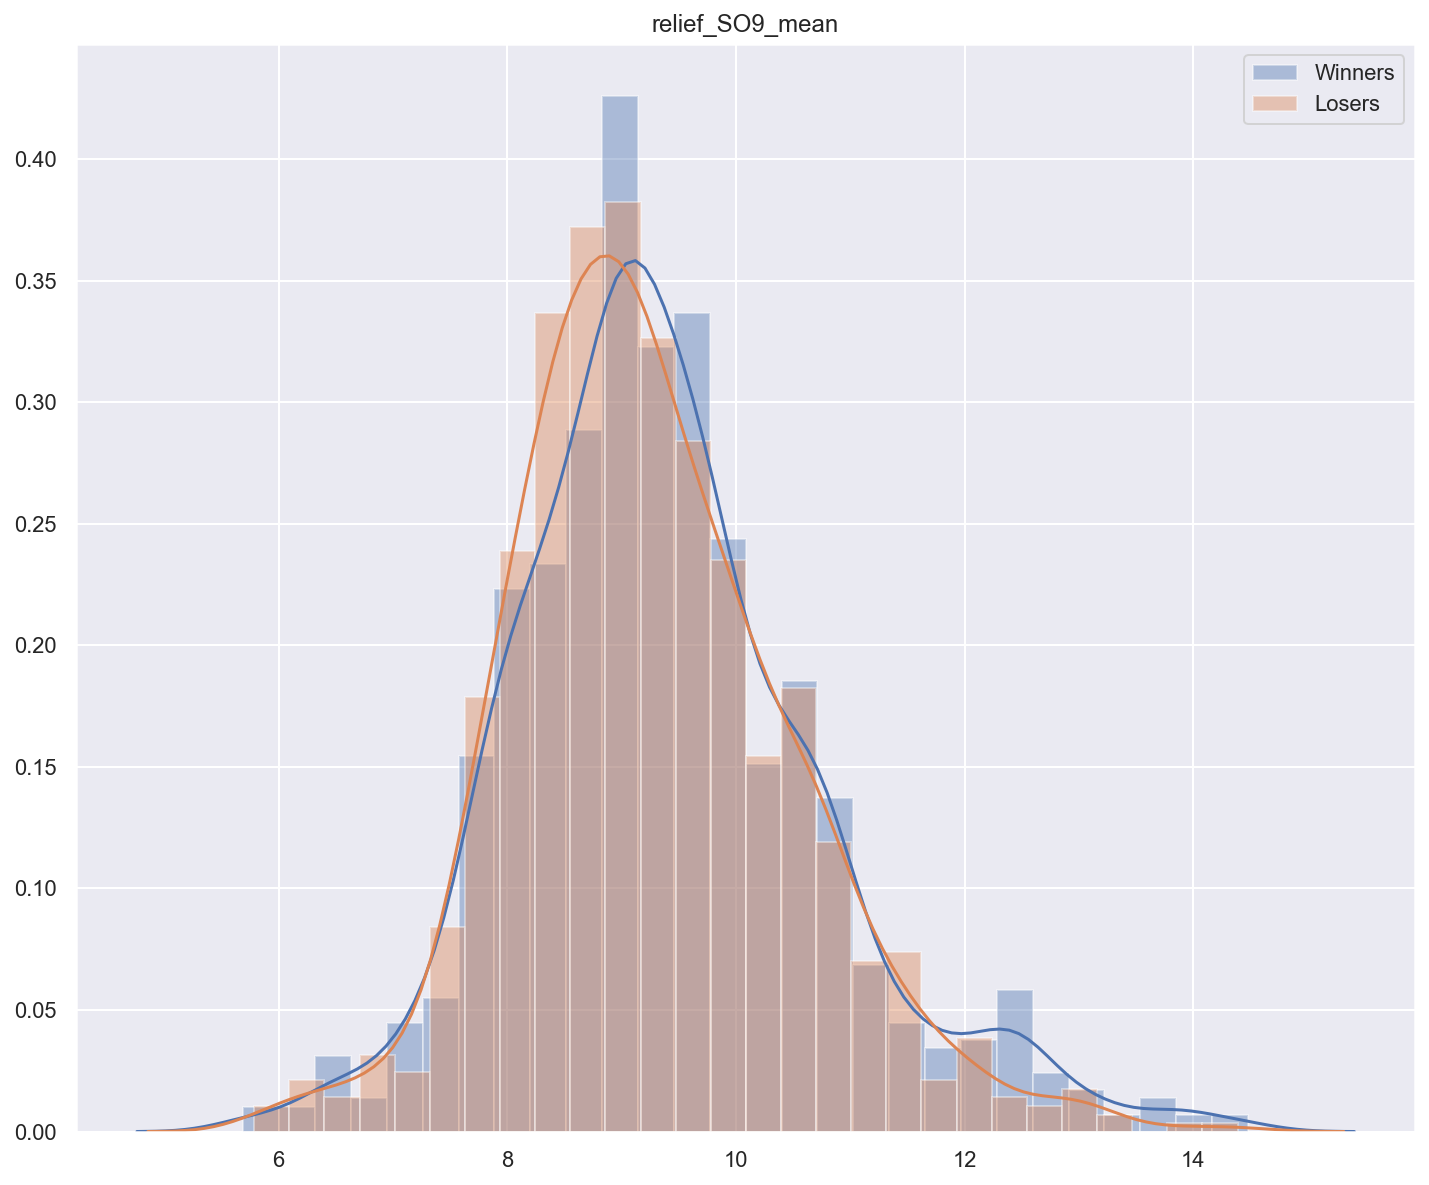

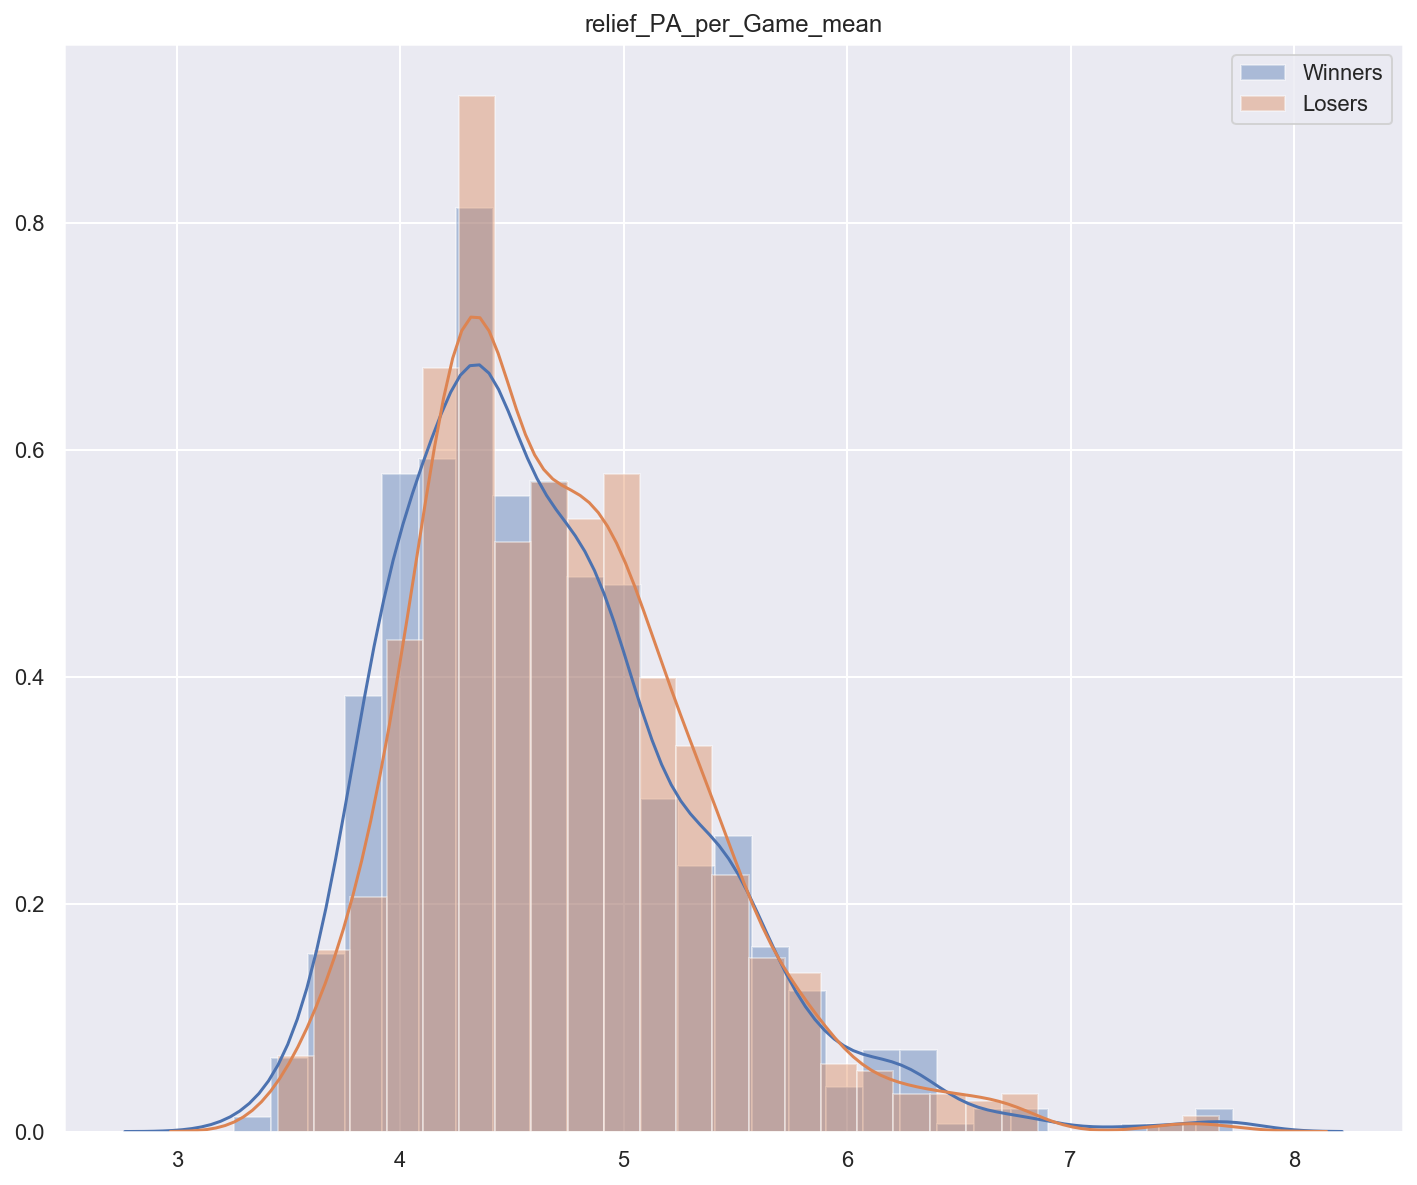

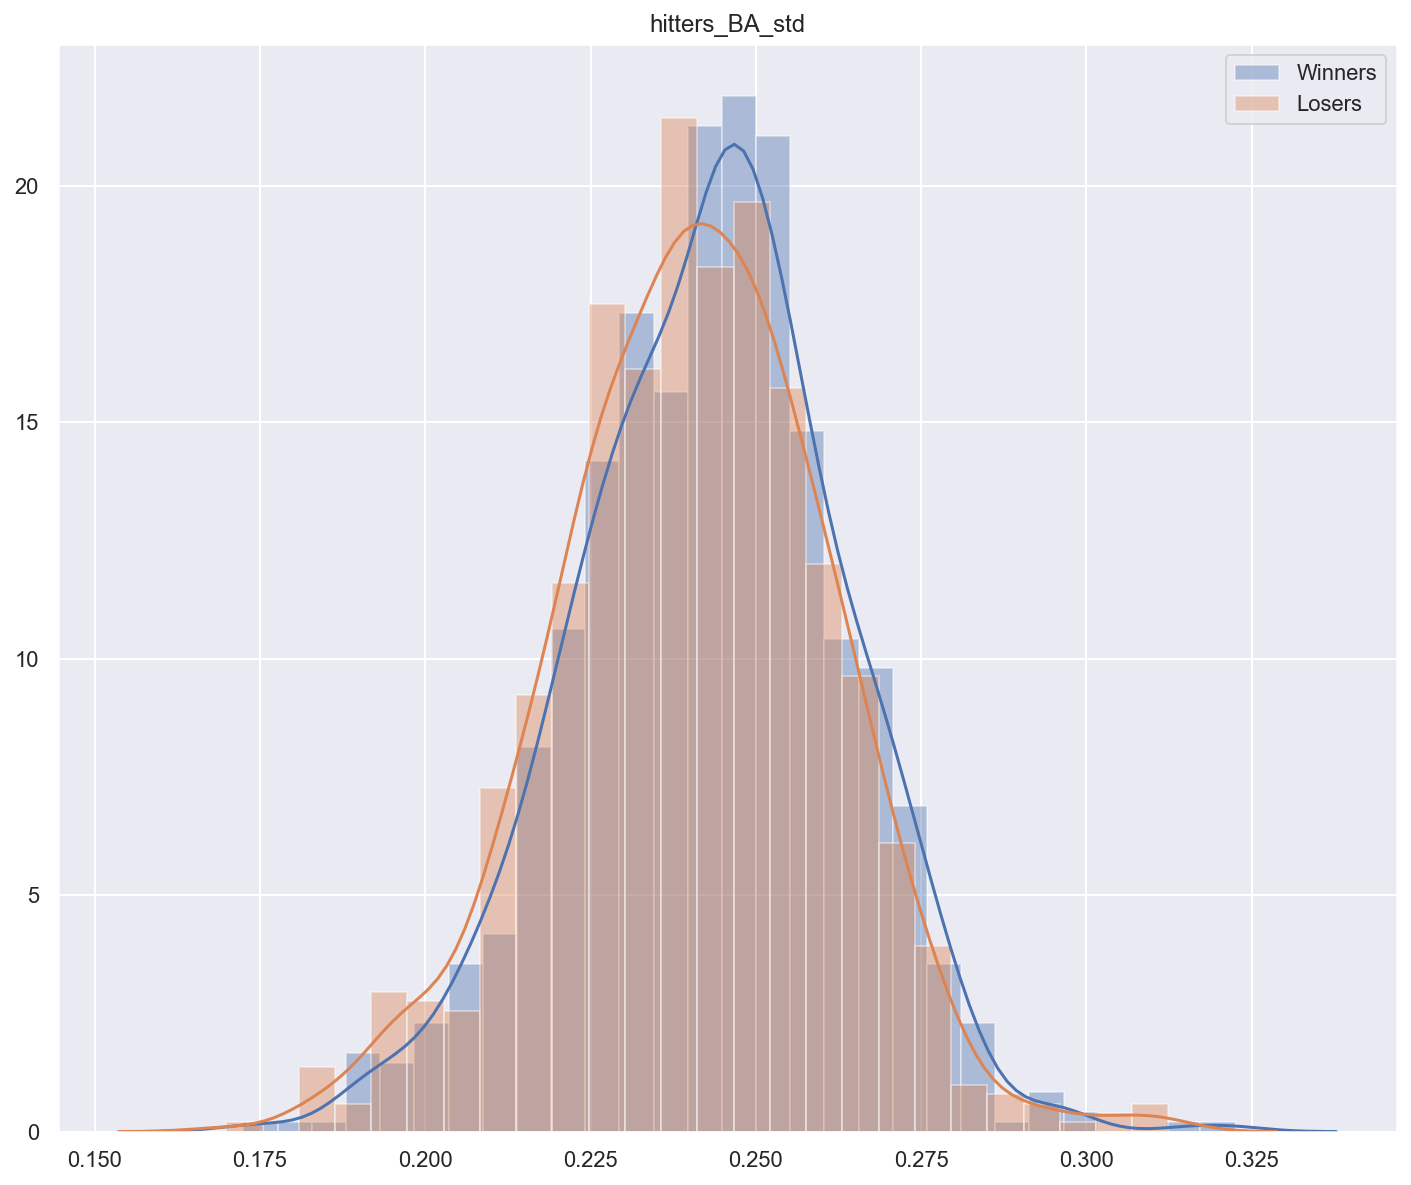

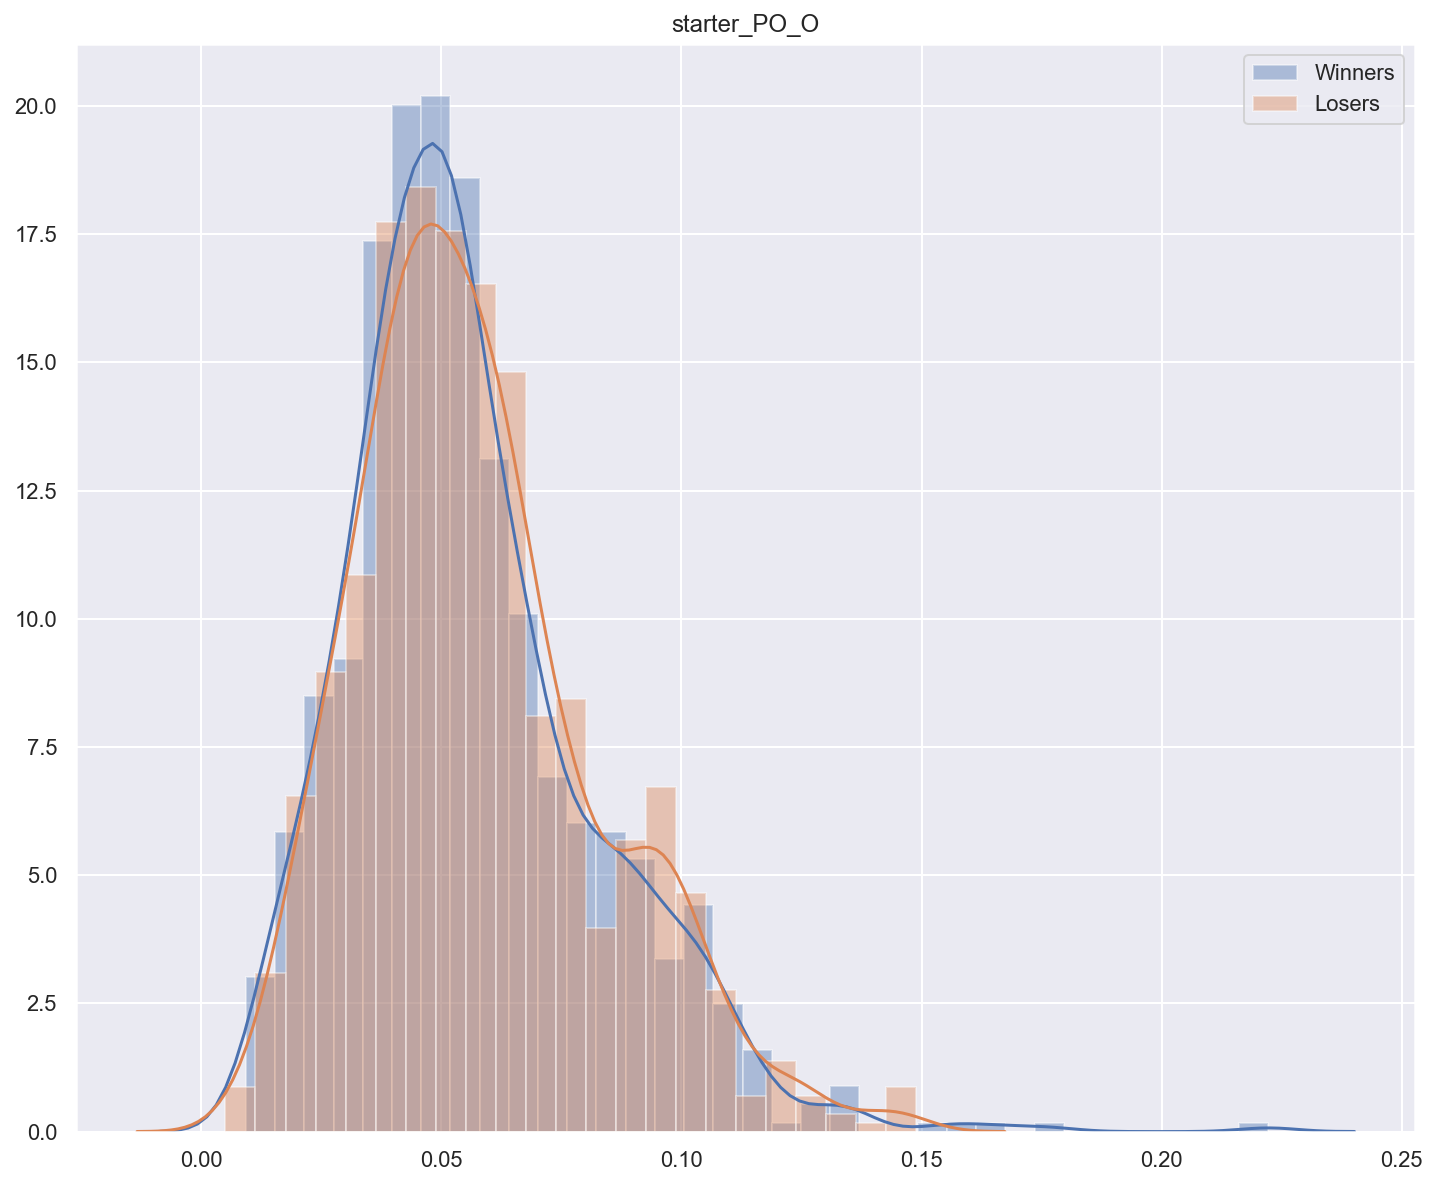

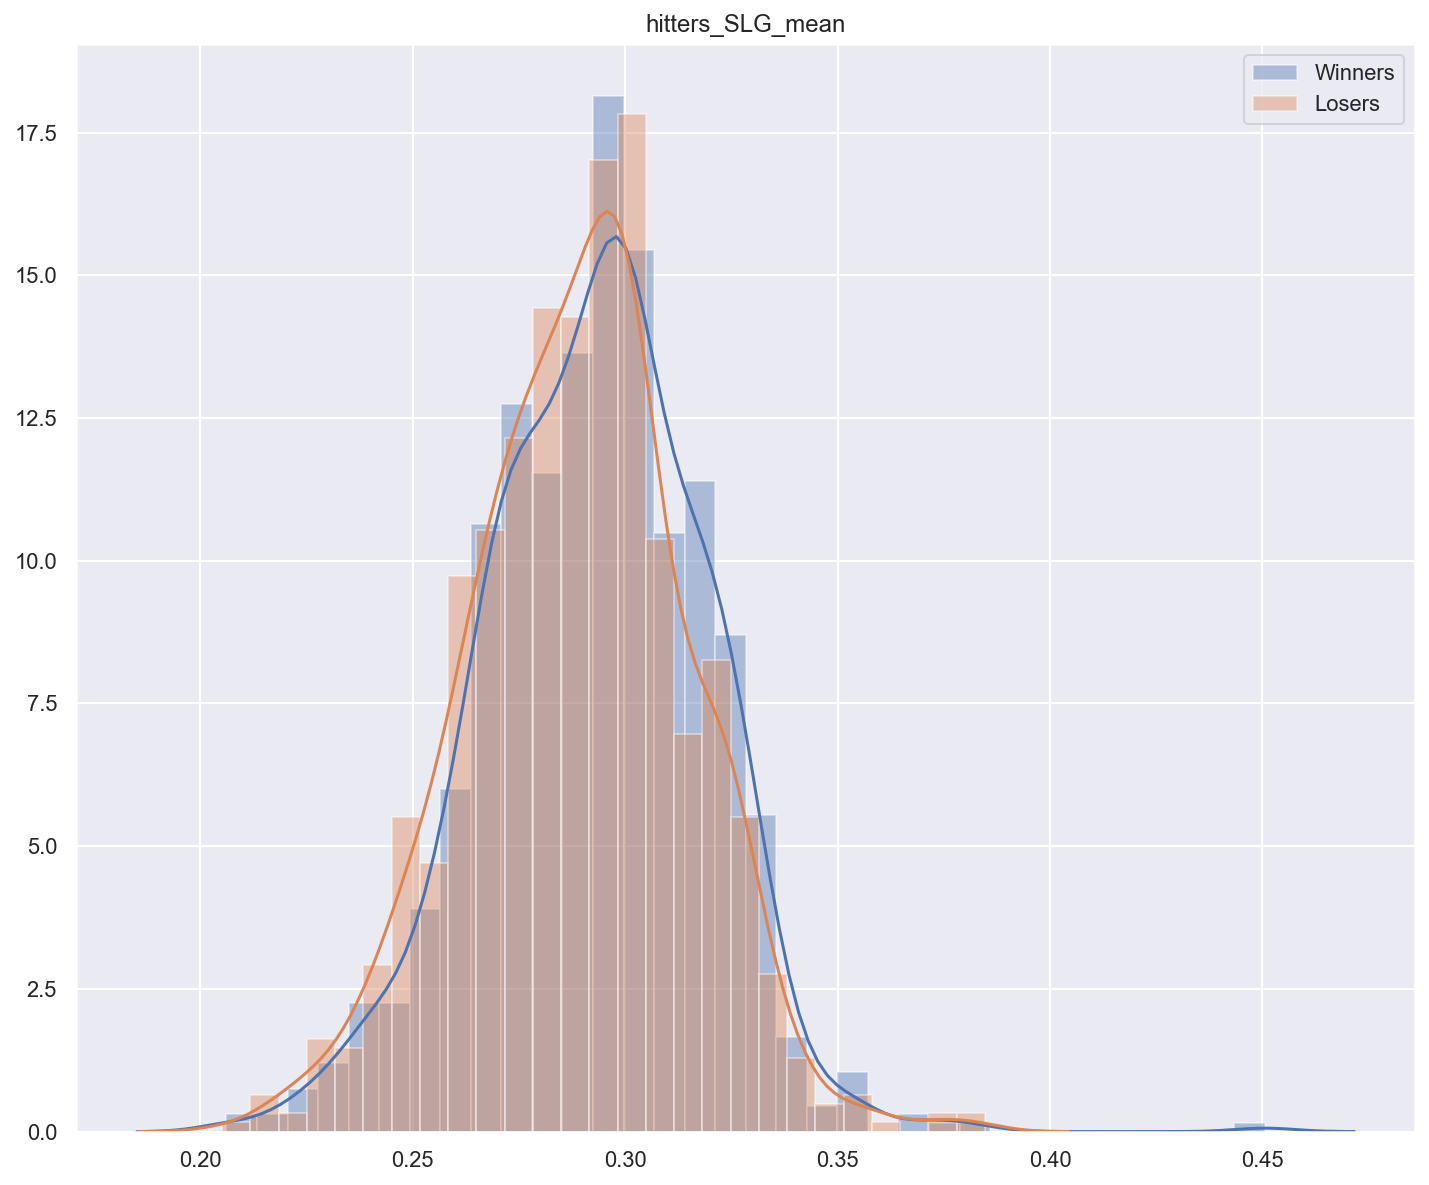

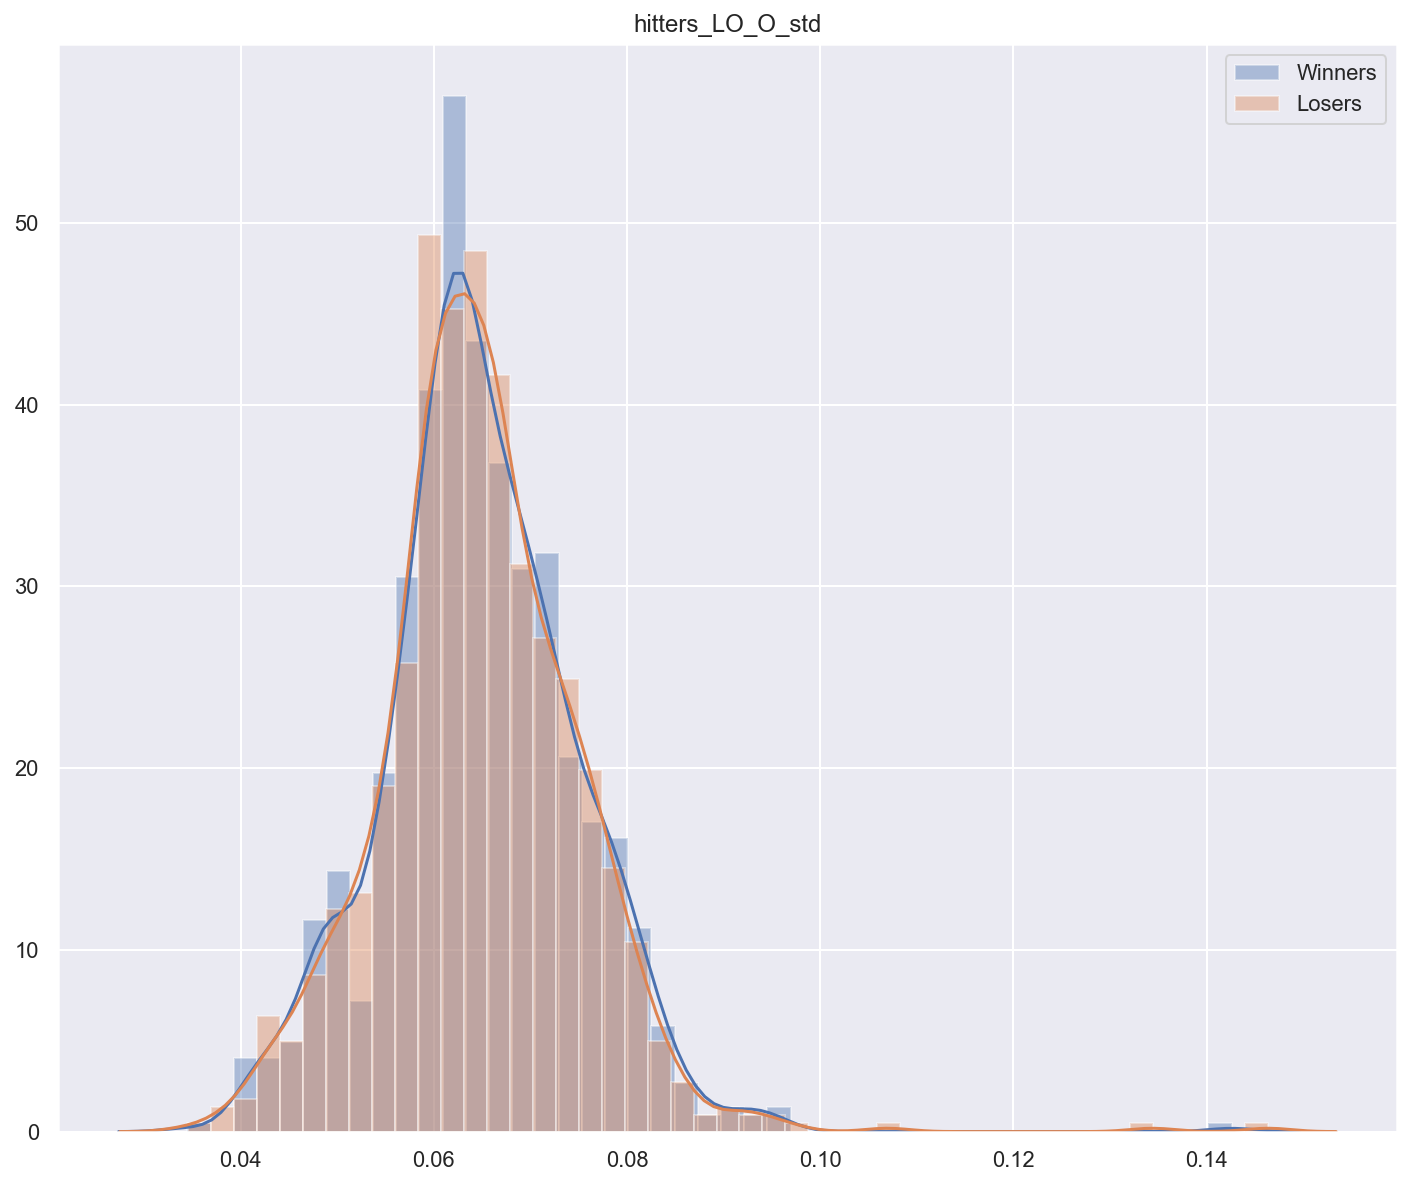

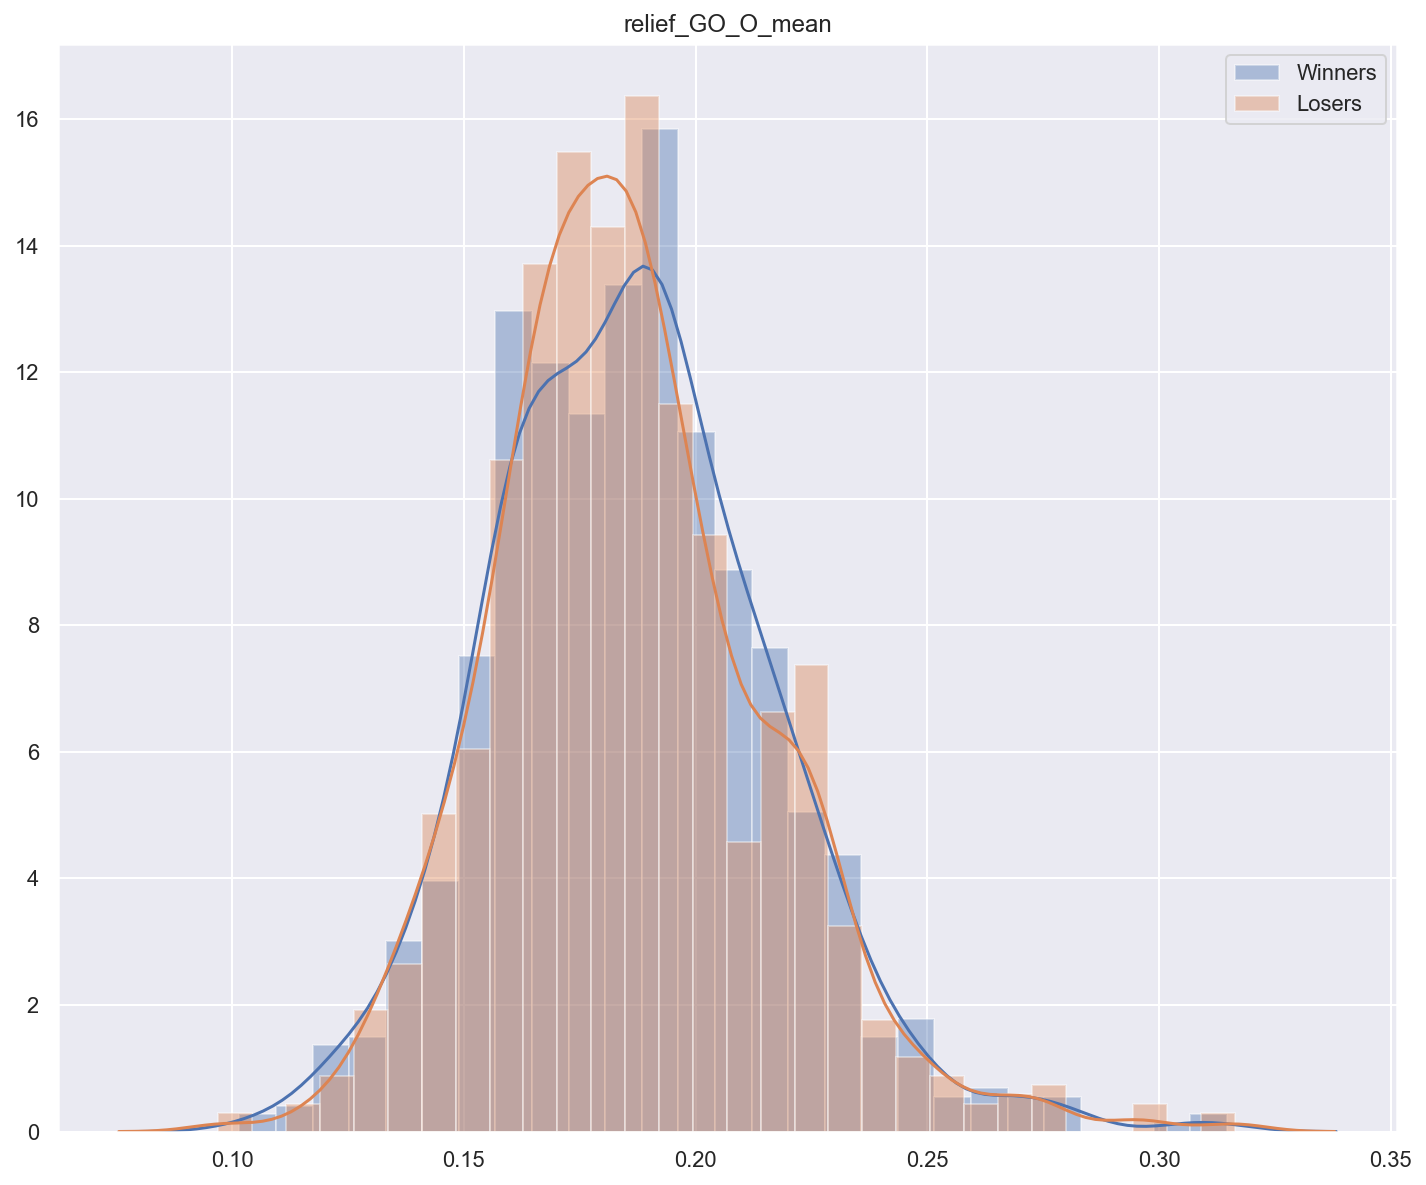

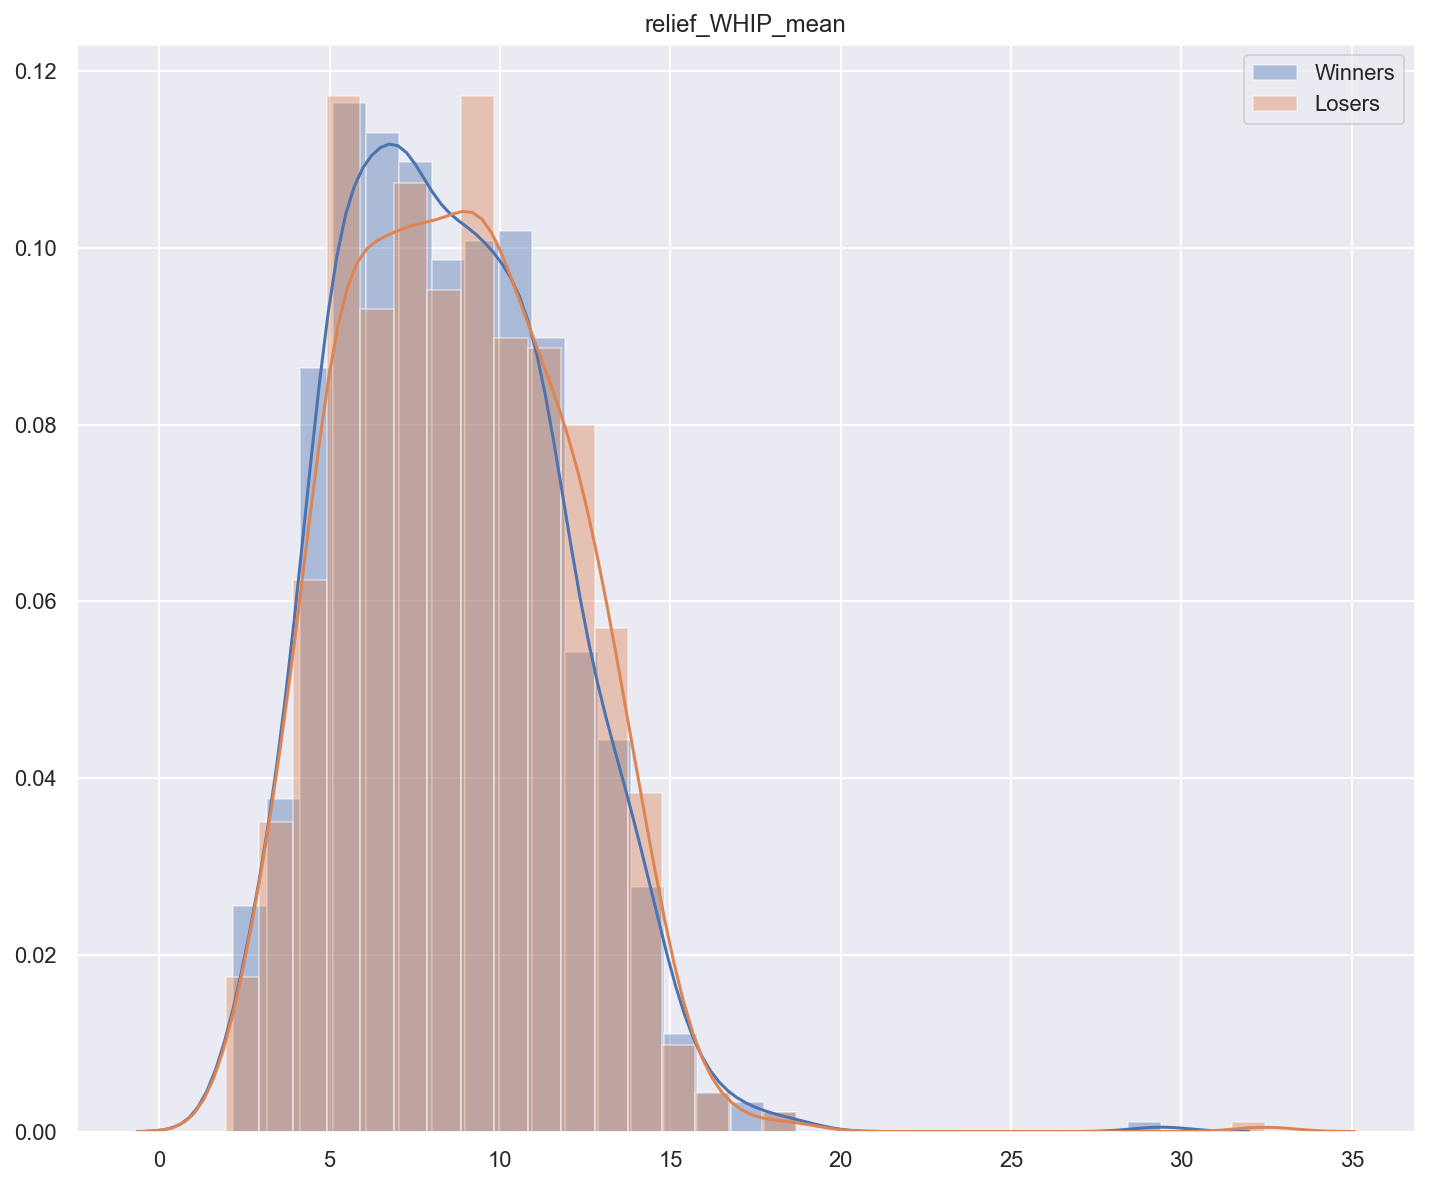

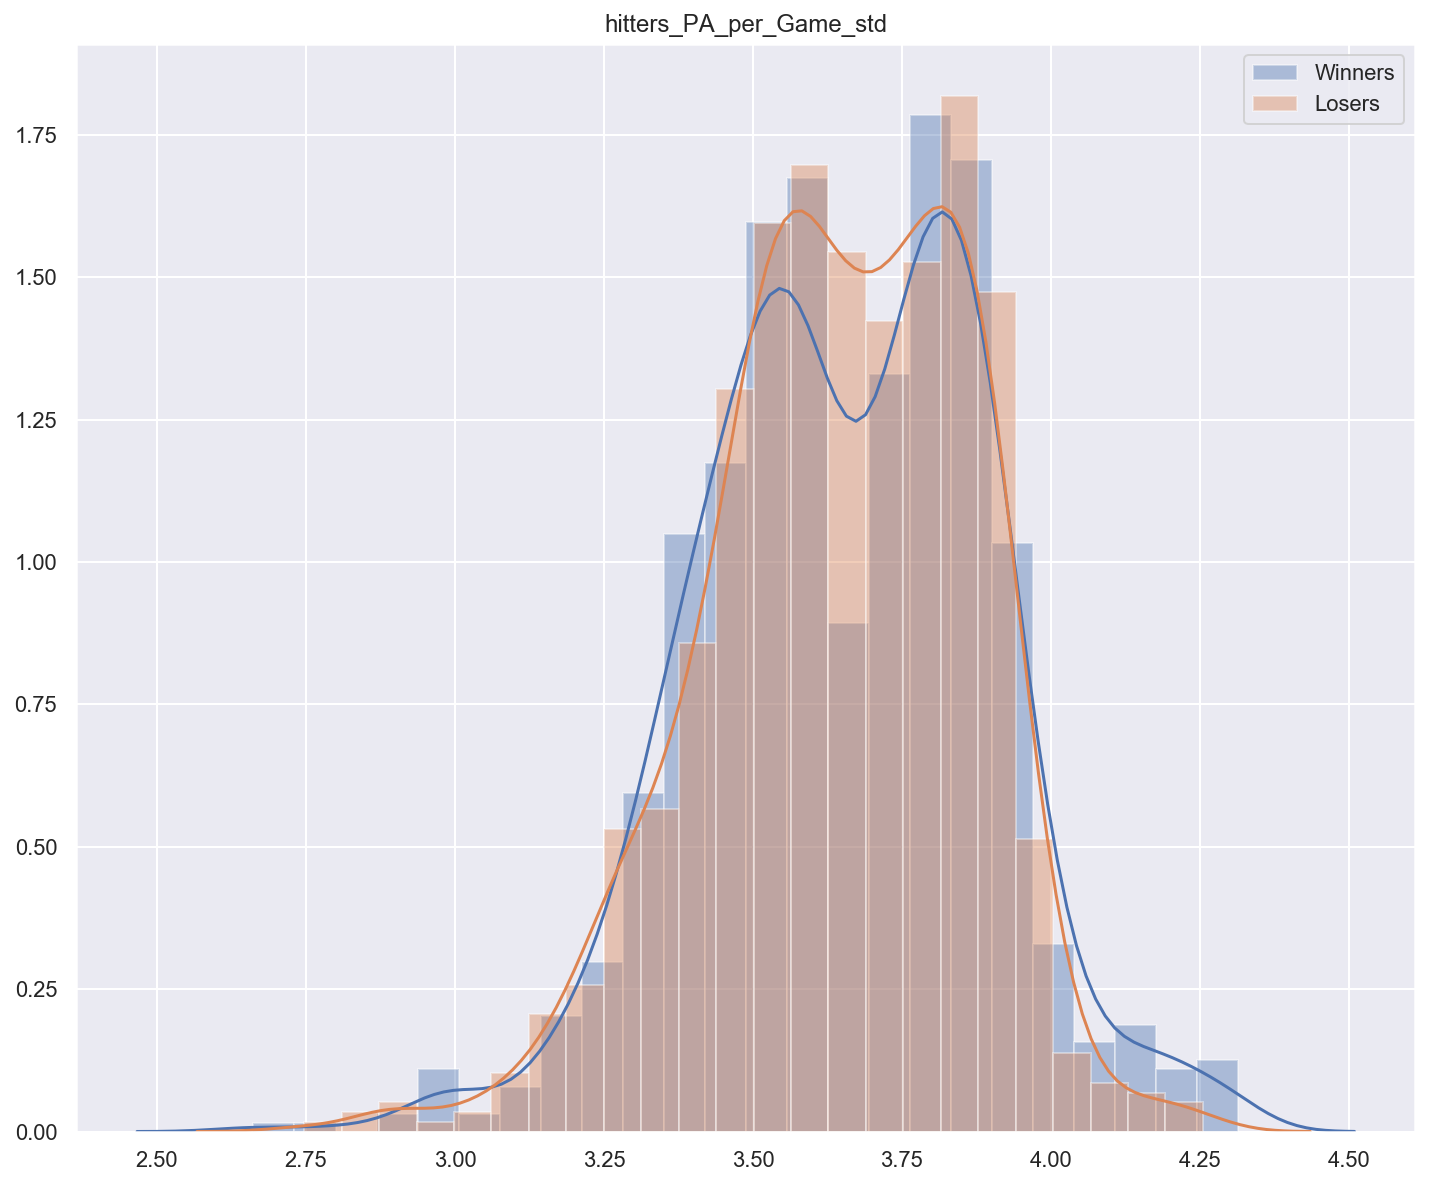

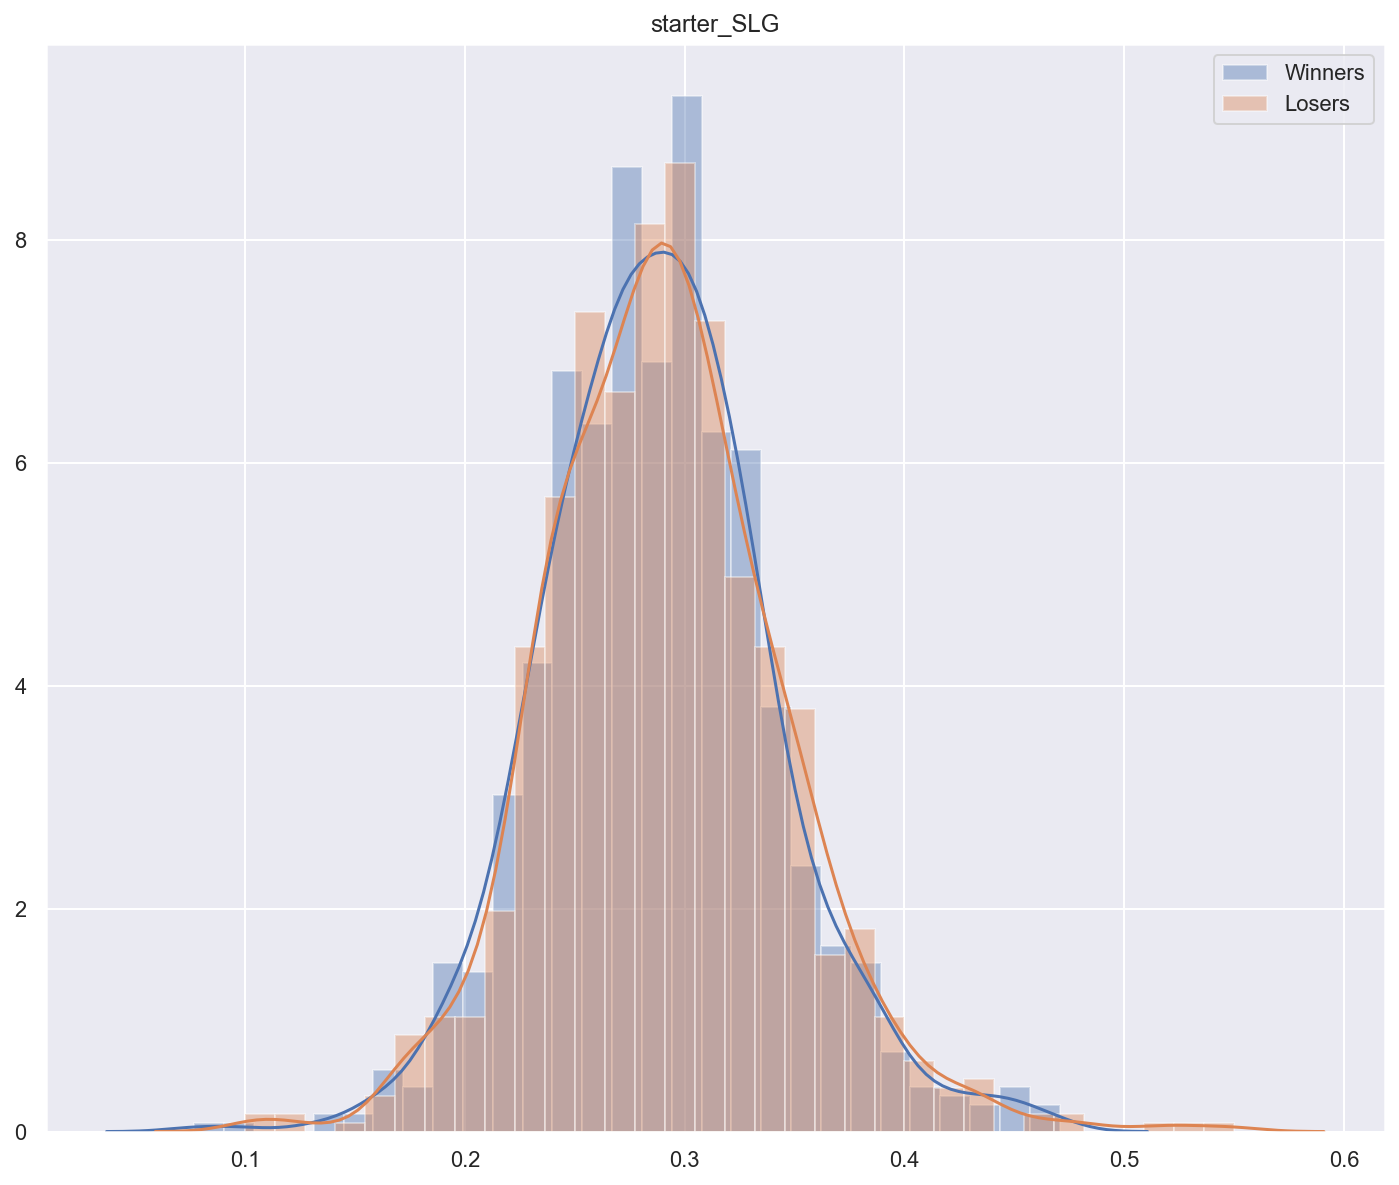

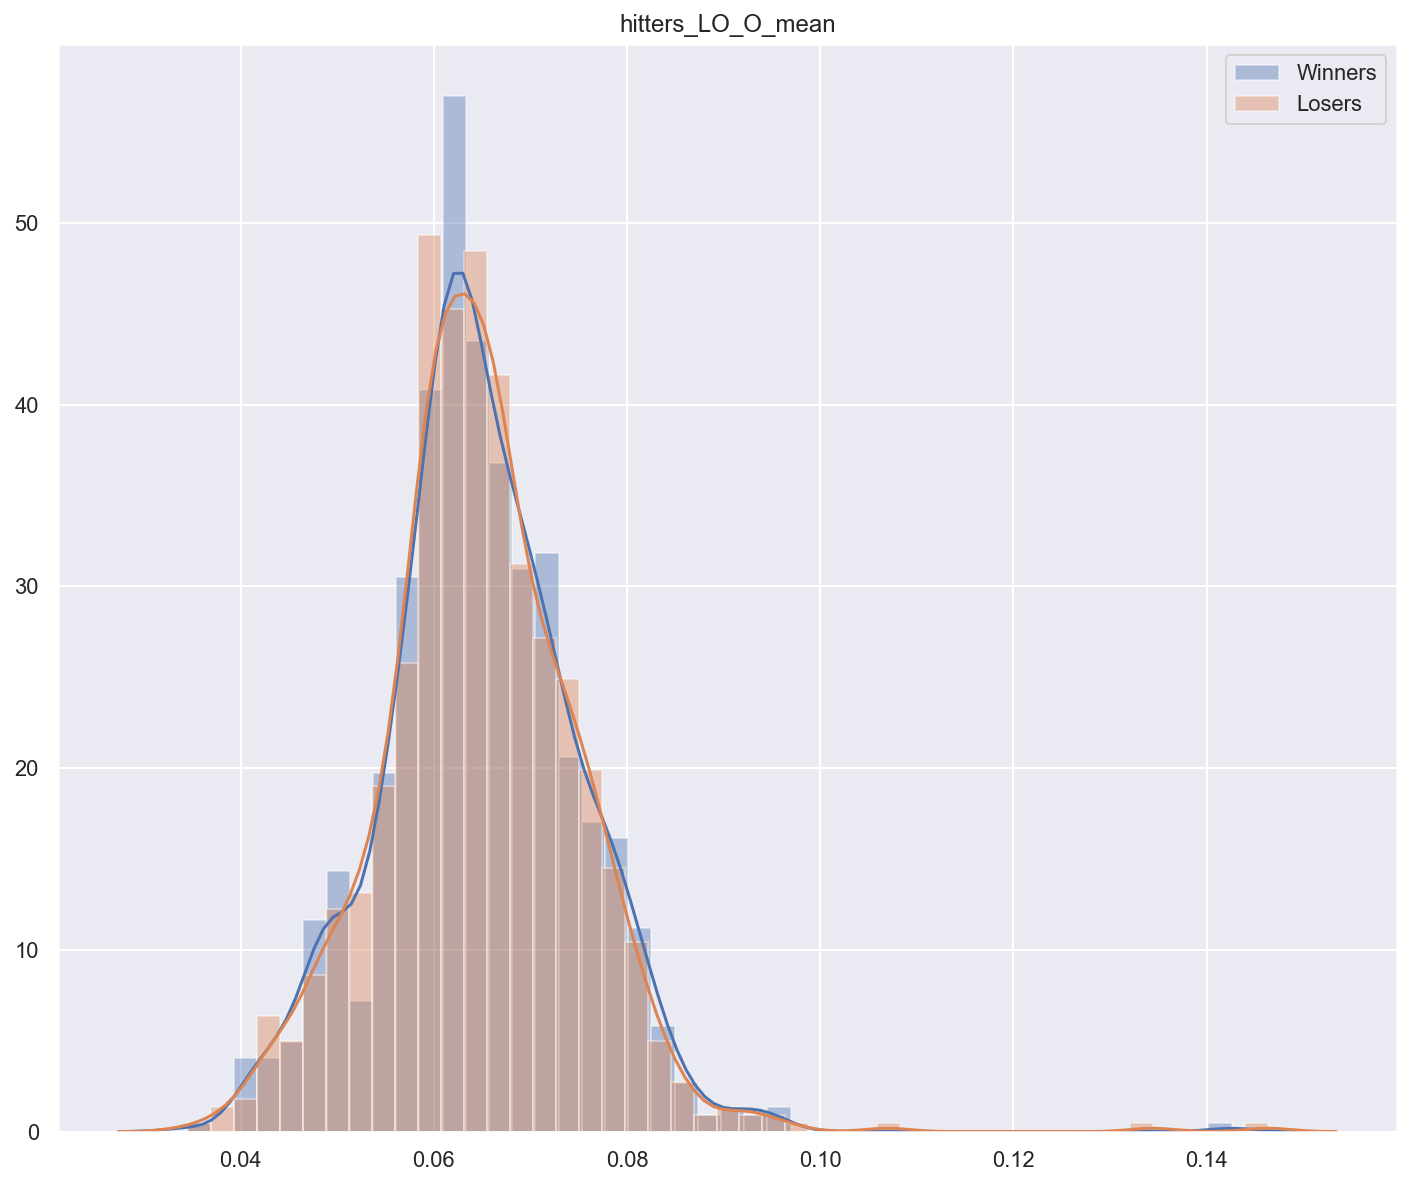

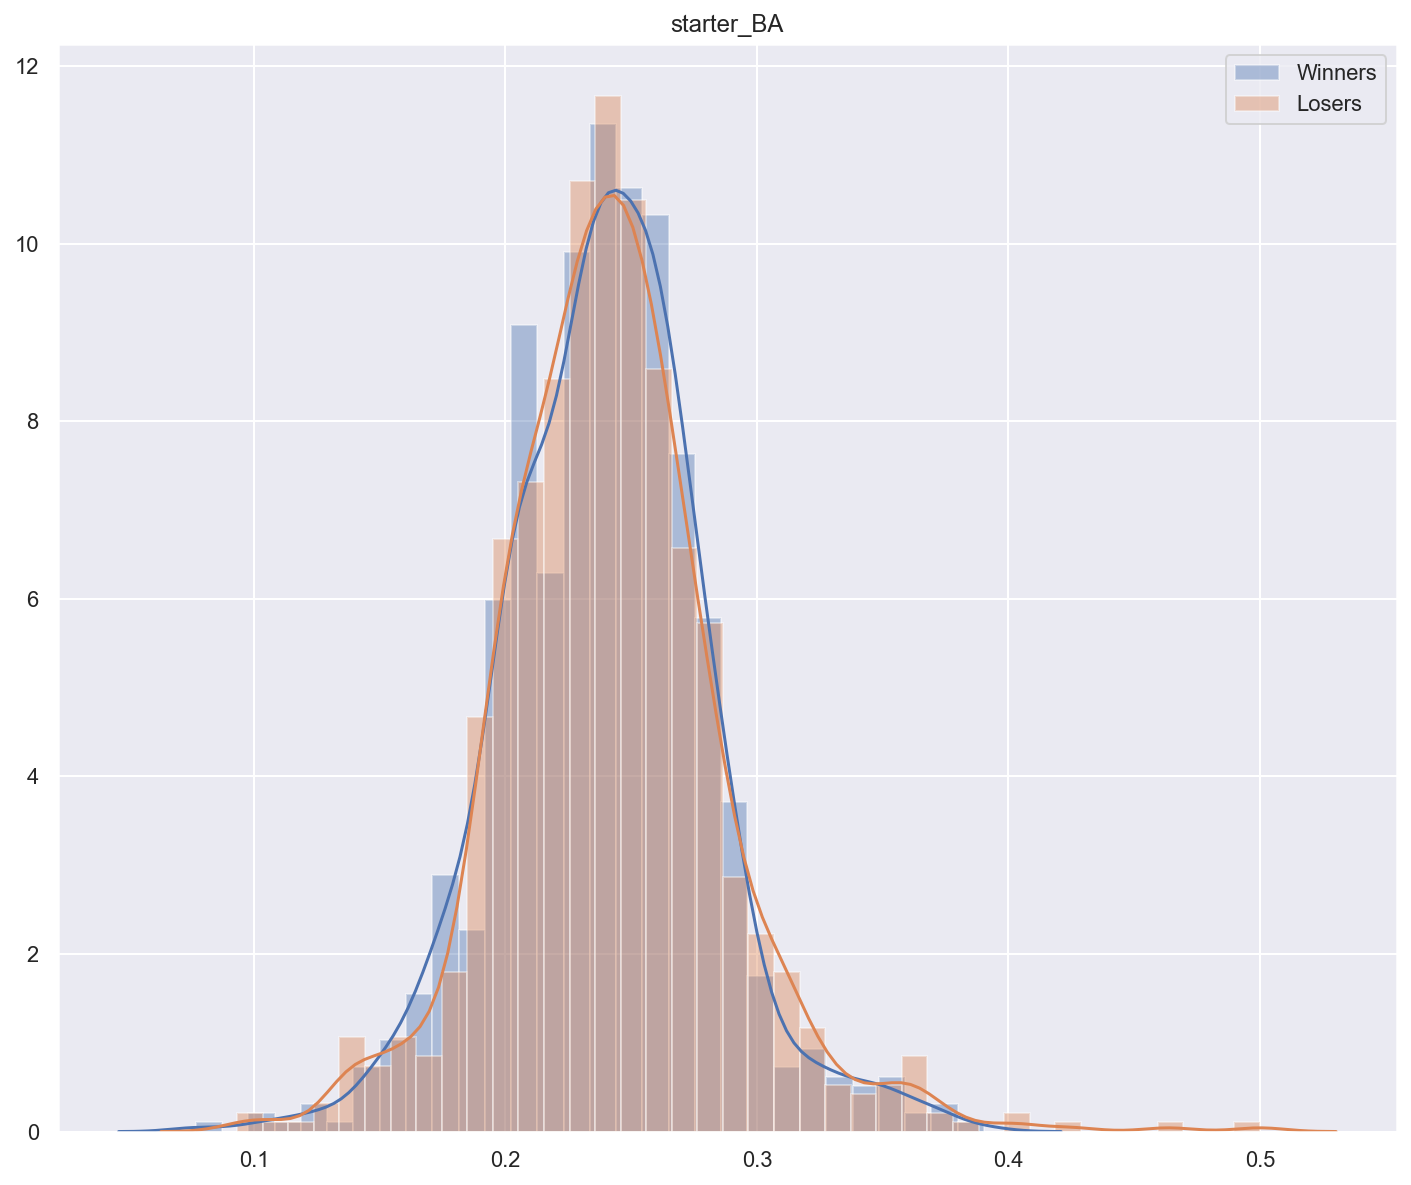

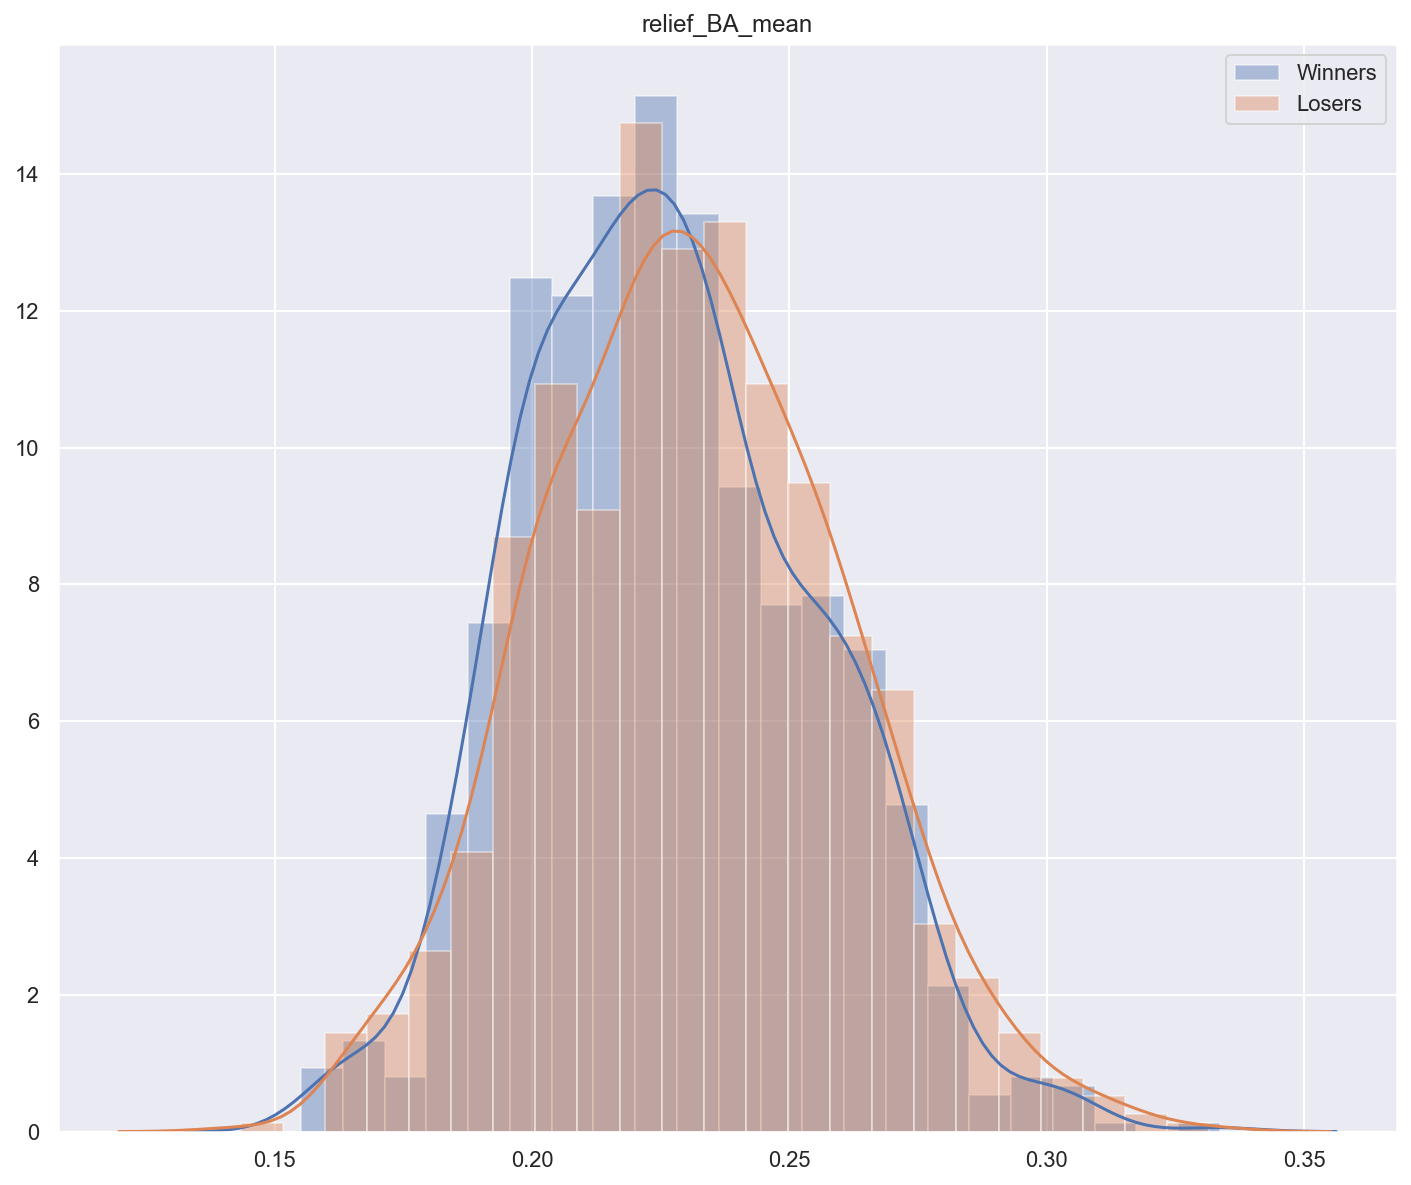

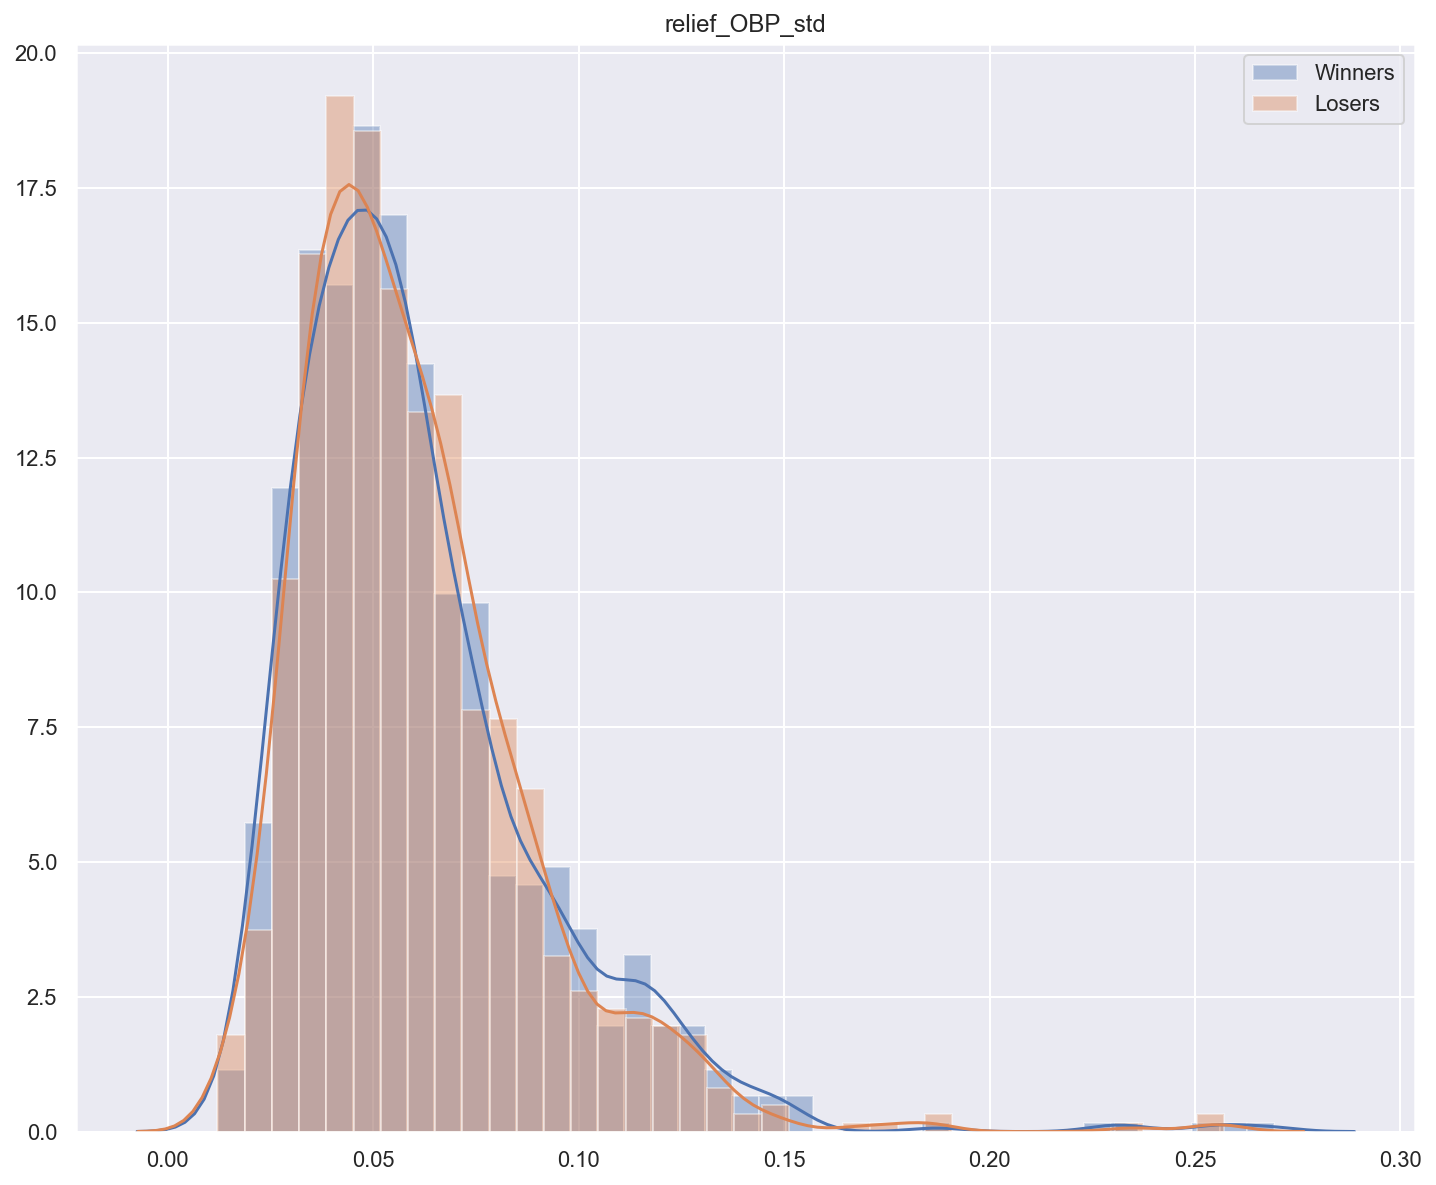

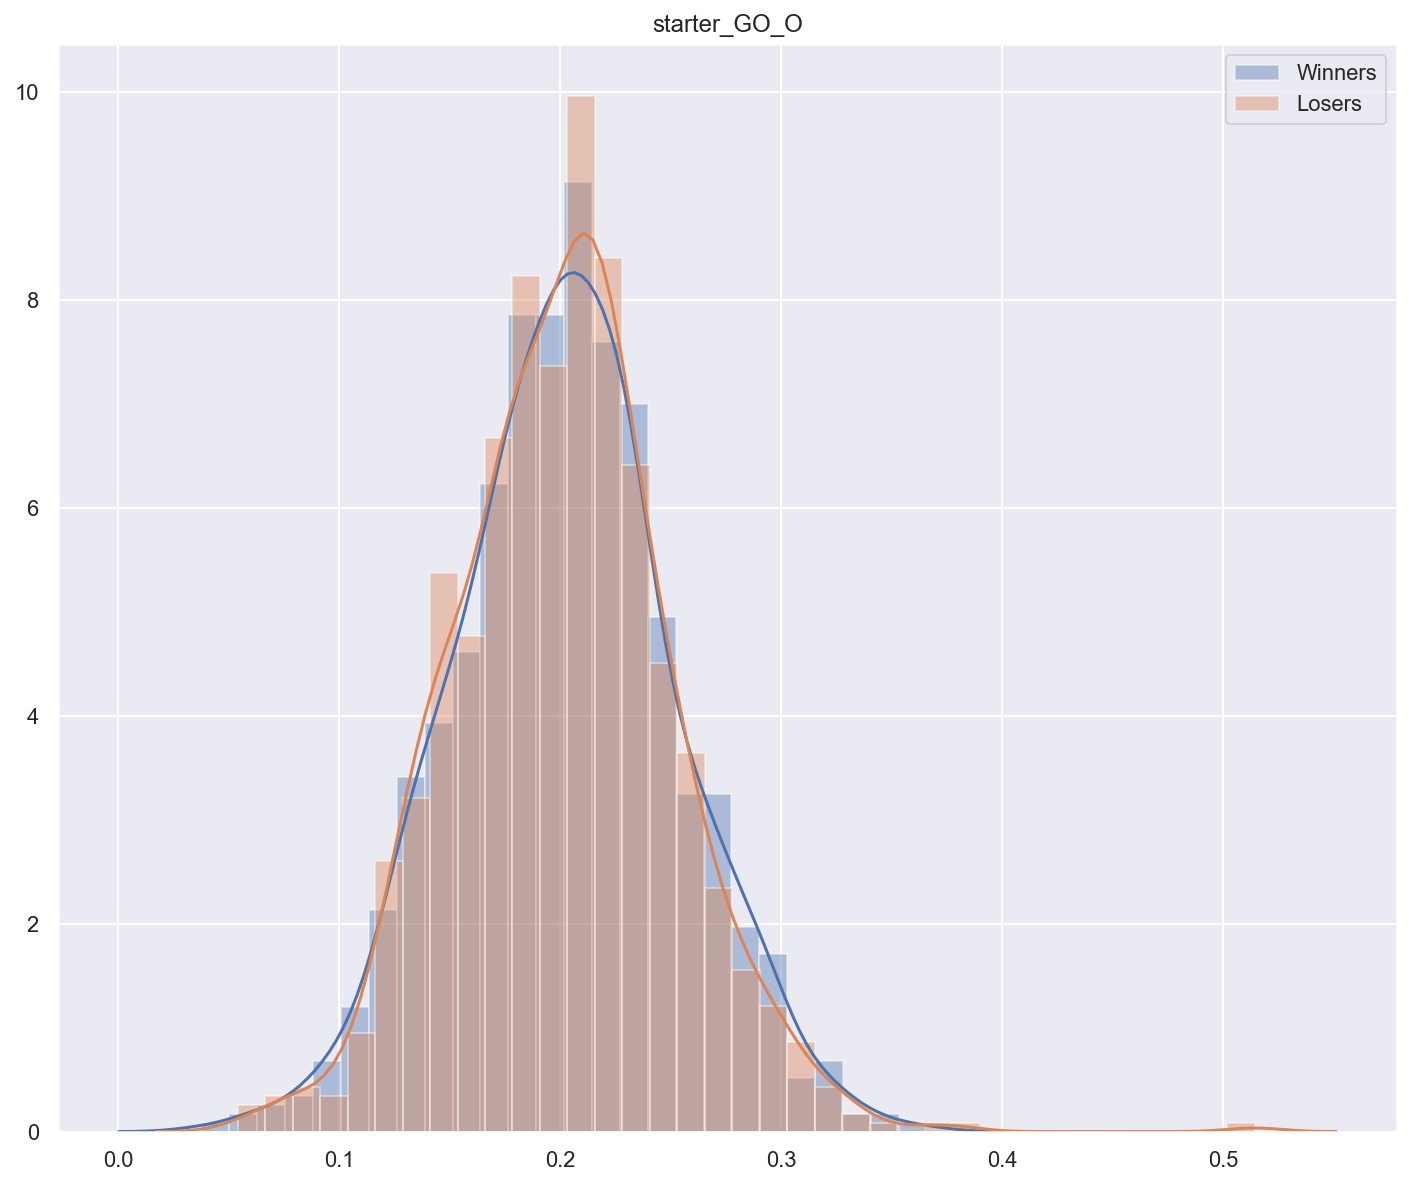

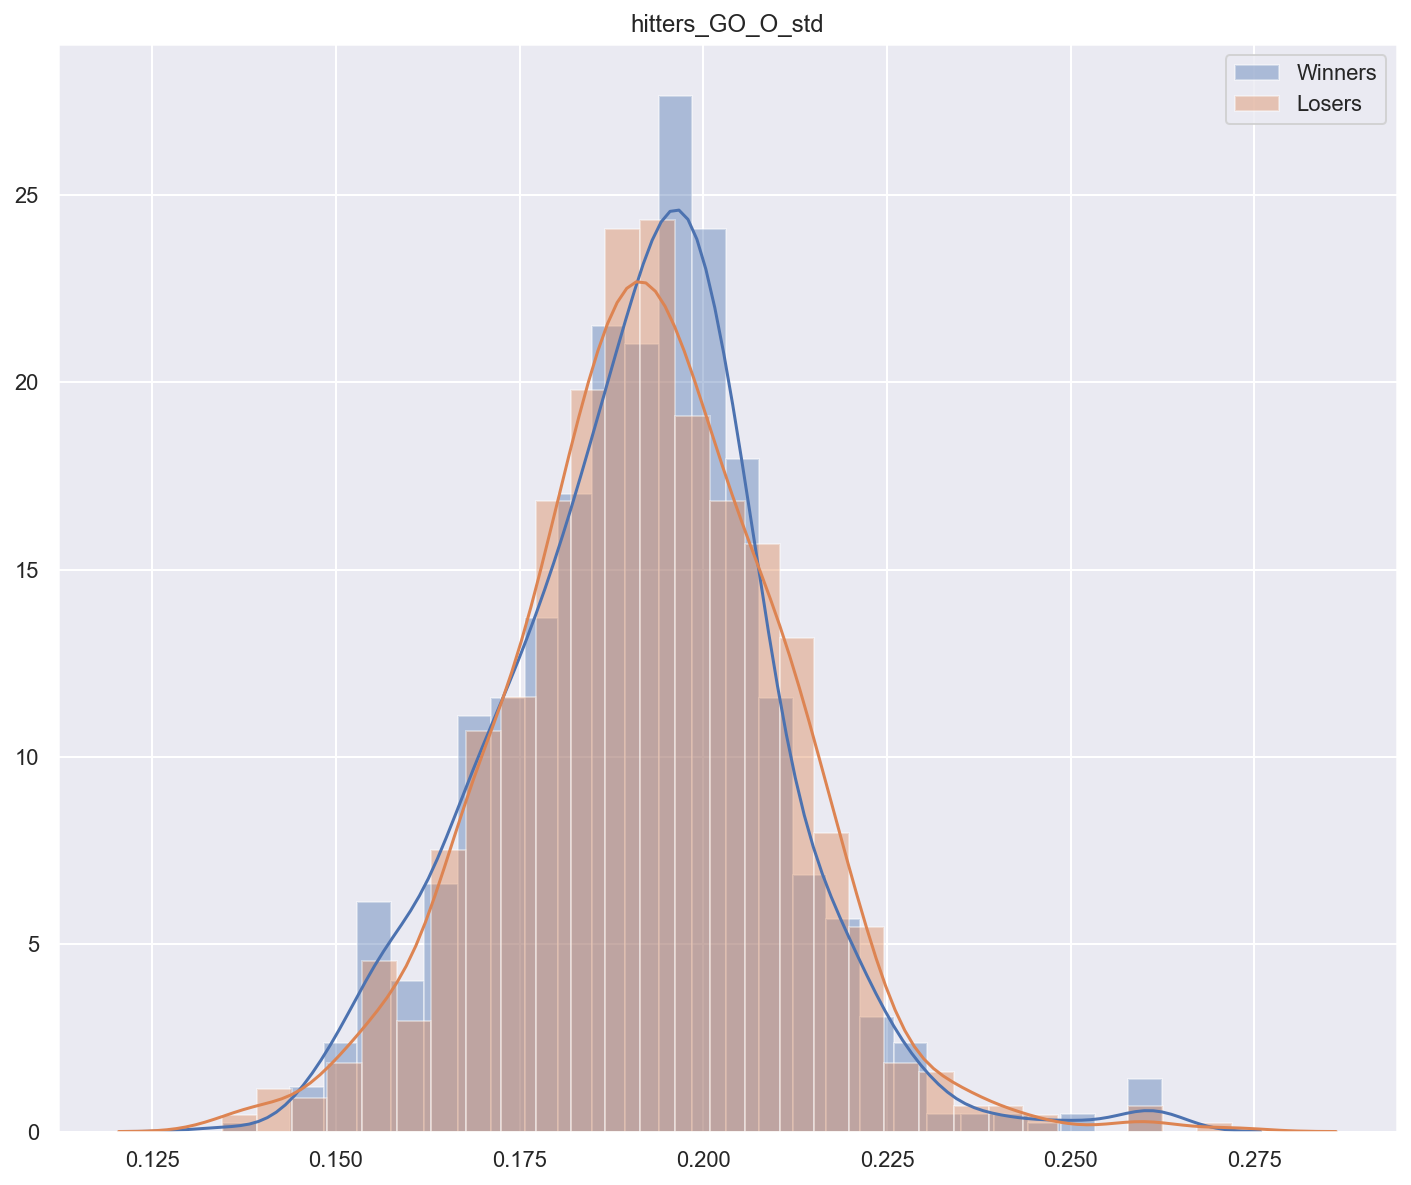

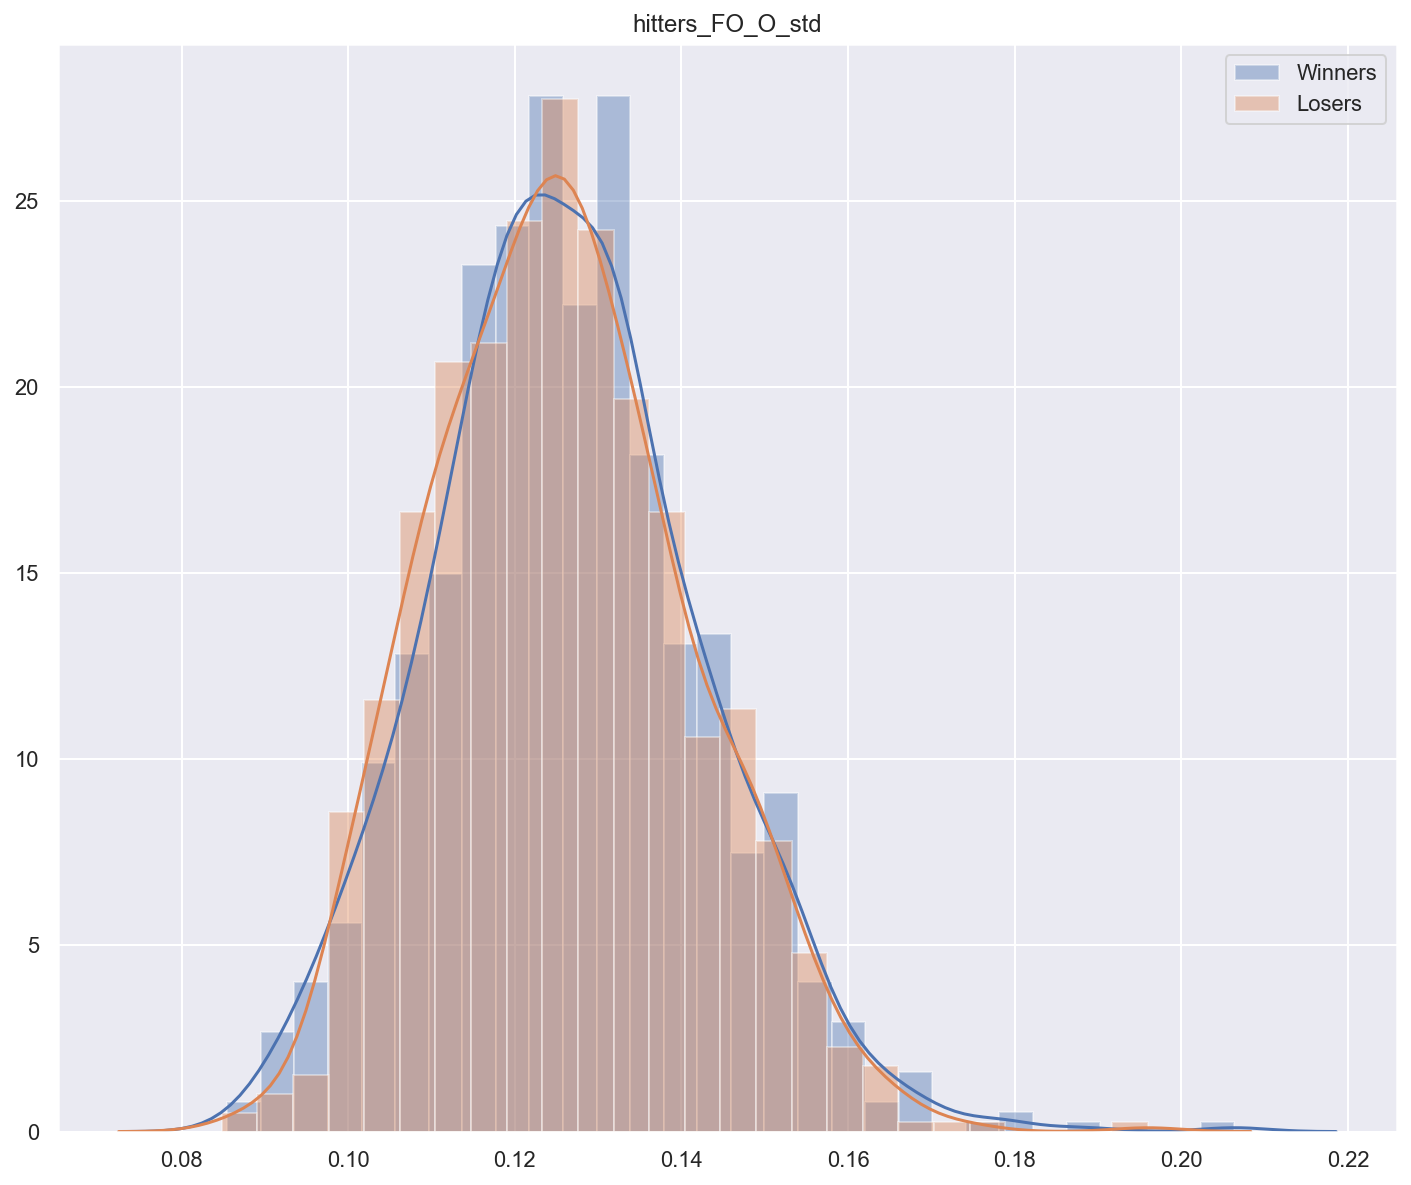

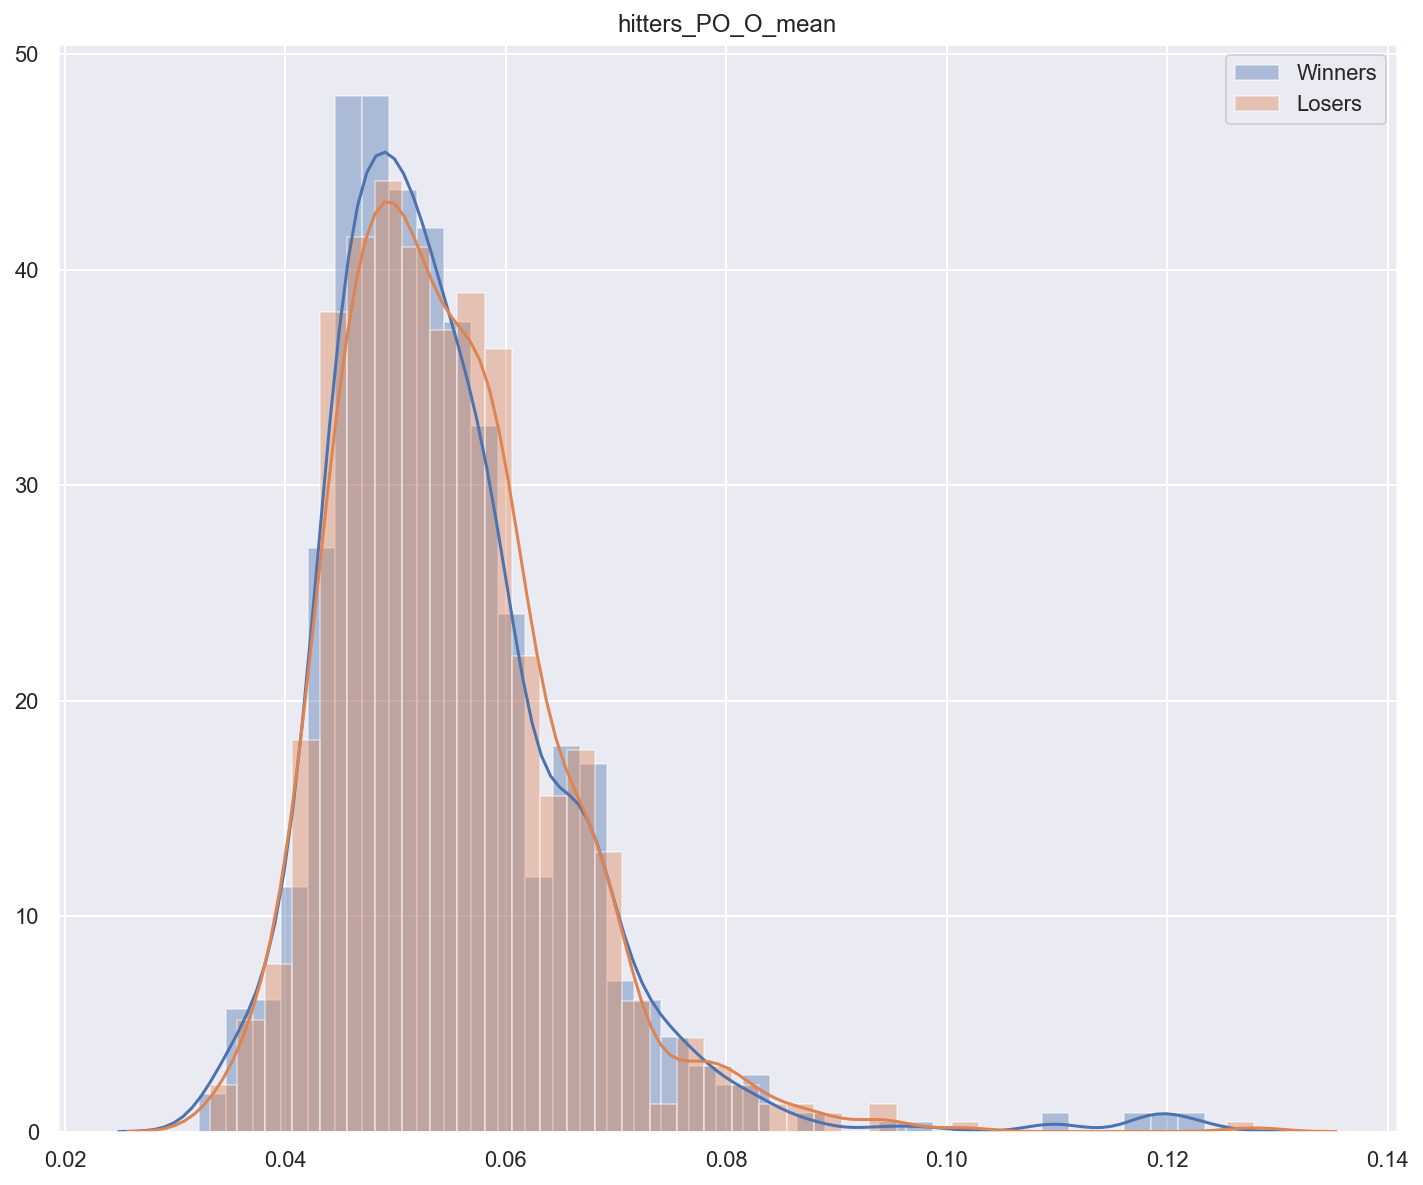

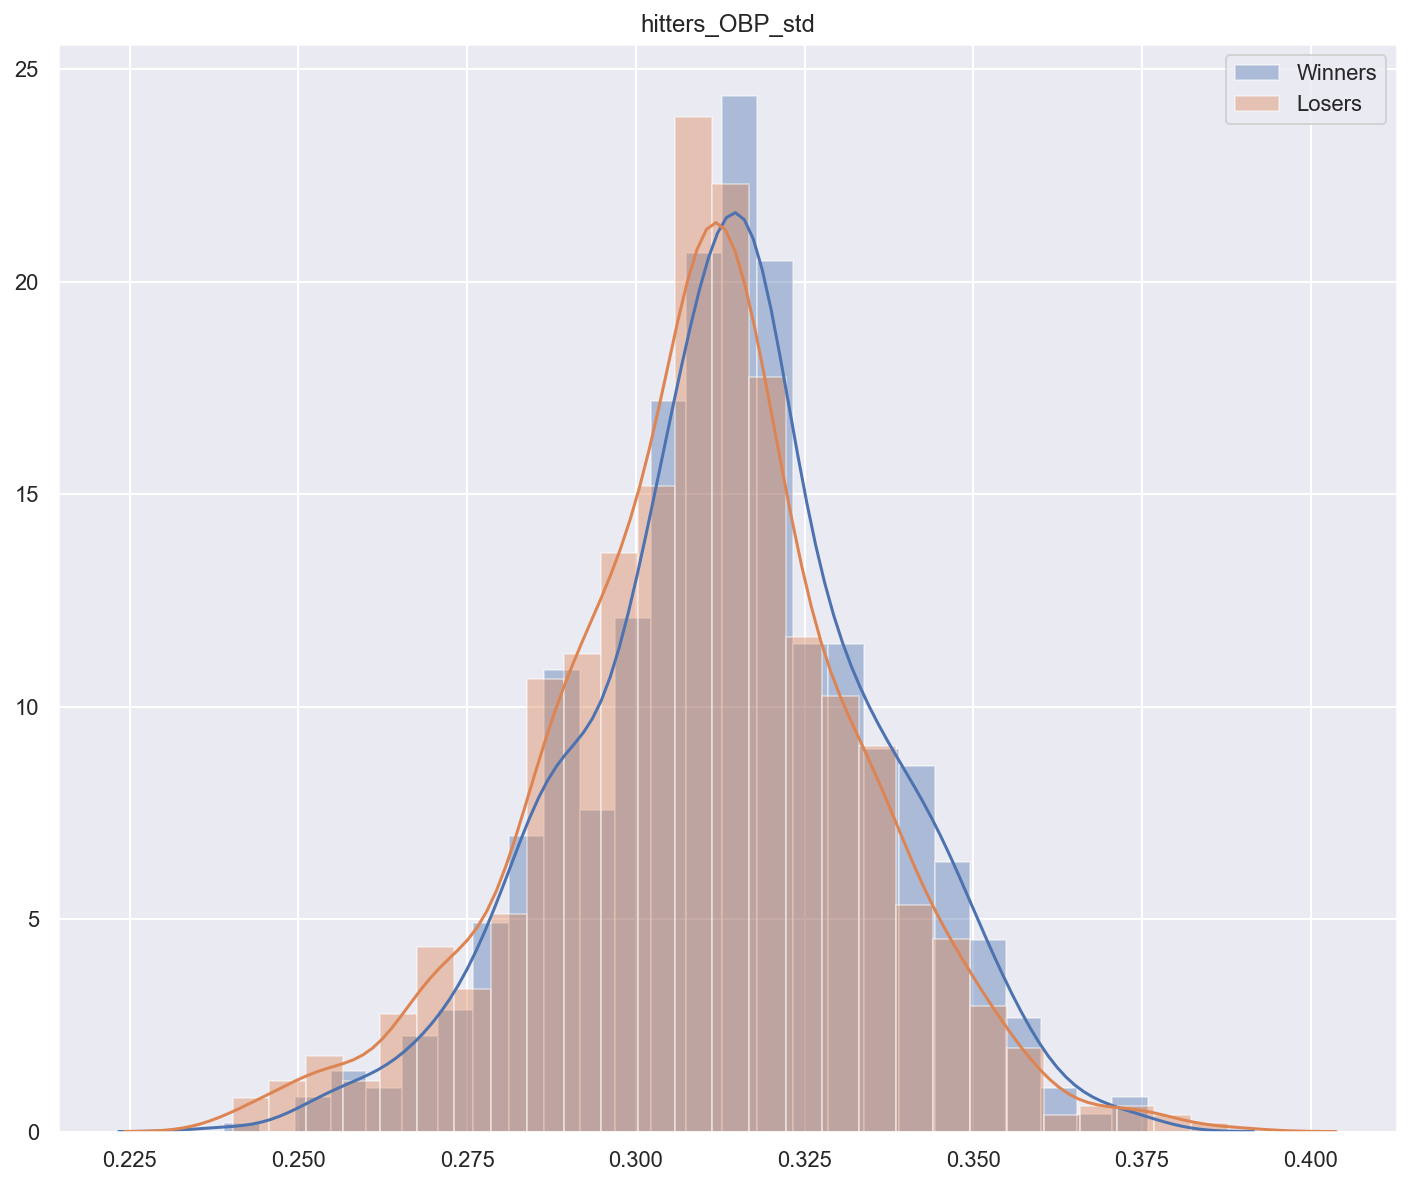

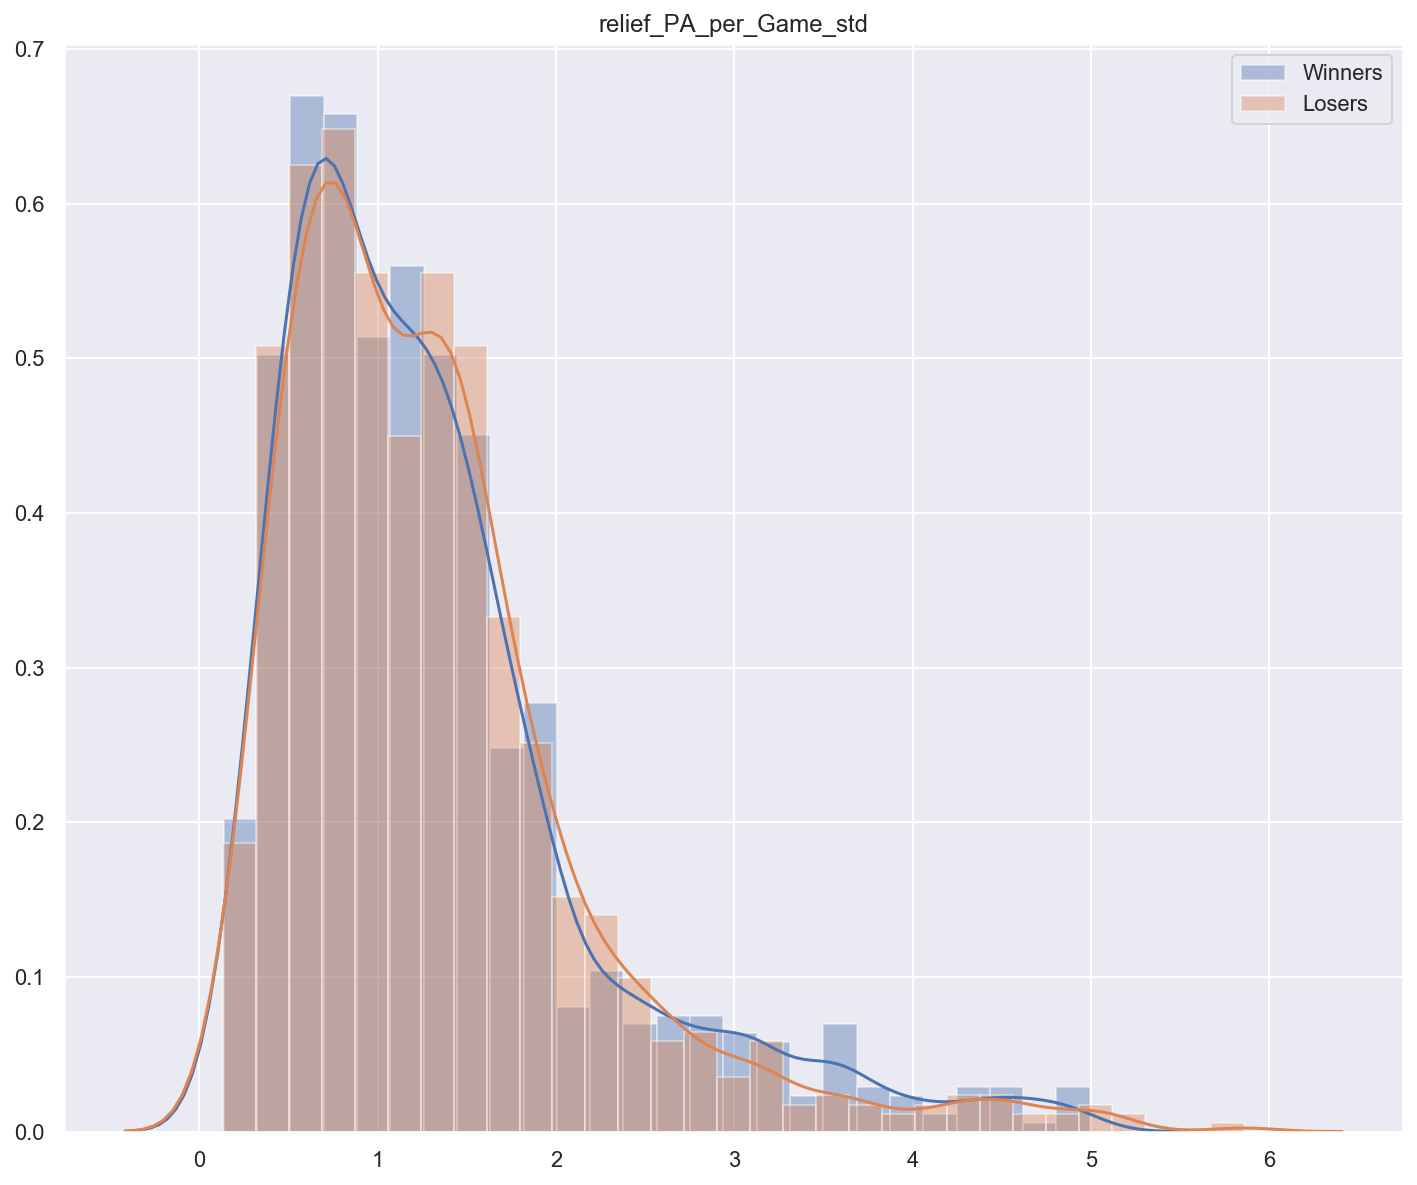

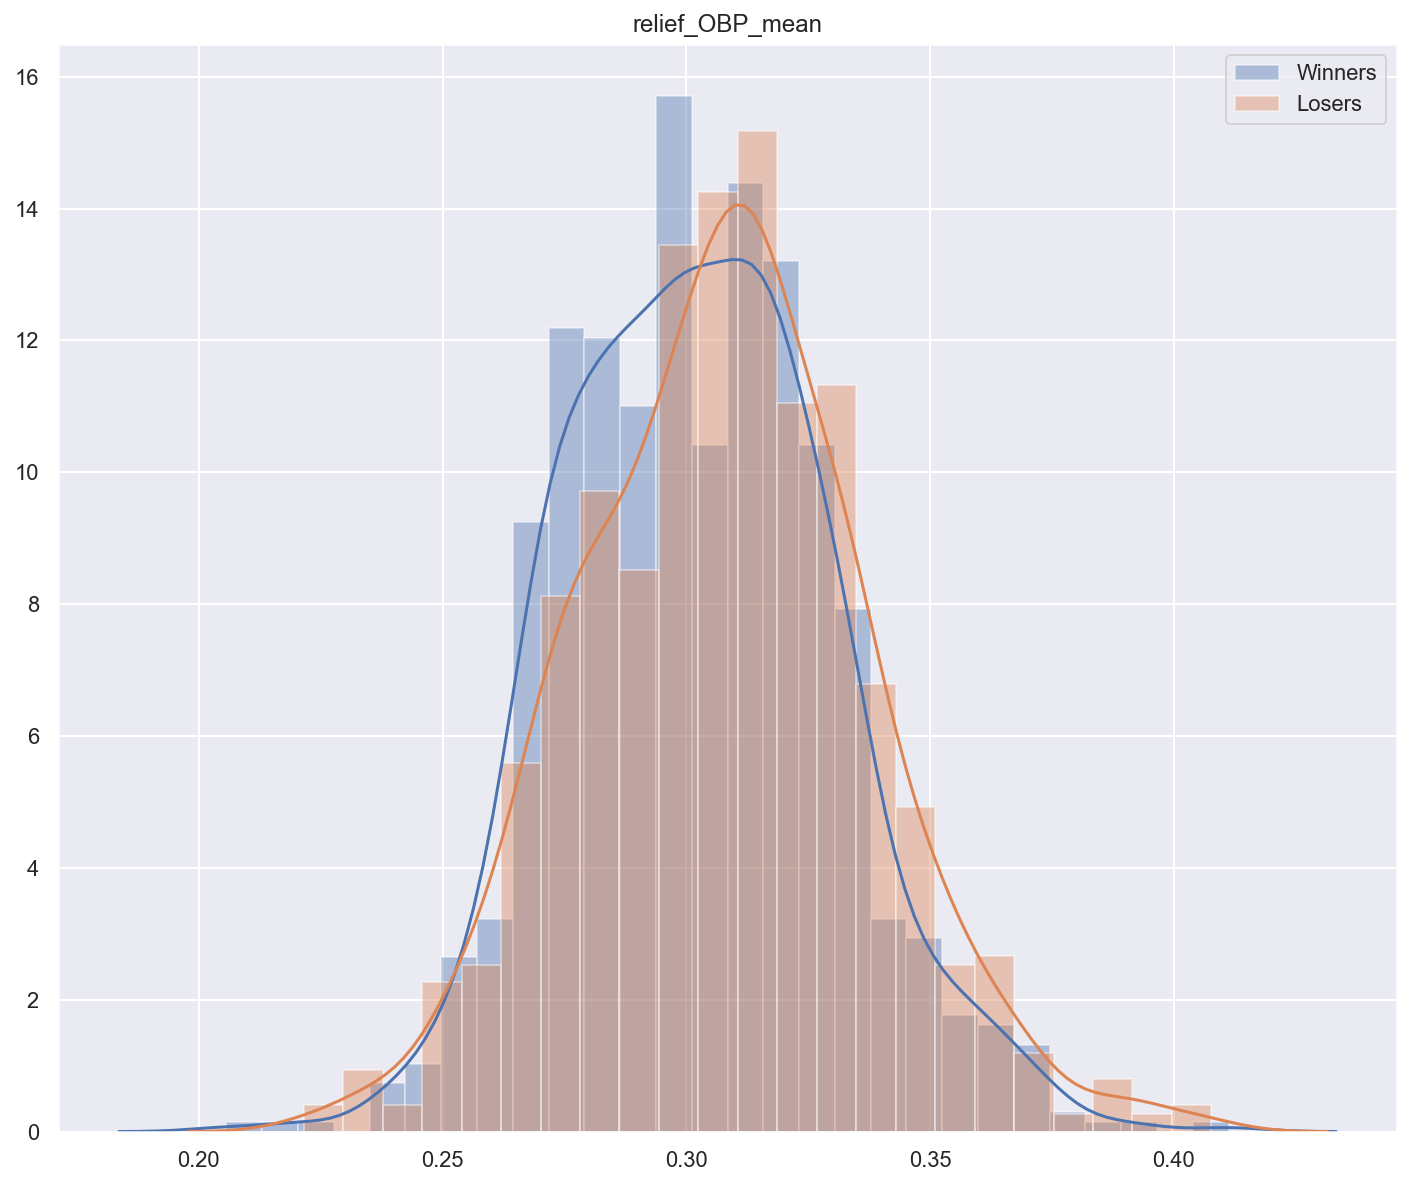

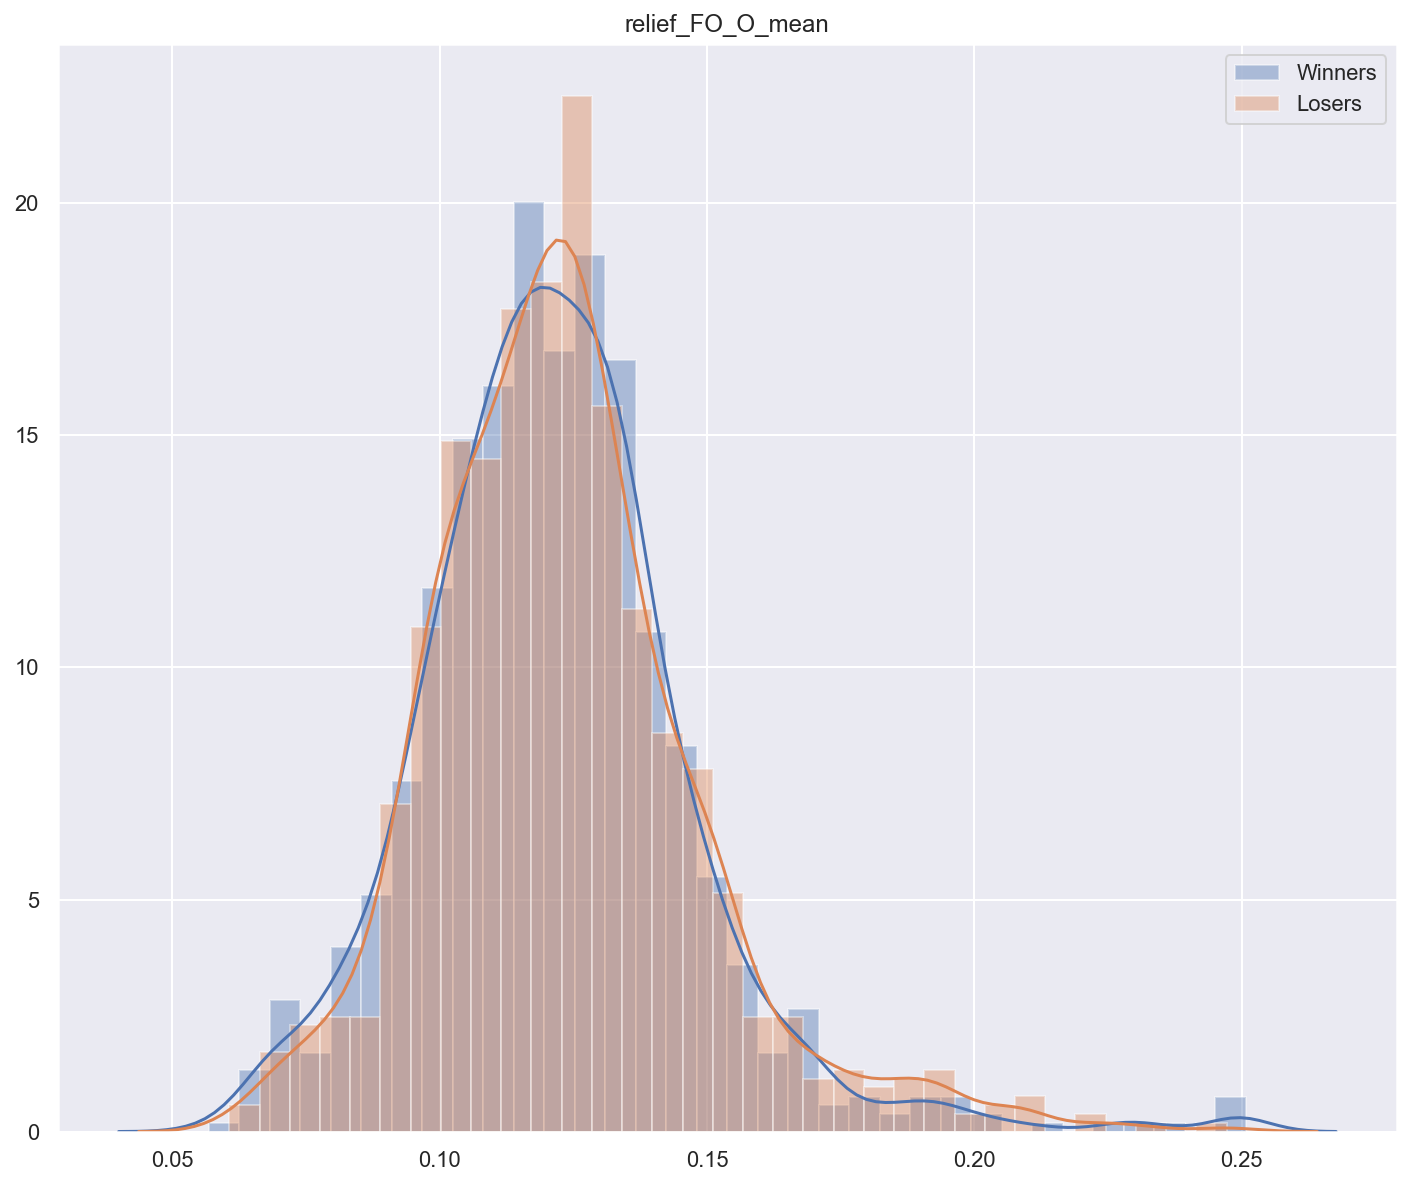

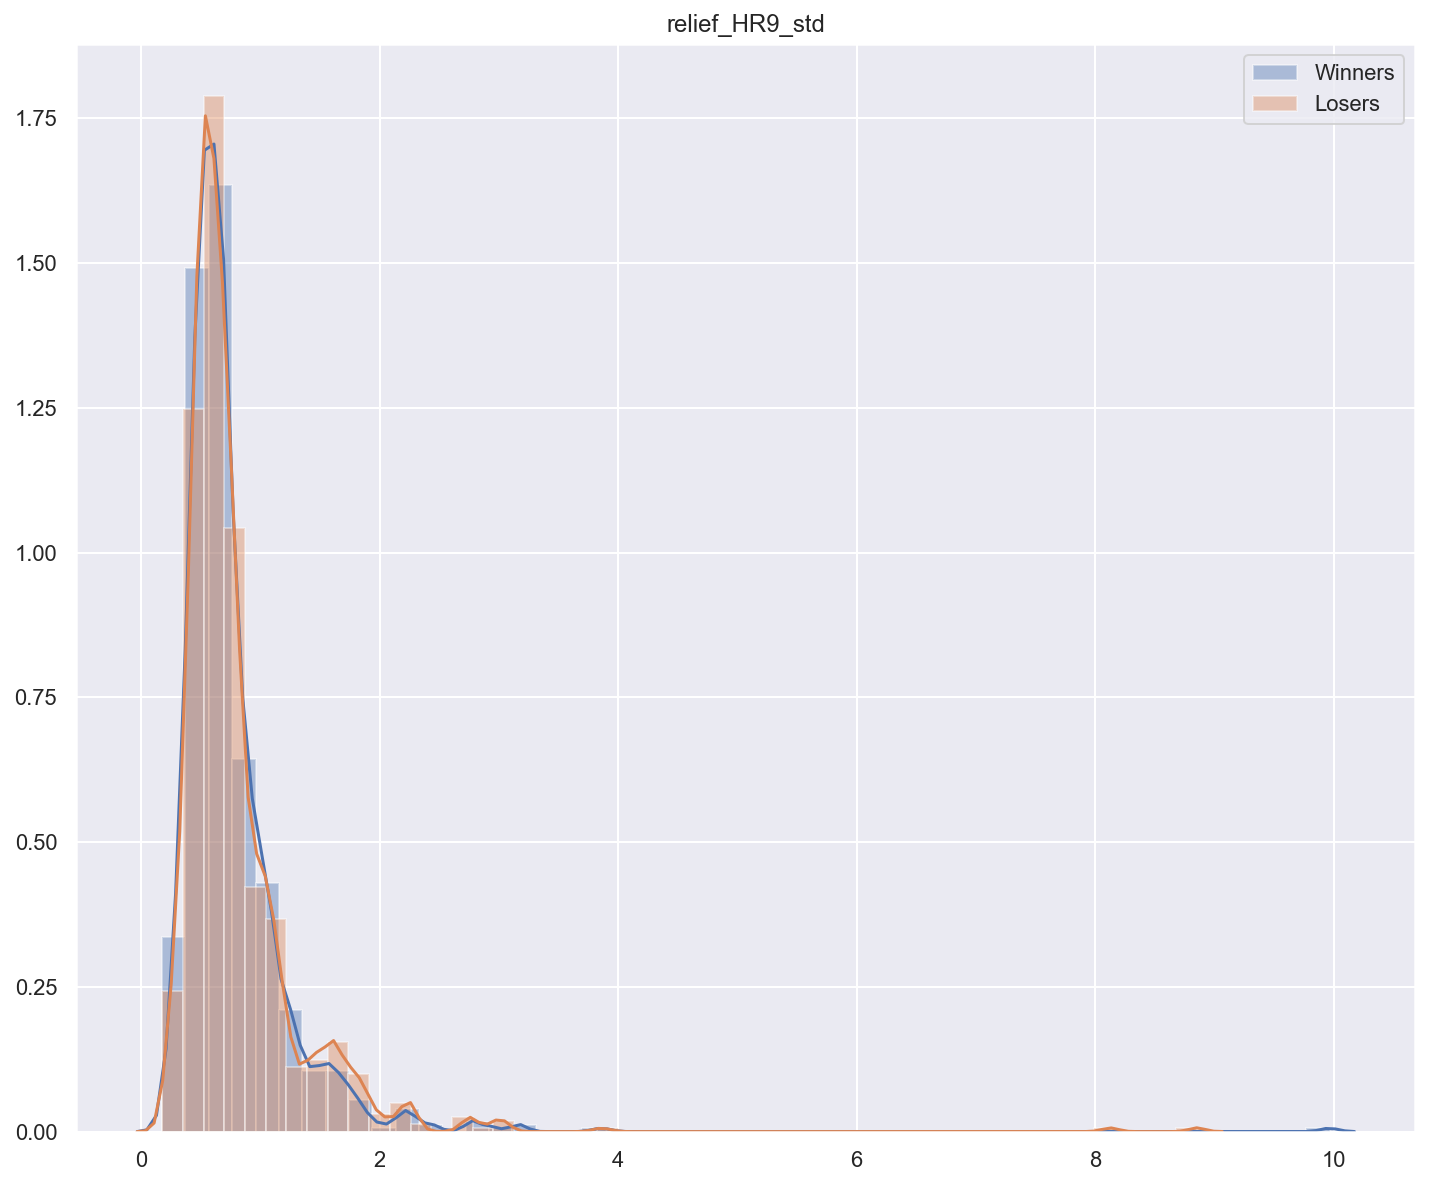

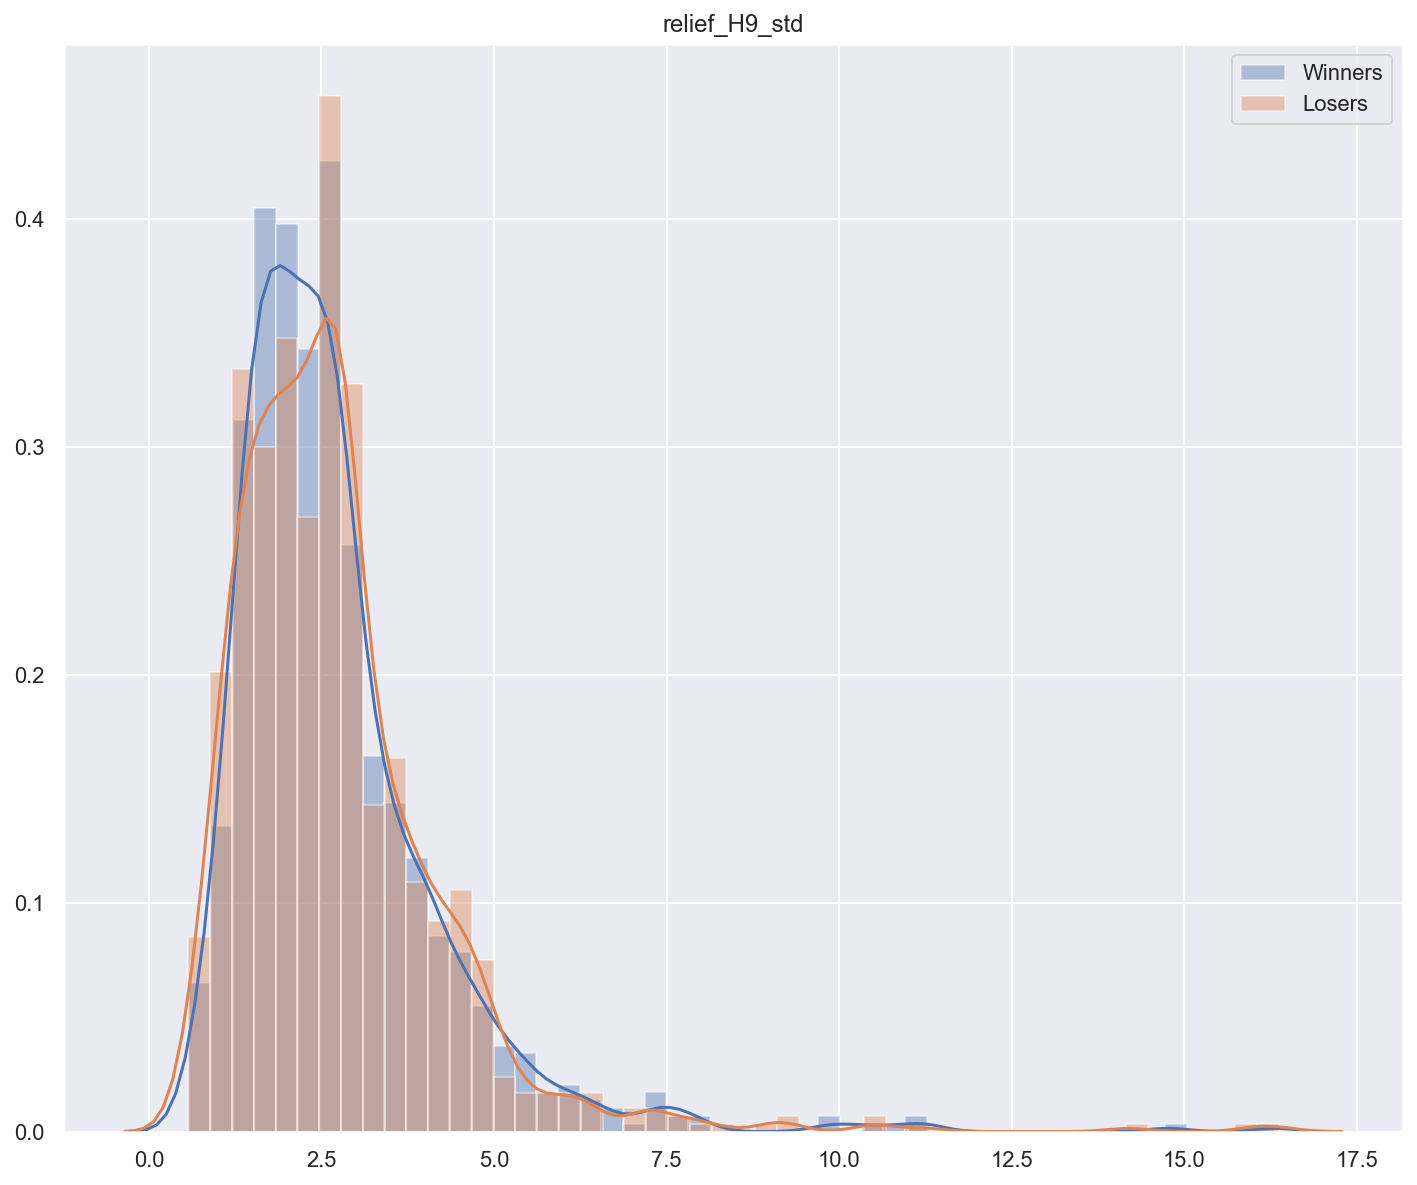

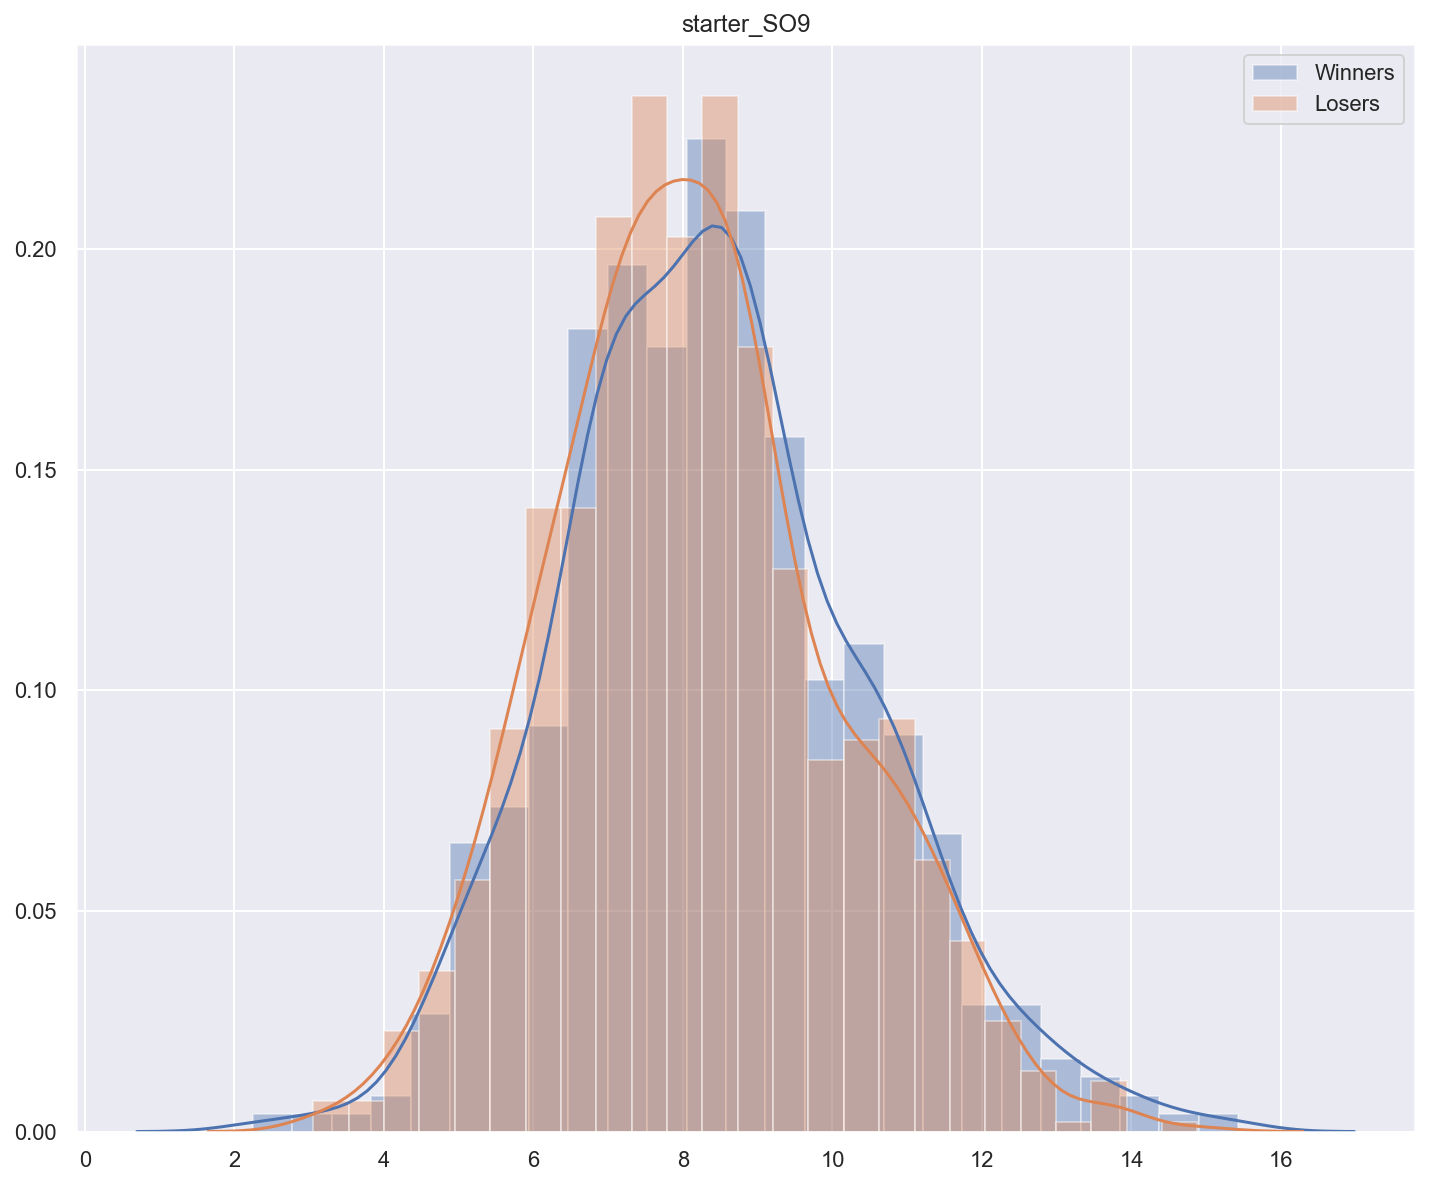

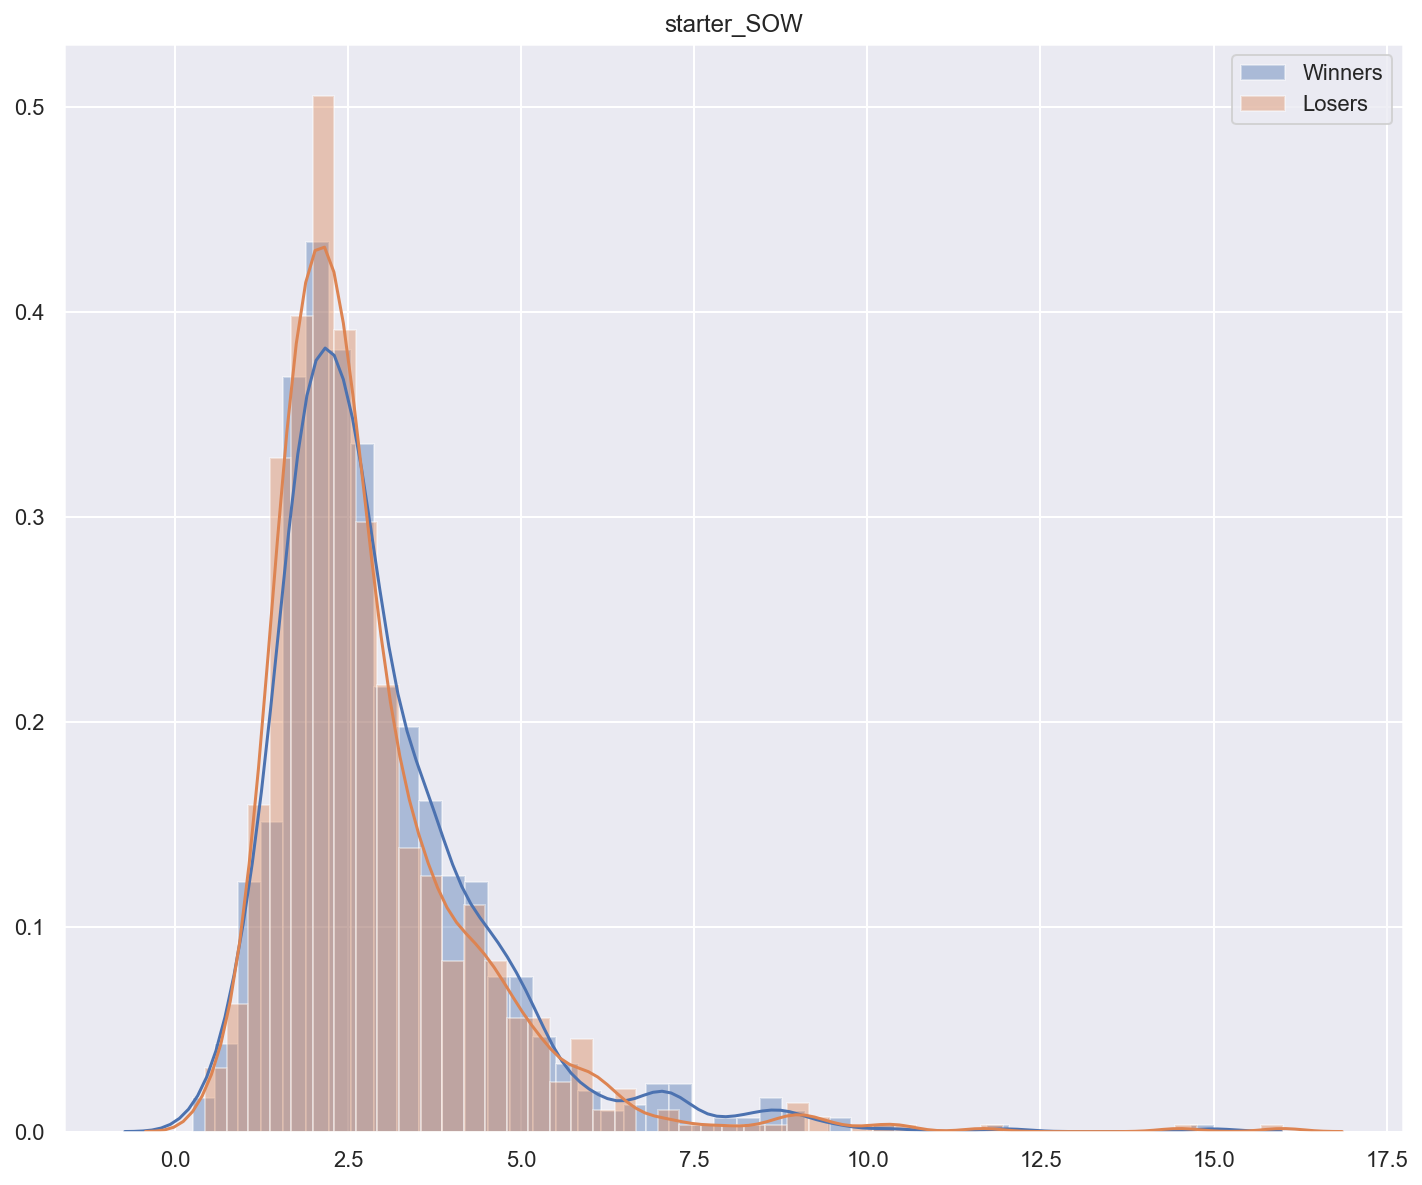

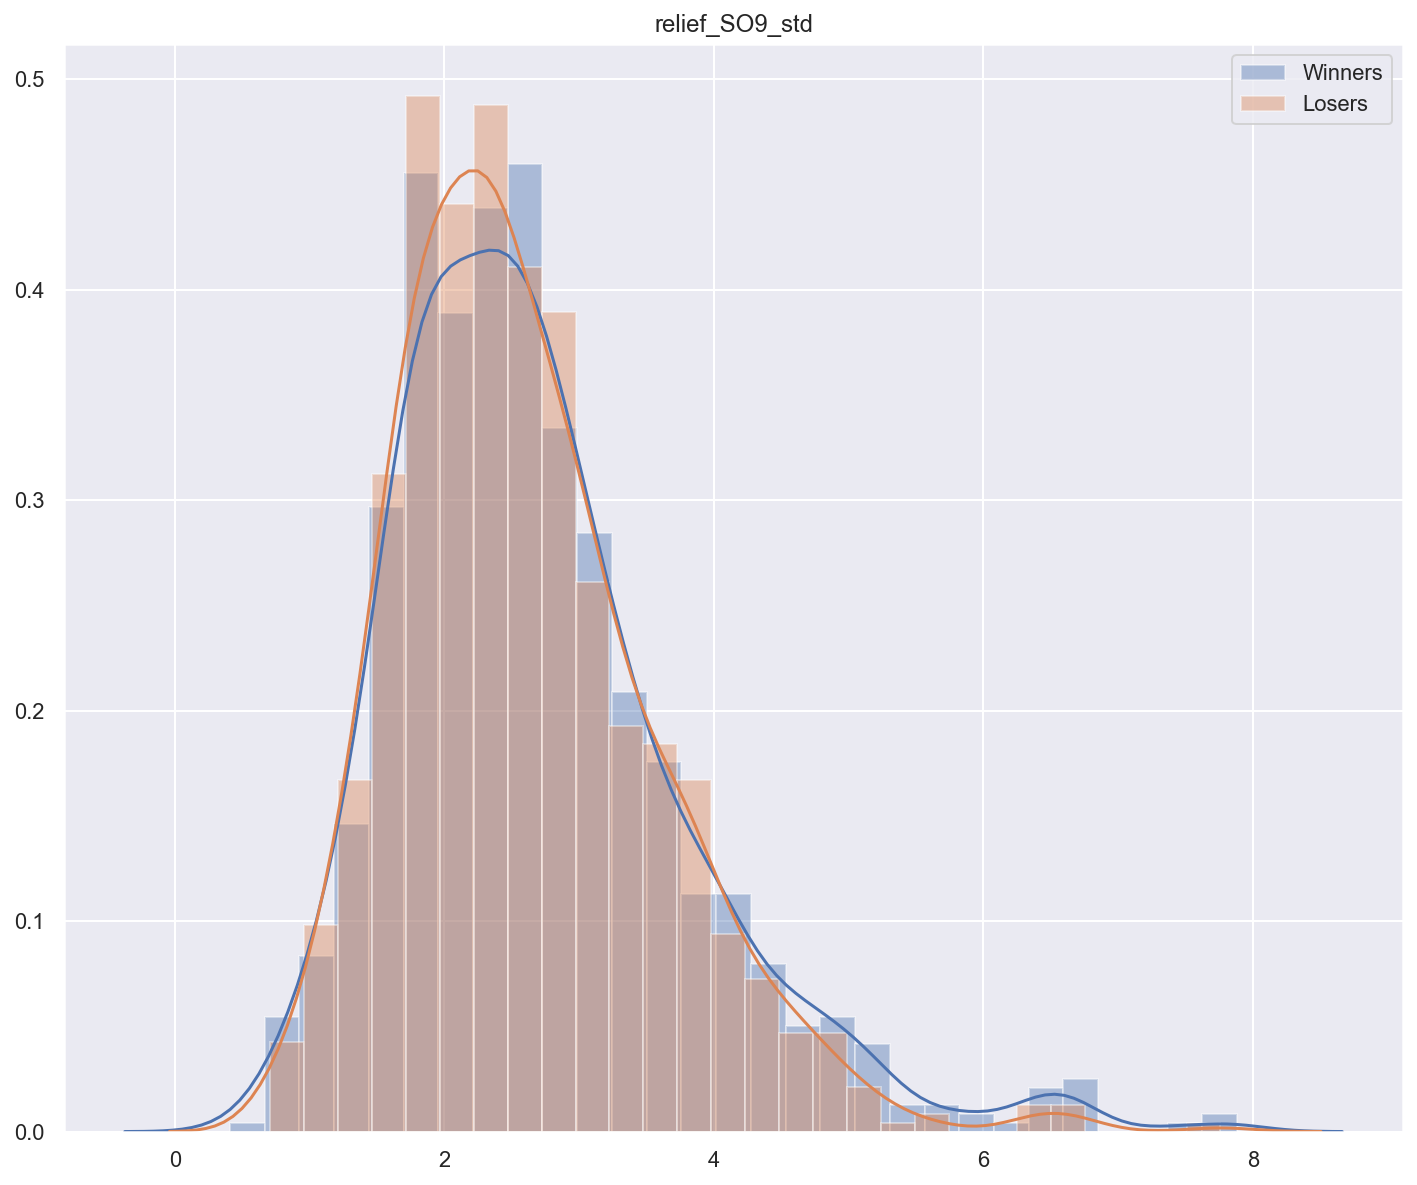

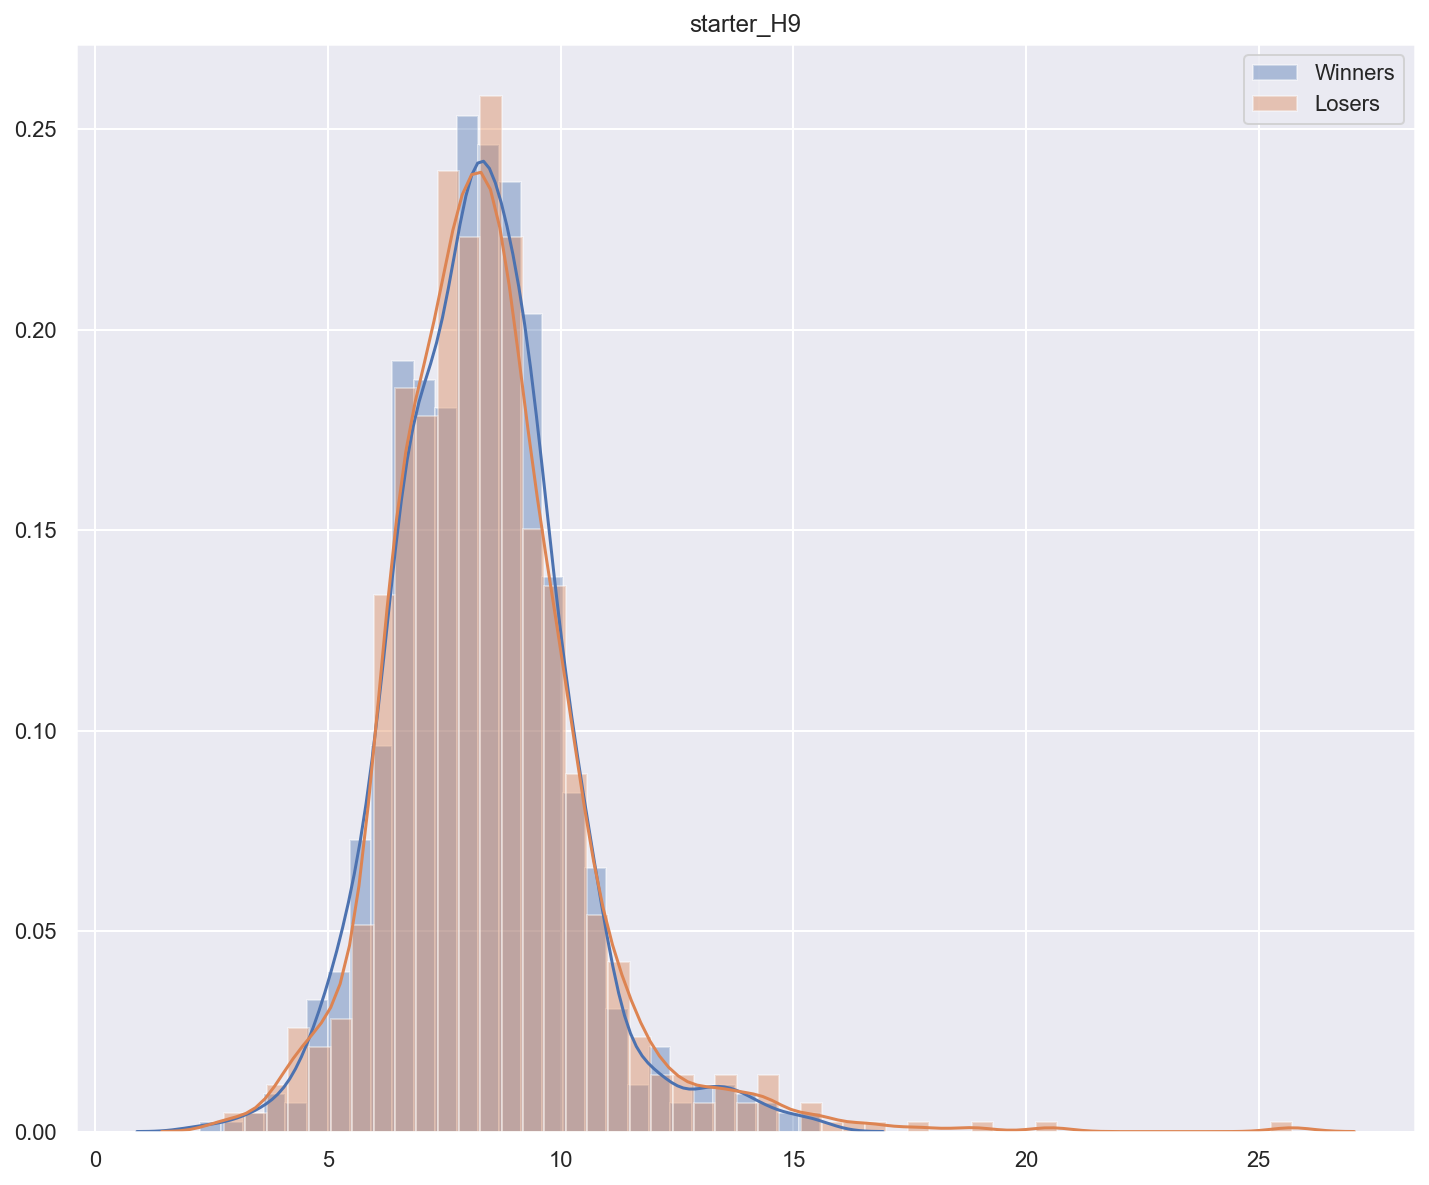

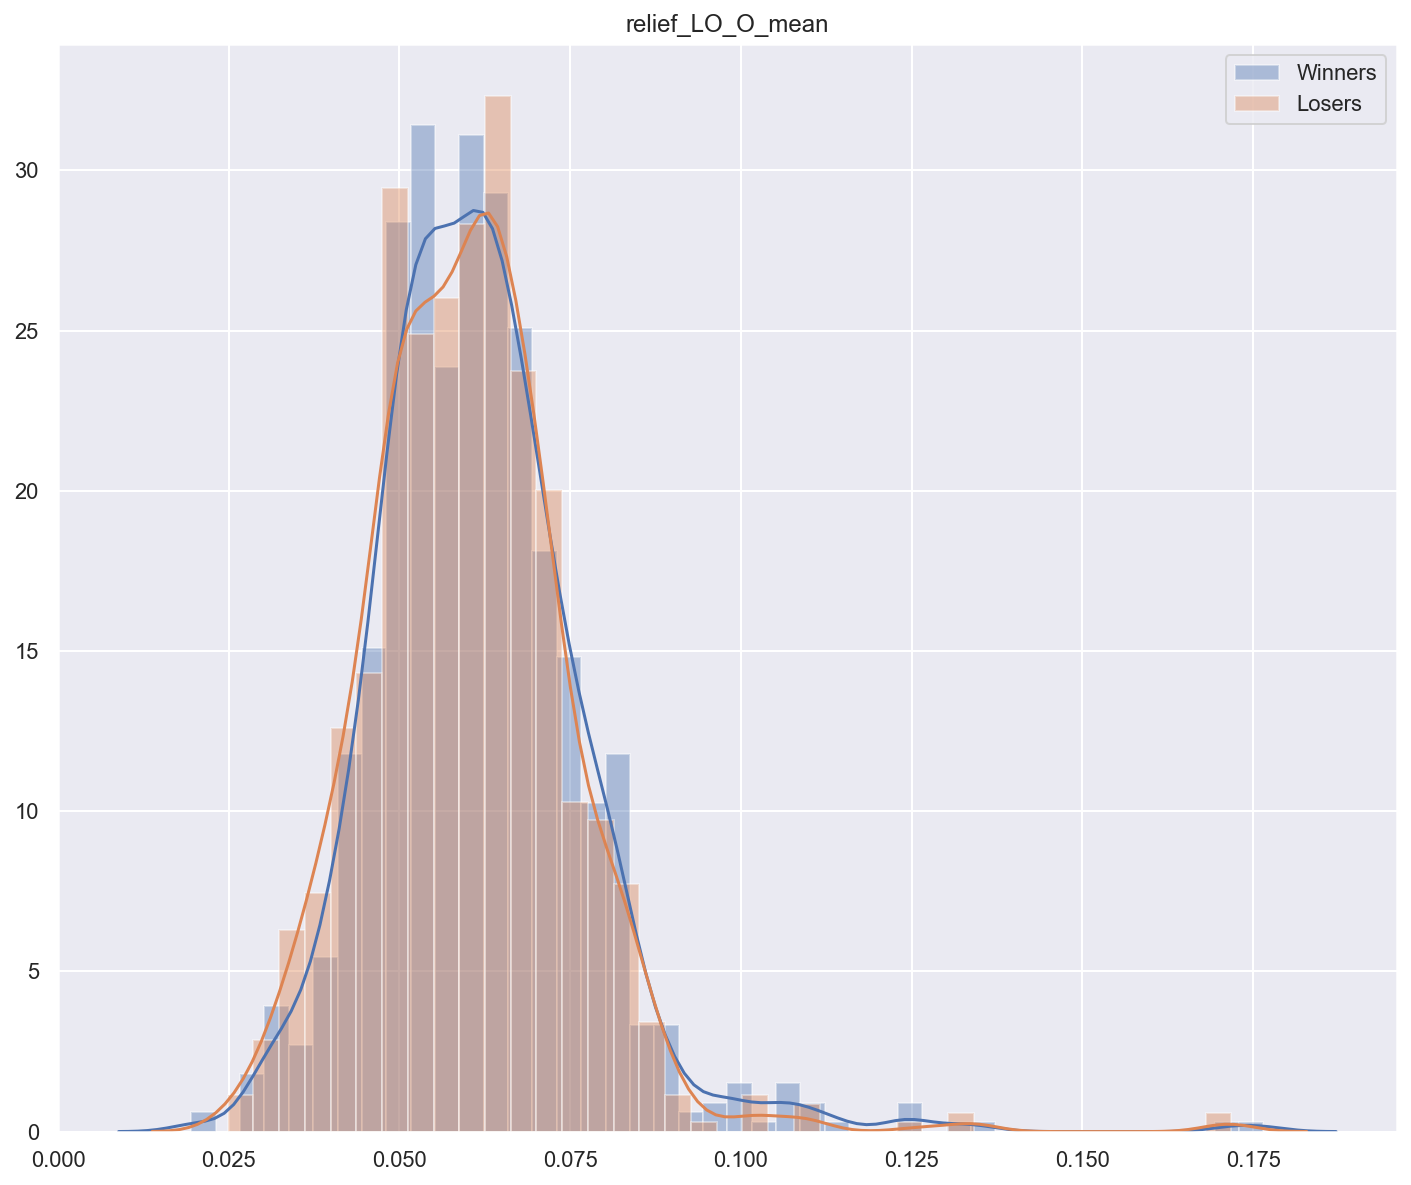

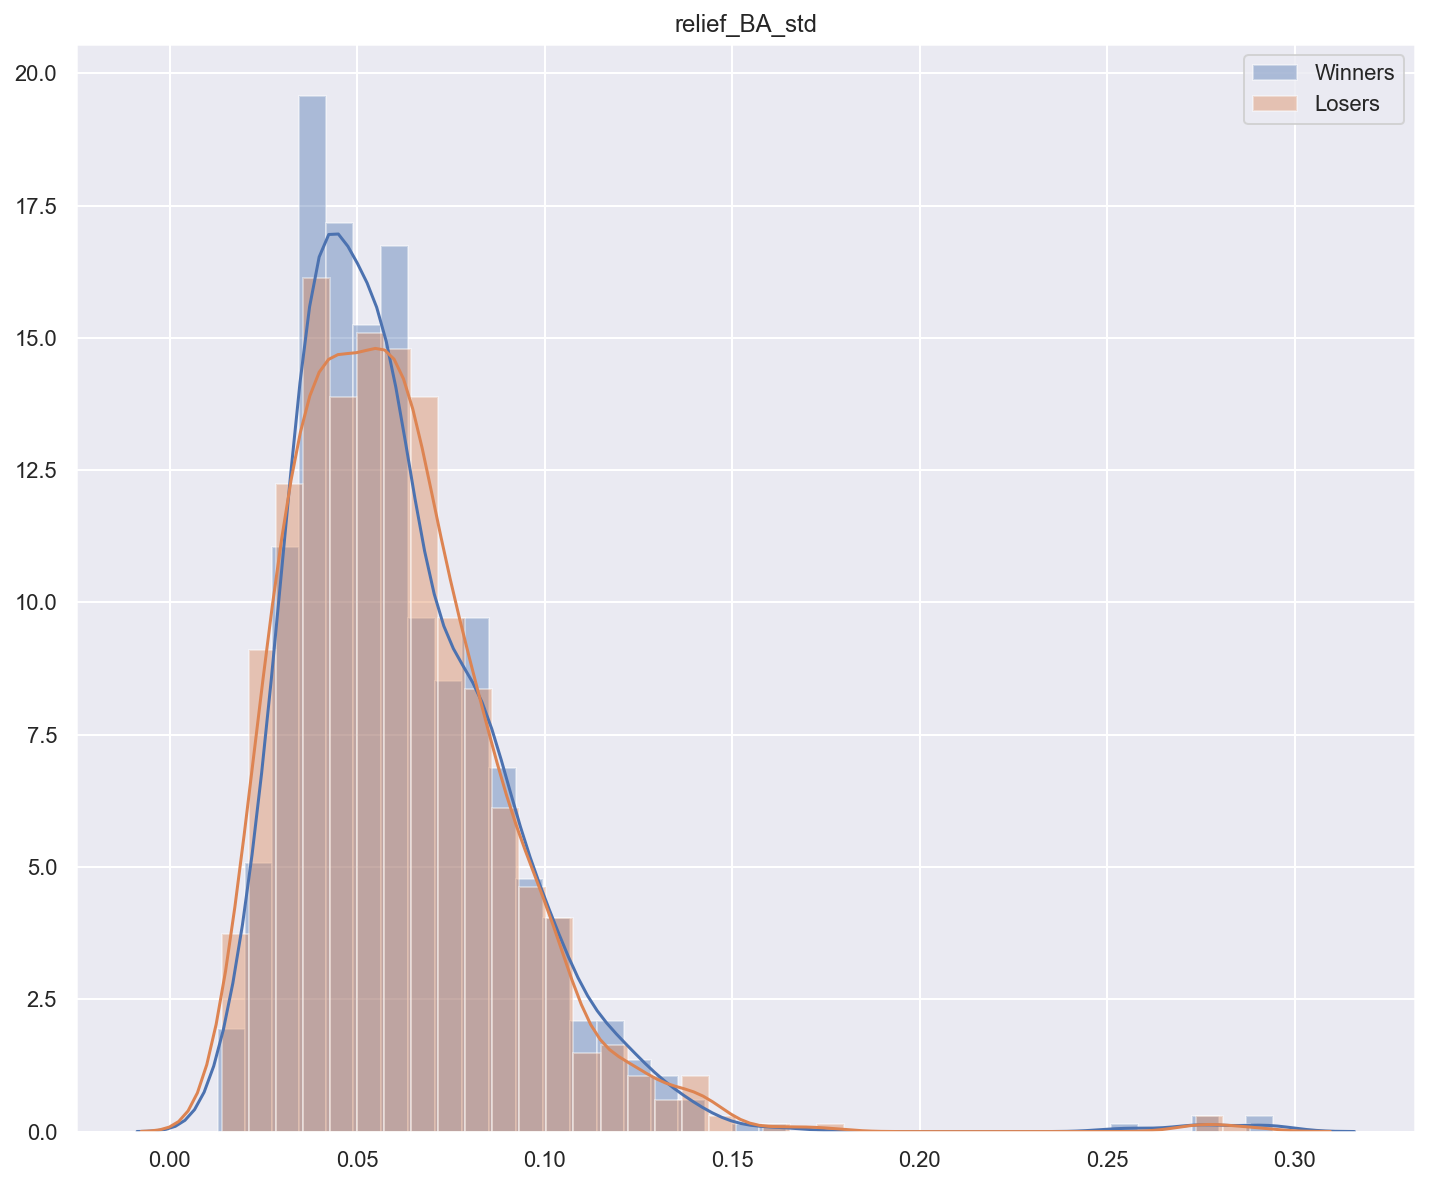

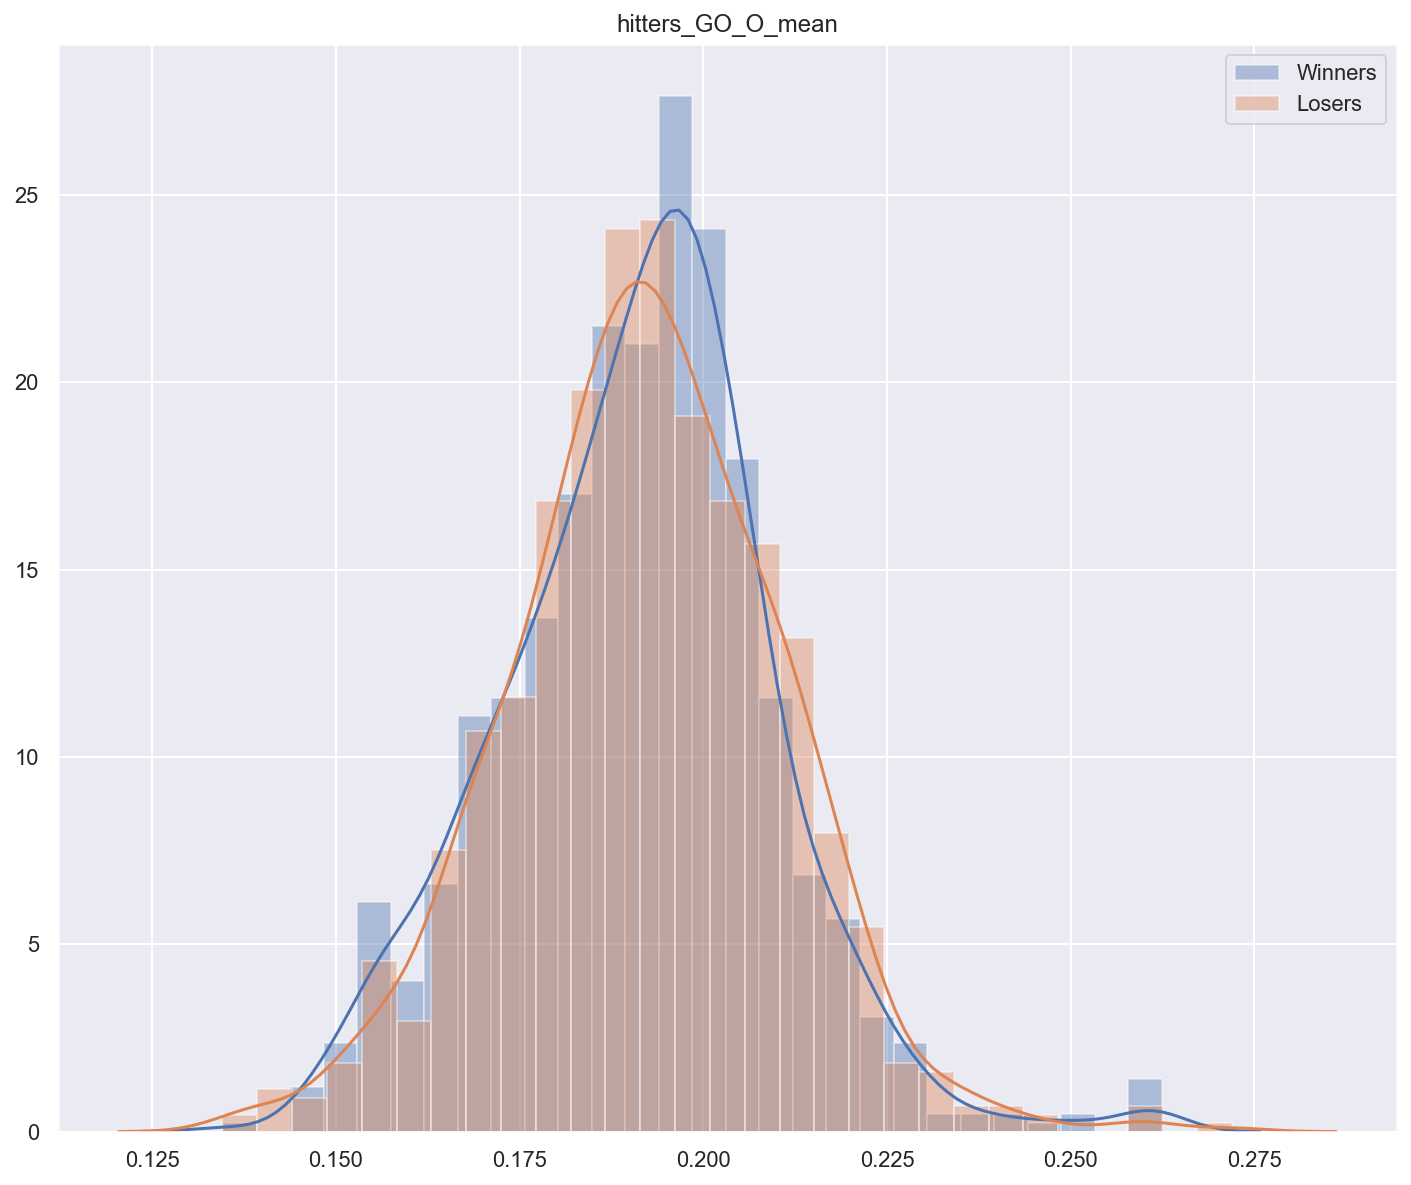

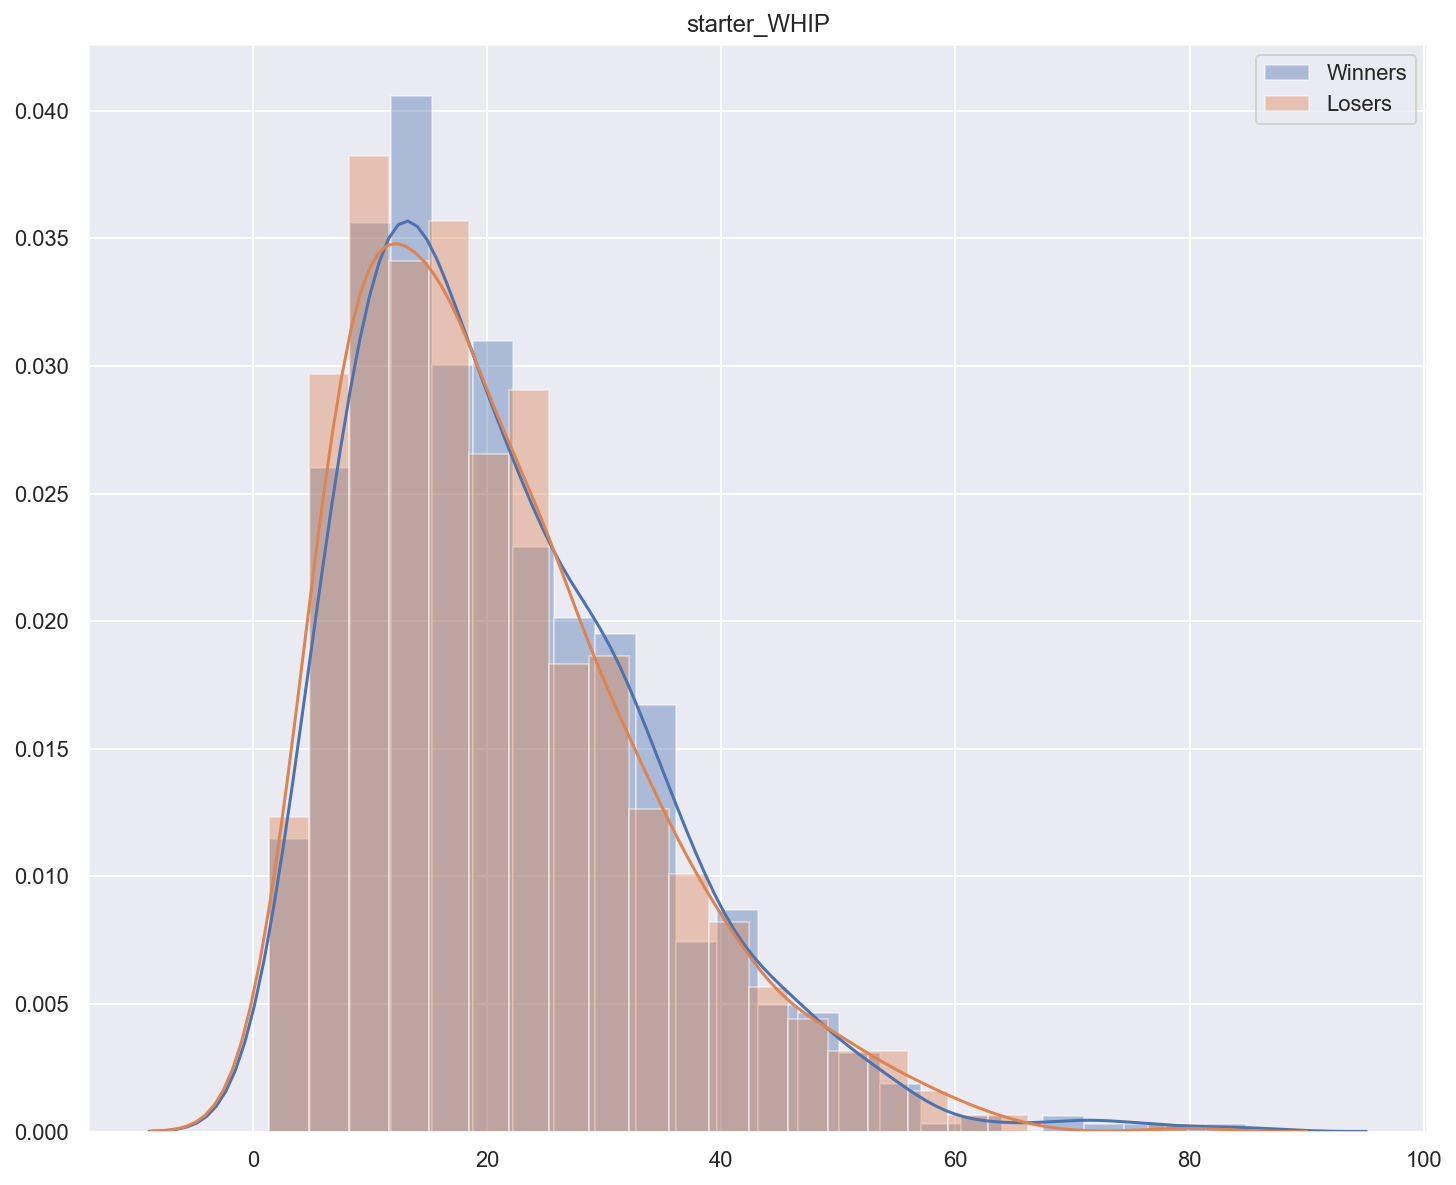

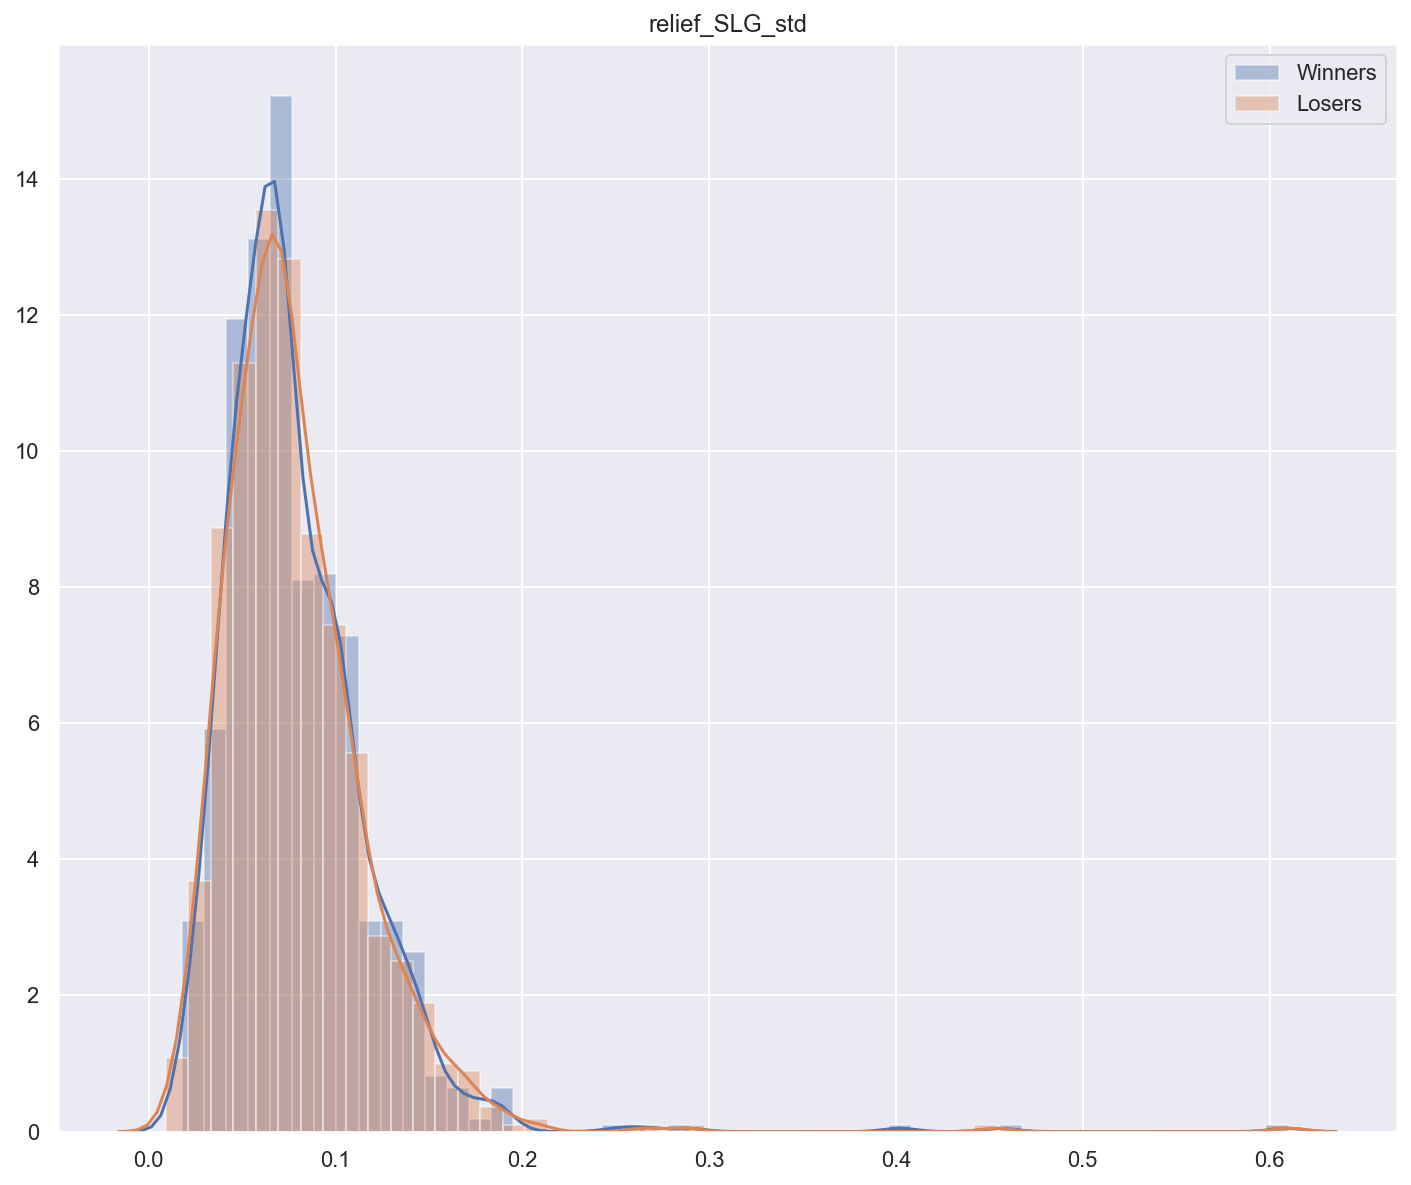

In [279]:
compare_stat_distro(df,stats)

In [218]:
kershaw=session.query(Person).filter(Person.fullName=='Clayton Kershaw').one()

In [381]:
kershaw.id

477132

In [235]:
def player_curr_avgs(session,person_record):
    most_recent_game=session.query(Game).order_by(Game.dateTime.desc()).first()
    player=person_record.relevant_stats(most_recent_game,session)
    player_dict={}
    if player['games']==0:
        player['games']=-1
    player_dict['position'] = player['Position_type']

    player_dict['PA_per_Game'] = player['PA']/player['games']

    try:
        player_dict['BA'] = player['hits']/player['AB']
    except ZeroDivisionError:
        player_dict['BA']=0

    try:
        player_dict['OBP'] = (
                                (player['hits']+player['walks']+player['HBP']+player['IBB'])
                                /
                                (player['AB']+player['walks']+player['HBP']+player['IBB']+player['sac'])
                              )
    except ZeroDivisionError:
        player_dict['OBP']=0

    try:
        player_dict['SLG'] = (
                                ((player['singles']*1)+(player['doubles']*2)+
                                (player['triples']*1)+(player['home_runs']*1))
                                /
                                (player['AB'])
                              )
    except ZeroDivisionError:
        player_dict['SLG']=0

    if player['walks']+player['HBP']>0:
        player_dict['SOW'] = player['strikeouts']/(player['walks']+player['HBP'])
    else:
        player_dict['SOW'] = 0

    try:
        player_dict['H9'] = 9*player['hits']/player['IP']
        player_dict['HR9'] = 9*player['home_runs']/player['IP']
        player_dict['SO9'] = 9*player['strikeouts']/player['IP']
        player_dict['WHIP'] = player['walks']+player['HBP']+player['hits']/player['IP']
    except (ZeroDivisionError,KeyError):
        player_dict['H9'] = 0
        player_dict['HR9'] = 0
        player_dict['SO9'] = 0
        player_dict['WHIP'] = 0

    # proportion of groundouts, flyouts, popouts, lineouts to ABs
    if player['AB']>0:
        player_dict['GO_O'] = player['GO']/player['AB']
        player_dict['FO_O'] = player['FO']/player['AB']
        player_dict['PO_O'] = player['PO']/player['AB']
        player_dict['LO_O'] = player['LO']/player['AB']
    else:
        player_dict['GO_O'] = 0
        player_dict['FO_O'] = 0
        player_dict['PO_O'] = 0
        player_dict['LO_O'] = 0
    return player_dict

In [240]:
kershaw_avgs=player_curr_avgs(session,kershaw)

In [222]:
session.query(Game).order_by(Game.dateTime.desc()).first()

<Game(pk='599377',id='2019/10/30/wasmlb-houmlb-1')>

In [237]:
kershaw_stats=kershaw.relevant_stats(session.query(Game).first(),session)

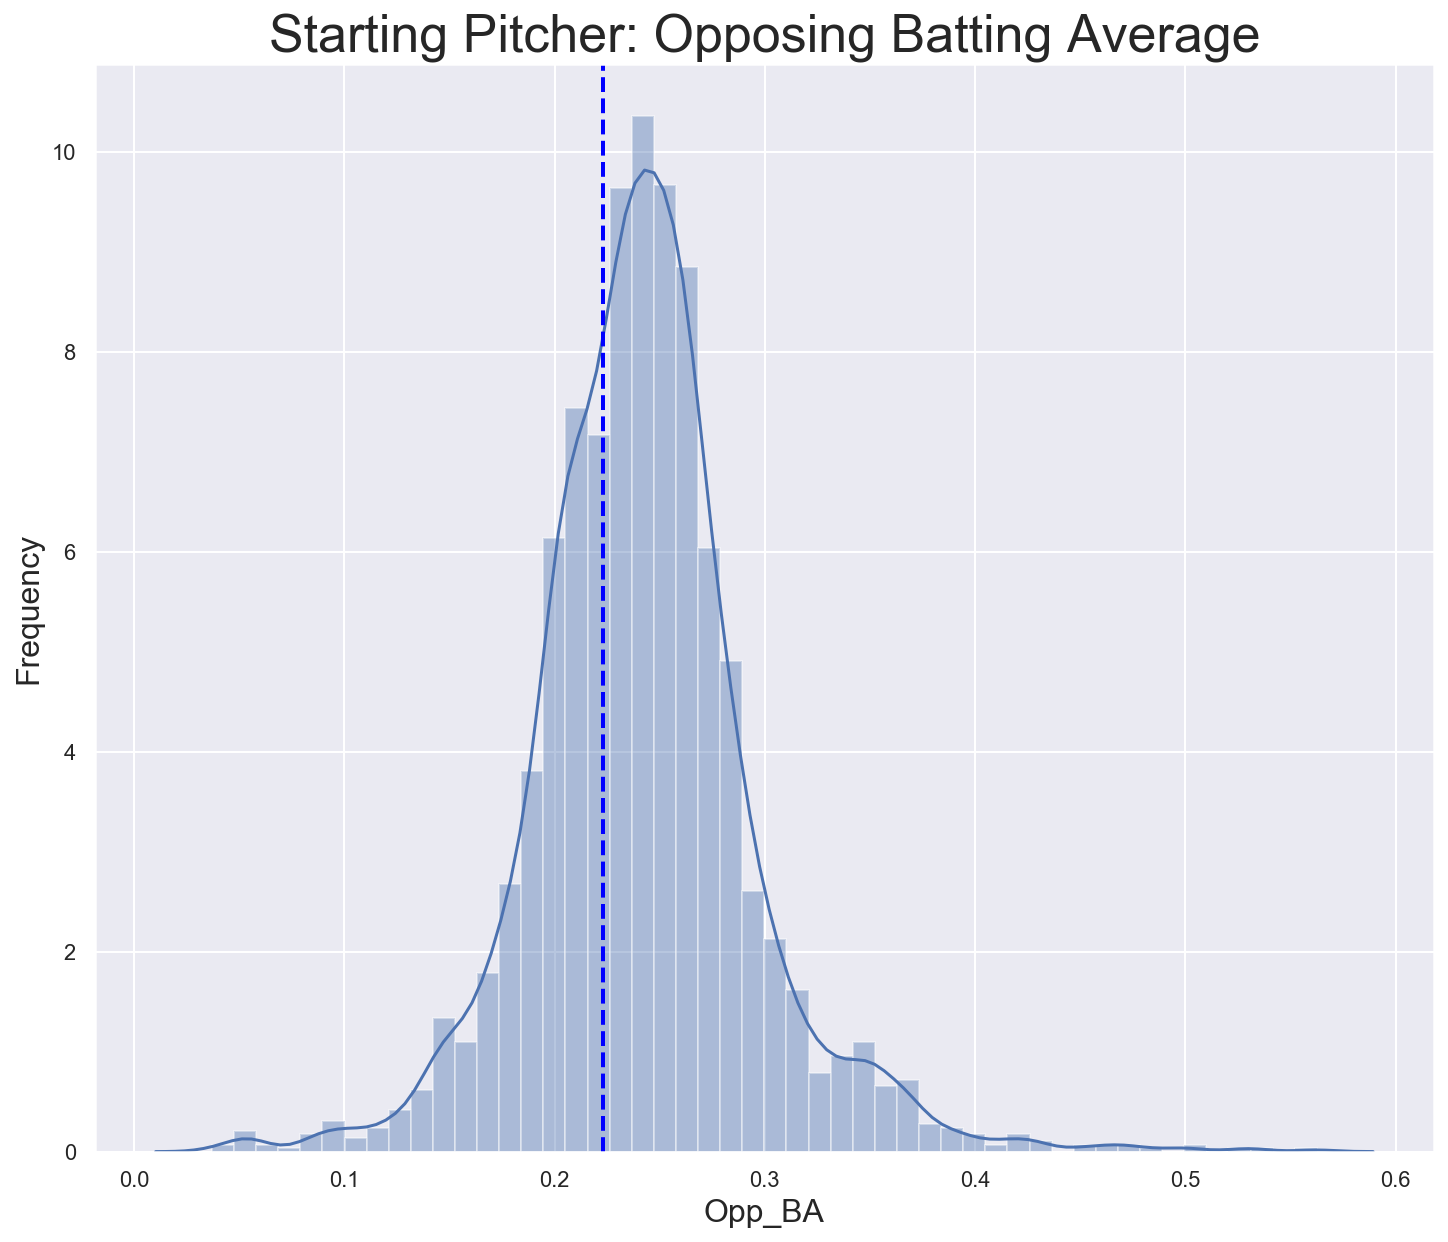

In [243]:
nonZero_homeStarterBa=[x for x in df['home_starter_BA'] if x>0]
nonZero_awayStarterBa=[x for x in df['away_starter_BA'] if x>0]
nonZero_starterBa=[item for sublist in [nonZero_awayStarterBa,nonZero_homeStarterBa] for item in sublist]

sns.distplot(nonZero_starterBa)
plt.title('Starting Pitcher: Opposing Batting Average',fontdict={'fontsize':26})
plt.xlabel('Opp_BA',fontdict={'fontsize':16})
plt.ylabel('Frequency',fontdict={'fontsize':16})
plt.savefig(image_dir+'SP_OBA.jpg')

plt.axvline(kershaw_avgs['BA'],color='blue', linestyle='--', lw=2)

plt.show()

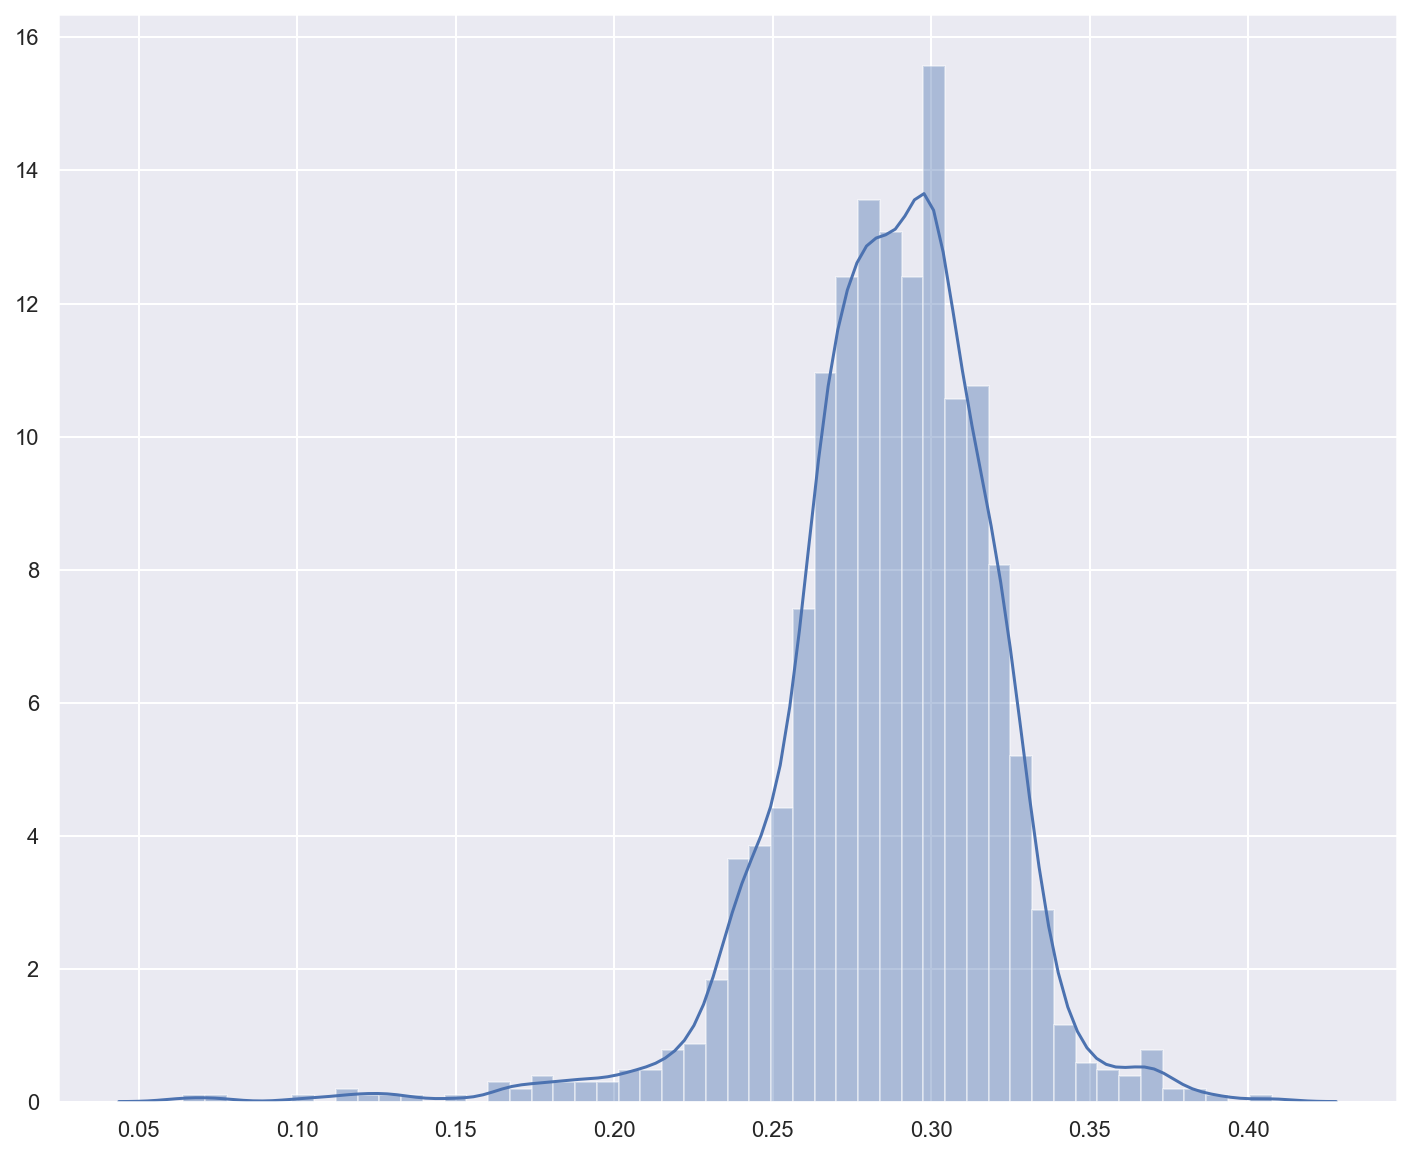

In [242]:
sns.distplot([x for x in df['home_hitters_SLG_mean'] if x>0])

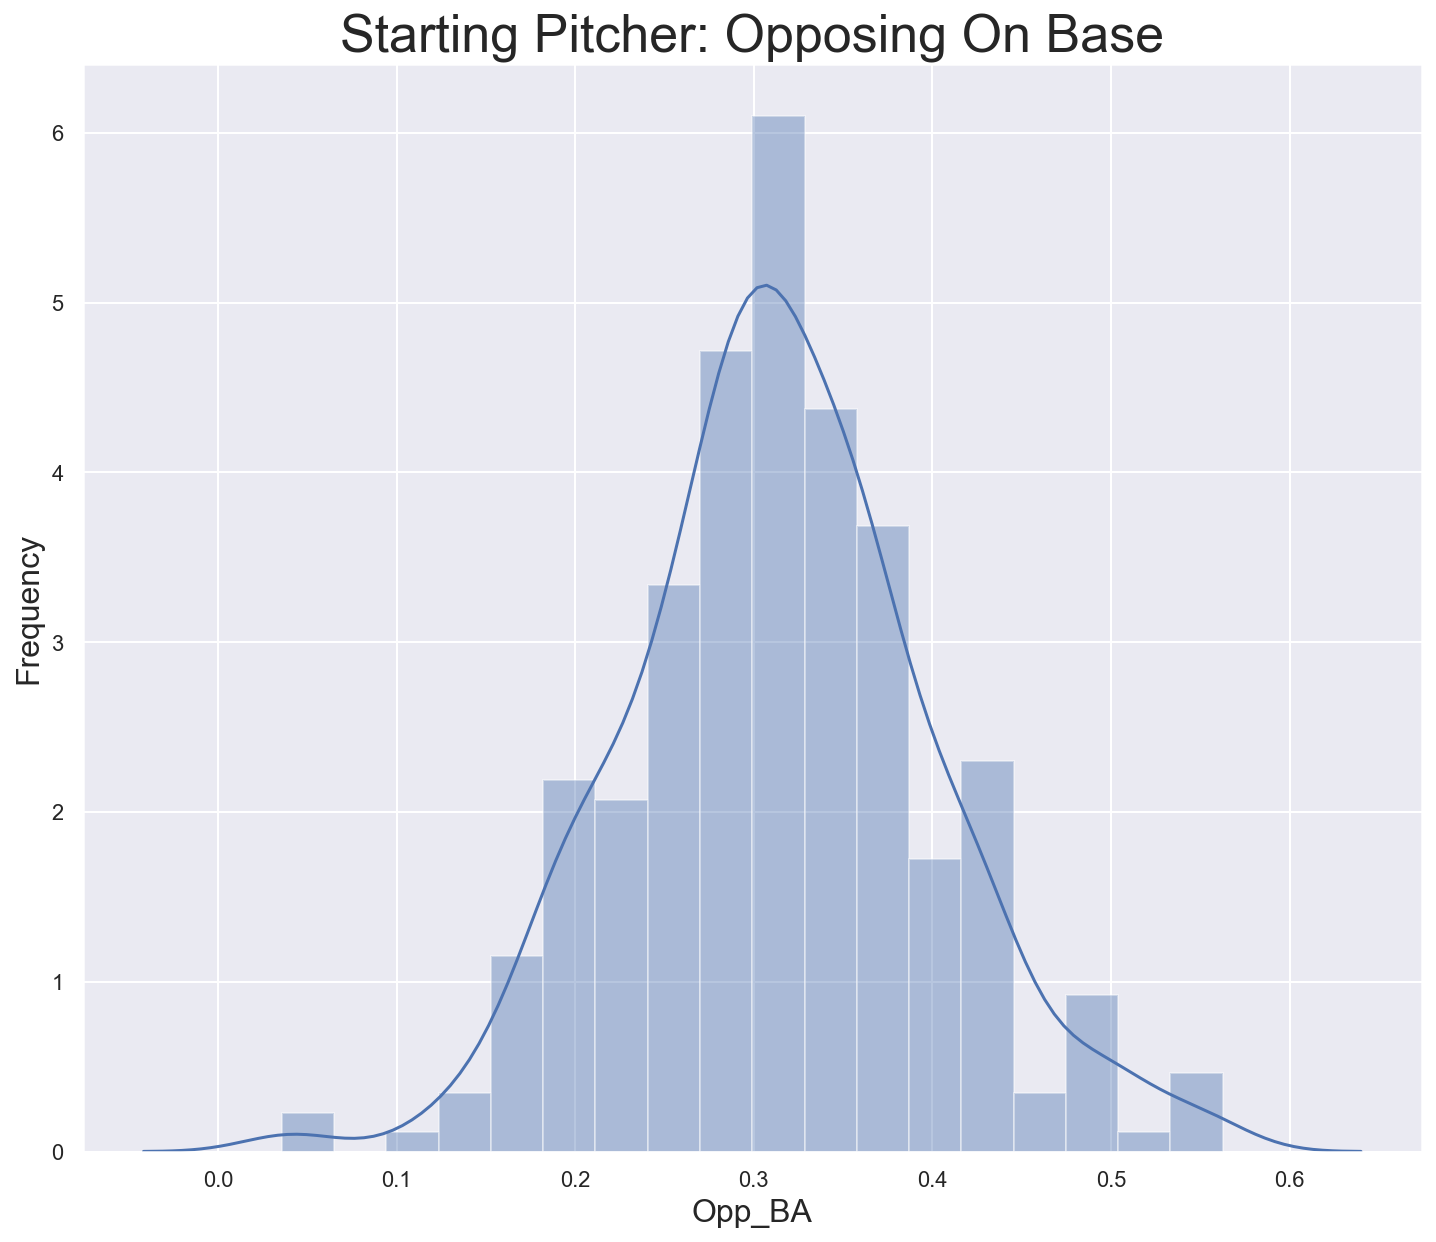

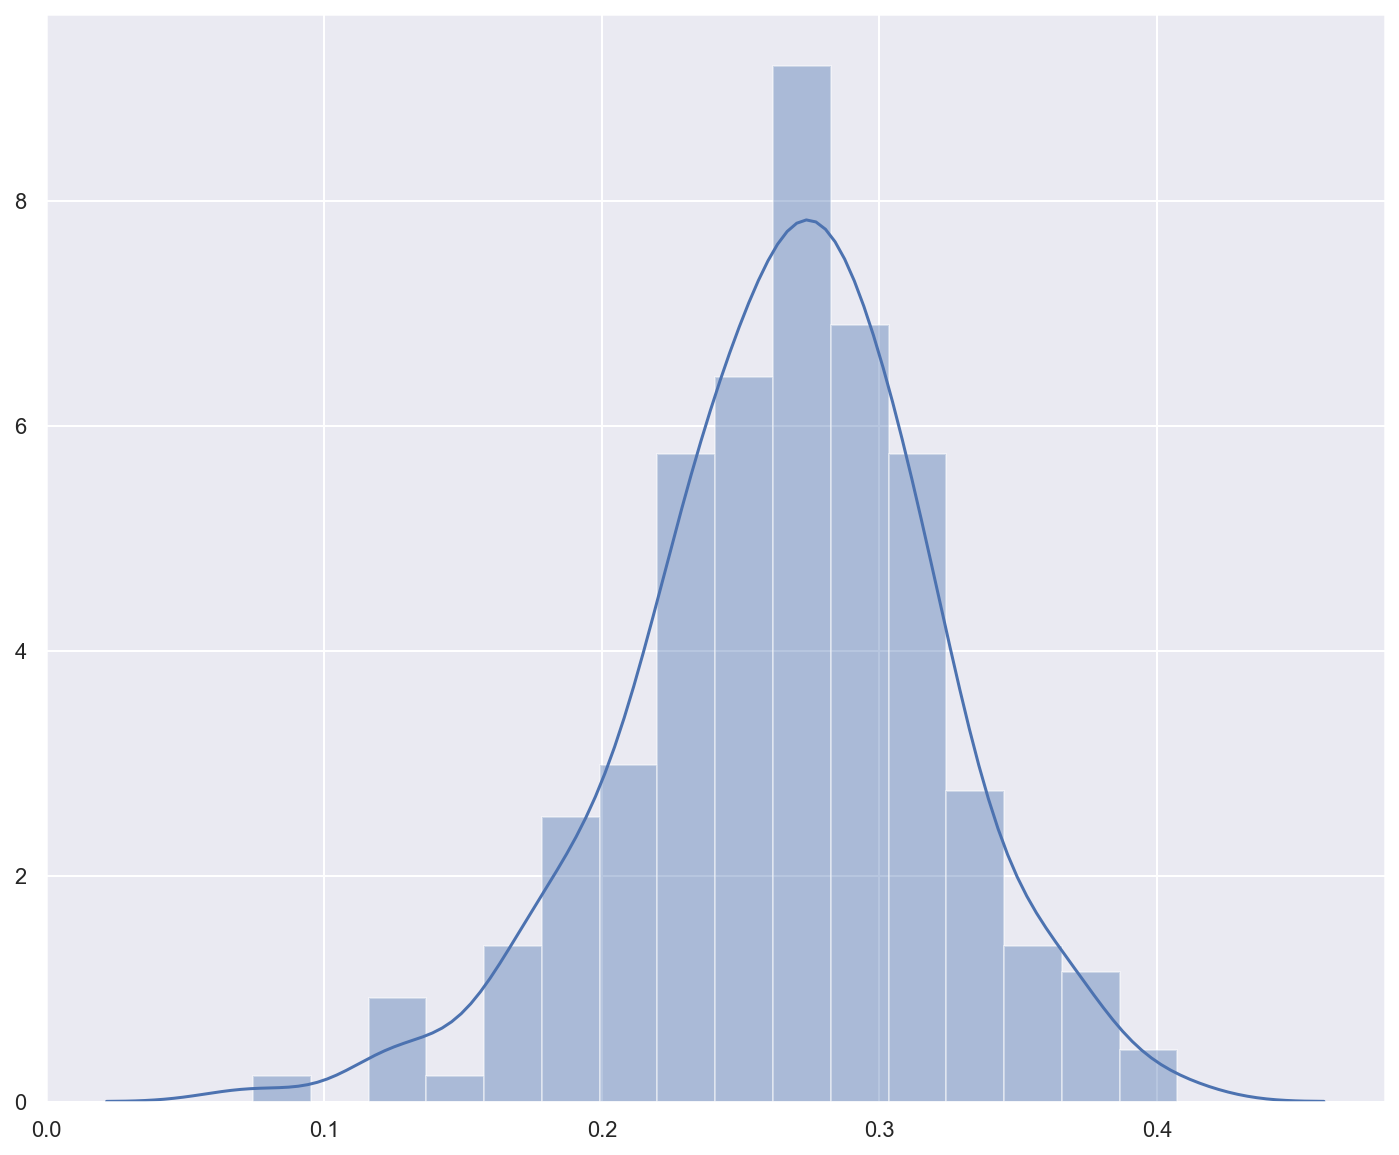

In [165]:
nonZero_homeStarterOBP=[x for x in df['home_starter_OBP'] if x>0]
nonZero_awayStarterOBP=[x for x in df['away_starter_OBP'] if x>0]
nonZero_starterOBP=[item for sublist in [nonZero_awayStarterOBP,nonZero_homeStarterOBP] for item in sublist]

sns.distplot(nonZero_starterOBP)
plt.title('Starting Pitcher: Opposing On Base',fontdict={'fontsize':26})
plt.xlabel('Opp_BA',fontdict={'fontsize':16})
plt.ylabel('Frequency',fontdict={'fontsize':16})
plt.savefig(image_dir+'SP_OBP.jpg')
plt.show()


sns.distplot([x for x in df['home_hitters_SLG_mean'] if x>0])

In [42]:
home_starter_pag = [x for x in df['home_starter_PA_per_Game'] if x>0]
away_starter_pag = [x for x in df['away_starter_PA_per_Game'] if x>0]
starter_pag = [item for sublist in [home_starter_pag,away_starter_pag] for item in sublist]

home_rel_pag = [x for x in df['home_relief_PA_per_Game_mean'] if x>0]
away_rel_pag = [x for x in df['away_relief_PA_per_Game_mean'] if x>0]
rel_pag = [item for sublist in [away_rel_pag,home_rel_pag] for item in sublist]

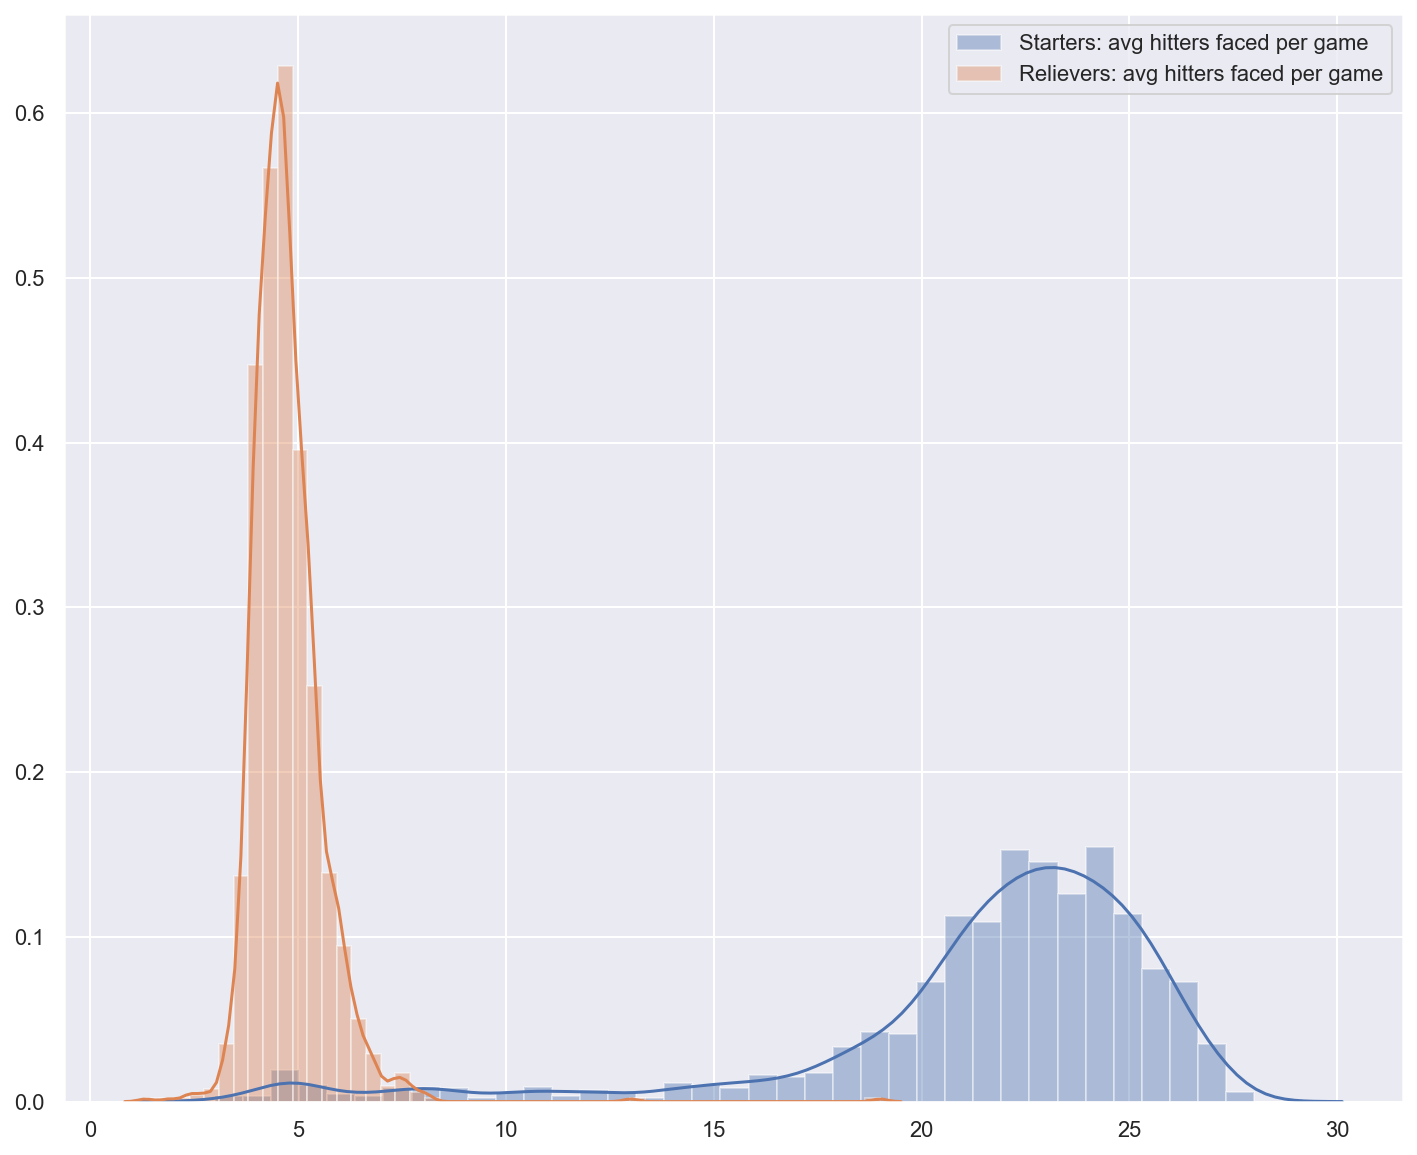

In [45]:
sns.distplot(starter_pag,label='Starters: avg hitters faced per game')
sns.distplot(rel_pag,label='Relievers: avg hitters faced per game')

plt.legend()
plt.savefig(image_dir+"pa_g.jpg")

In [47]:
home_hitters_stats = [x for x in df.columns.tolist() if 'home_hitters' in x and 'std' not in x]

In [48]:
home_hitters_stats

['home_hitters_BA_mean',
 'home_hitters_SLG_mean',
 'home_hitters_OBP_mean',
 'home_hitters_PA_per_Game_mean',
 'home_hitters_GO_O_mean',
 'home_hitters_FO_O_mean',
 'home_hitters_PO_O_mean',
 'home_hitters_LO_O_mean']

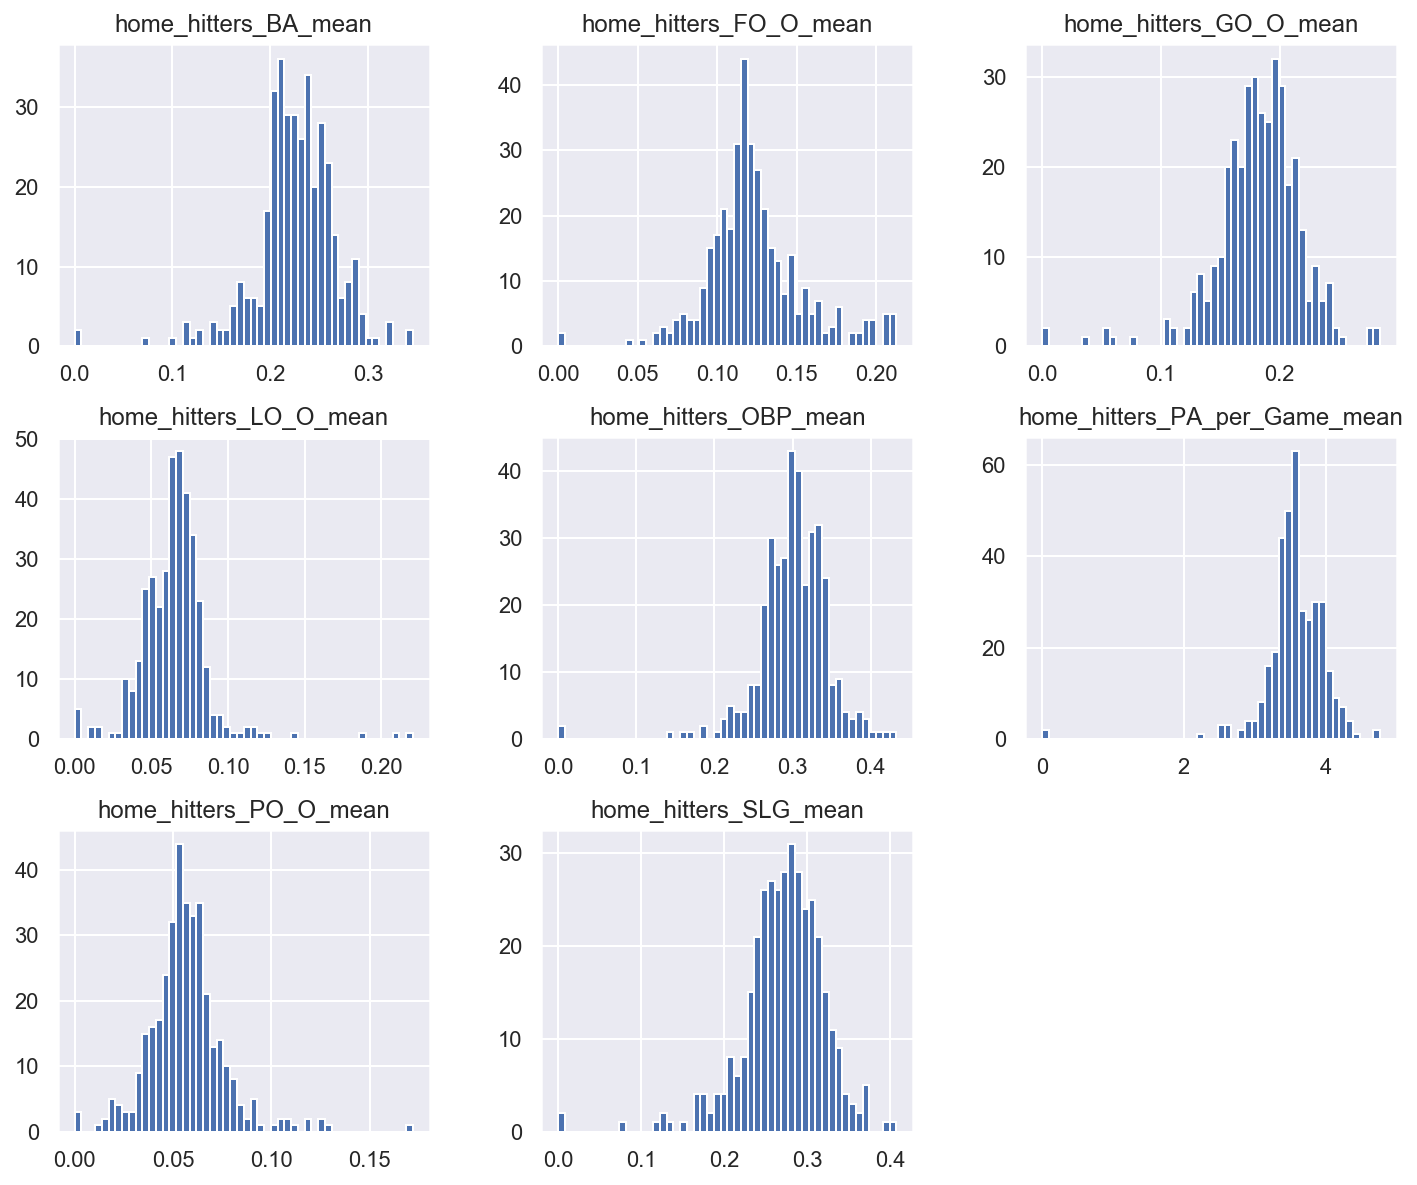

In [178]:
df[home_hitters_stats].hist(bins=50,figsize=(12,10))
plt.savefig(image_dir+'hitter_stats.jpg')
plt.show()


In [284]:
game_table=session.execute("""select 
    id,dayNight,
    temp,wind,
    `condition`,
    venue_id,
    home_probablePitcher,
    away_probablePitcher,
    gameNumber,doubleHeader,
    season,homeTeam_id,
    awayTeam_id
from 
    MLB_Stats.games g
where
    g.`type`='R';""").fetchall()

In [285]:
game_table

[('2018/03/29/anamlb-oakmlb-1', 'day', 73, '2 mph, Out To RF', 'Partly Cloudy', 10, 608665, 572070, 1, 'N', 2018, 133, 108),
 ('2018/03/29/bosmlb-tbamlb-1', 'day', 72, '0 mph, None', 'Dome', 12, 502042, 519242, 1, 'N', 2018, 139, 111),
 ('2018/03/29/chamlb-kcamlb-1', 'day', 45, '10 mph, L To R', 'Overcast', 7, 518633, 448306, 1, 'N', 2018, 118, 145),
 ('2018/03/29/chnmlb-miamlb-1', 'day', 75, '16 mph, In From RF', 'Partly Cloudy', 4169, 570632, 452657, 1, 'N', 2018, 146, 112),
 ('2018/03/29/clemlb-seamlb-1', 'night', 55, '2 mph, In From CF', 'Cloudy', 680, 433587, 446372, 1, 'N', 2018, 136, 114),
 ('2018/03/29/colmlb-arimlb-1', 'night', 82, '0 mph, None', 'Clear', 15, 571578, 592351, 1, 'N', 2018, 109, 115),
 ('2018/03/29/houmlb-texmlb-1', 'day', 63, '2 mph, Out To CF', 'Partly Cloudy', 13, 430935, 434378, 1, 'N', 2018, 140, 117),
 ('2018/03/29/milmlb-sdnmlb-1', 'day', 69, '6 mph, Out To RF', 'Sunny', 2680, 453385, 502624, 1, 'N', 2018, 135, 158),
 ('2018/03/29/minmlb-balmlb-1', 'day',

In [288]:
import csv
with open('games_file.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['id','dayNight',
                     'temp','wind',
                     'condition',
                     'venue_id',
                     'home_probablePitcher',
                     'away_probablePitcher',
                     'gameNumber','doubleHeader',
                     'season','homeTeam_id',
                     'awayTeam_id'])
    for row in game_table:
        csv_out.writerow(row)

In [12]:
game_df = pd.read_csv('games_file.csv')

In [ ]:
game_df.shap

In [292]:
game_df['doubleHeader'].value_counts()

N    4726
S      80
Y      56
Name: doubleHeader, dtype: int64

In [293]:
game_df['dayNight'].value_counts()

night    3156
day      1706
Name: dayNight, dtype: int64

In [294]:
game_df.head()

id dayNight  temp                wind  \
0  2018/03/29/anamlb-oakmlb-1      day    73    2 mph, Out To RF   
1  2018/03/29/bosmlb-tbamlb-1      day    72         0 mph, None   
2  2018/03/29/chamlb-kcamlb-1      day    45      10 mph, L To R   
3  2018/03/29/chnmlb-miamlb-1      day    75  16 mph, In From RF   
4  2018/03/29/clemlb-seamlb-1    night    55   2 mph, In From CF   

       condition  venue_id  home_probablePitcher  away_probablePitcher  \
0  Partly Cloudy        10                608665                572070   
1           Dome        12                502042                519242   
2       Overcast         7                518633                448306   
3  Partly Cloudy      4169                570632                452657   
4         Cloudy       680                433587                446372   

   gameNumber doubleHeader  season  homeTeam_id  awayTeam_id  
0           1            N    2018          133          108  
1           1            N    2018          139          111  
2           1            N    2018          118          145  
3           1            N    2018          146          112  
4           1            N    2018          136          114

In [310]:
game_df['wind'].fillna('unknown mph',inplace=True)

In [323]:
game_df['wind_speed']=game_df.apply(lambda x: x['wind'].split('mph')[0],axis=1)

In [324]:
game_df['wind_speed'].replace('unknown ',np.nan,inplace=True)

In [337]:
game_df['wind_speed']=game_df.apply(lambda x: int(x['wind_speed']) if type(x['wind_speed'])==str else x['wind_speed'],axis=1)

In [372]:
game_df['wind_direction']=game_df.apply(lambda x: x['wind'].split('mph')[1],axis=1)

In [374]:
def parse_windDir(string):
    try:
        string = string.split(', ')[1]
    except:
        pass
    if string == '':
        string='Calm'
    if string=='none':
        string='Calm'
    if string=='None':
        string='Calm'
    return string 

In [375]:
game_df['wind_direction']=game_df.apply(lambda x: parse_windDir(x['wind_direction']),axis=1)

In [376]:
game_df['wind_direction'].value_counts()

Calm          770
L To R        704
Out To CF     703
R To L        667
Out To RF     537
Out To LF     432
In From RF    333
In From CF    304
In From LF    259
Varies        153
Name: wind_direction, dtype: int64

In [377]:
game_df.head()

id dayNight  temp                wind  \
0  2018/03/29/anamlb-oakmlb-1      day    73    2 mph, Out To RF   
1  2018/03/29/bosmlb-tbamlb-1      day    72         0 mph, None   
2  2018/03/29/chamlb-kcamlb-1      day    45      10 mph, L To R   
3  2018/03/29/chnmlb-miamlb-1      day    75  16 mph, In From RF   
4  2018/03/29/clemlb-seamlb-1    night    55   2 mph, In From CF   

       condition  venue_id  home_probablePitcher  away_probablePitcher  \
0  Partly Cloudy        10                608665                572070   
1           Dome        12                502042                519242   
2       Overcast         7                518633                448306   
3  Partly Cloudy      4169                570632                452657   
4         Cloudy       680                433587                446372   

   gameNumber doubleHeader  season  homeTeam_id  awayTeam_id  wind_speed  \
0           1            N    2018          133          108         2.0   
1           1            N    2018          139          111         0.0   
2           1            N    2018          118          145        10.0   
3           1            N    2018          146          112        16.0   
4           1            N    2018          136          114         2.0   

  wind_direction  
0      Out To RF  
1           Calm  
2         L To R  
3     In From RF  
4     In From CF